# OU jump 12

In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) 
    
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, 
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3])
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3']
    
    return stats_data



def loss_function(params):
    """n_real_stats is a global amount calculated outside the function"""
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=delta0, 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = (n_real_stats - n_sim_stats)**2
    mse = np.sum(moment_loss)
    
    mse[0] = mse[0]*100 # return_mean1
    mse[1] = mse[1]*100 # return_mean2
    mse[2] = mse[2]*100 # return_sd1
    mse[3] = mse[3]*100 # return_sd2
    mse[4] = mse[4]*100 # return_skew1
    mse[5] = mse[5]*100 # return_skew2    
    #mse[6] = mse[6]/3 # return_kurtosis1
    #mse[7] = mse[7]/5 # return_kurtosis2 
    
    mse[8] = mse[8]*10000 # return_autocorrelation_ts1_lag1
#    mse[9] = mse[9]*10000
#    mse[10] = mse[10]*10000
    mse[11] = mse[11]*10000 # return_autocorrelation_ts2_lag1
#    mse[12] = mse[12]*10000
#    mse[13] = mse[13]*10000
    
    mse[14] = mse[14]*100 # cross_corr
    mse[15] = mse[15]*10000 # cross_corr_ts1_lag1
#    mse[16] = mse[16]*10000
#    mse[17] = mse[17]*10000
    mse[18] = mse[18]*10000 # cross_corr_ts2_lag1
#    mse[19] = mse[19]*10000
#    mse[20] = mse[20]*10000
    
    mse[21] = mse[21]*10000 # sq_return_autocorrelation_ts1_lag1
#    mse[22] = mse[22]*10000
#    mse[23] = mse[23]*10000
    mse[24] = mse[24]*10000 # sq_return_autocorrelation_ts2_lag1
#    mse[25] = mse[25]*10000
#    mse[26] = mse[26]*10000
    
    sum_mse = np.sum(mse)

    print(mse)
    print(sum_mse)
    print('----------')

    return sum_mse



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats


alpha = 2
beta1 = 0
beta2 = 0
delta0 = 3
mu1 = 0
mu2 = 0
lambda11 = 1
lambda12 = 0
lambda21 = 0
lambda22 = 1


initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1

return_mean1                         26528.608981
return_mean2                         24426.334320
return_sd1                           91707.053920
return_sd2                           85658.276819
return_skew1                         29720.235753
return_skew2                         29720.235753
return_kurtosis1                     25783.576233
return_kurtosis2                     52038.196017
return_autocorrelation_ts1_lag1      21558.554844
return_autocorrelation_ts1_lag2          2.016759
return_autocorrelation_ts1_lag3          2.109557
return_autocorrelation_ts2_lag1      20829.752675
return_autocorrelation_ts2_lag2          1.983489
return_autocorrelation_ts2_lag3          1.902425
return_correlation_ts1_lag_0         12128.315100
return_correlation_ts1_lag_1         21336.624178
return_correlation_ts1_lag_2             1.839760
return_correlation_ts1_lag_3             2.337025
return_correlation_ts2_lag_1      

return_mean1                          3232.297191
return_mean2                         23946.344349
return_sd1                           98662.467060
return_sd2                           87700.741288
return_skew1                         30828.087442
return_skew2                         30828.087442
return_kurtosis1                     25331.857219
return_kurtosis2                     52844.599707
return_autocorrelation_ts1_lag1      27426.457440
return_autocorrelation_ts1_lag2          3.507970
return_autocorrelation_ts1_lag3          2.342649
return_autocorrelation_ts2_lag1      20412.693611
return_autocorrelation_ts2_lag2          2.299176
return_autocorrelation_ts2_lag3          2.461277
return_correlation_ts1_lag_0         11929.337156
return_correlation_ts1_lag_1         19344.626329
return_correlation_ts1_lag_2             2.266840
return_correlation_ts1_lag_3             2.746483
return_correlation_ts2_lag_1         21622.381221
return_correlation_ts2_lag_2             2.480217


return_mean1                          5416.467399
return_mean2                         23498.742131
return_sd1                           95684.980215
return_sd2                           86294.474194
return_skew1                         30165.456056
return_skew2                         30165.456056
return_kurtosis1                     25524.487023
return_kurtosis2                     53901.127788
return_autocorrelation_ts1_lag1      28783.150662
return_autocorrelation_ts1_lag2          2.854122
return_autocorrelation_ts1_lag3          2.181056
return_autocorrelation_ts2_lag1      21163.384508
return_autocorrelation_ts2_lag2          2.200786
return_autocorrelation_ts2_lag3          1.981169
return_correlation_ts1_lag_0         11999.361392
return_correlation_ts1_lag_1         19944.737826
return_correlation_ts1_lag_2             2.144439
return_correlation_ts1_lag_3             2.073286
return_correlation_ts2_lag_1         25629.694603
return_correlation_ts2_lag_2             2.653802


return_mean1                          5298.823060
return_mean2                         24560.128930
return_sd1                           96124.126834
return_sd2                           86508.717030
return_skew1                         30818.777493
return_skew2                         30818.777493
return_kurtosis1                     25339.345588
return_kurtosis2                     52133.529151
return_autocorrelation_ts1_lag1      29104.693585
return_autocorrelation_ts1_lag2          2.859208
return_autocorrelation_ts1_lag3          2.159016
return_autocorrelation_ts2_lag1      22003.405344
return_autocorrelation_ts2_lag2          2.144254
return_autocorrelation_ts2_lag3          2.124701
return_correlation_ts1_lag_0         11990.170049
return_correlation_ts1_lag_1         19400.788271
return_correlation_ts1_lag_2             2.010208
return_correlation_ts1_lag_3             2.053135
return_correlation_ts2_lag_1         24569.183780
return_correlation_ts2_lag_2             2.137450


return_mean1                          4909.091694
return_mean2                         23952.425665
return_sd1                           95317.831693
return_sd2                           85157.641147
return_skew1                         28338.973738
return_skew2                         28338.973738
return_kurtosis1                     24792.085973
return_kurtosis2                     48644.426505
return_autocorrelation_ts1_lag1      26907.841698
return_autocorrelation_ts1_lag2          3.403805
return_autocorrelation_ts1_lag3          2.280715
return_autocorrelation_ts2_lag1      22524.417537
return_autocorrelation_ts2_lag2          2.350728
return_autocorrelation_ts2_lag3          1.993969
return_correlation_ts1_lag_0         11990.754399
return_correlation_ts1_lag_1         21626.928235
return_correlation_ts1_lag_2             2.686181
return_correlation_ts1_lag_3             2.537076
return_correlation_ts2_lag_1         24961.842816
return_correlation_ts2_lag_2             2.443672


return_mean1                          1643.346878
return_mean2                         24943.810691
return_sd1                           97383.225072
return_sd2                           89299.043863
return_skew1                         34641.965102
return_skew2                         34641.965102
return_kurtosis1                     33879.913692
return_kurtosis2                     61288.407351
return_autocorrelation_ts1_lag1      24581.305302
return_autocorrelation_ts1_lag2          2.497420
return_autocorrelation_ts1_lag3          2.059463
return_autocorrelation_ts2_lag1      21852.601051
return_autocorrelation_ts2_lag2          1.885178
return_autocorrelation_ts2_lag3          2.157283
return_correlation_ts1_lag_0         12066.548972
return_correlation_ts1_lag_1         22676.134278
return_correlation_ts1_lag_2             1.998417
return_correlation_ts1_lag_3             2.336140
return_correlation_ts2_lag_1         22961.204983
return_correlation_ts2_lag_2             2.028445


return_mean1                          1722.968802
return_mean2                         23806.964606
return_sd1                           94735.946714
return_sd2                           88313.832583
return_skew1                         31243.122976
return_skew2                         31243.122976
return_kurtosis1                     26094.716244
return_kurtosis2                     53353.028471
return_autocorrelation_ts1_lag1      25338.686834
return_autocorrelation_ts1_lag2          2.497619
return_autocorrelation_ts1_lag3          2.001871
return_autocorrelation_ts2_lag1      22289.140374
return_autocorrelation_ts2_lag2          2.244295
return_autocorrelation_ts2_lag3          2.099018
return_correlation_ts1_lag_0         12069.569266
return_correlation_ts1_lag_1         23340.814146
return_correlation_ts1_lag_2             2.241415
return_correlation_ts1_lag_3             2.171843
return_correlation_ts2_lag_1         22626.147224
return_correlation_ts2_lag_2             2.297511


return_mean1                          1719.496112
return_mean2                         24298.069101
return_sd1                           97010.560501
return_sd2                           89036.642618
return_skew1                         32738.309557
return_skew2                         32738.309557
return_kurtosis1                     26241.344887
return_kurtosis2                     53926.690753
return_autocorrelation_ts1_lag1      24385.857668
return_autocorrelation_ts1_lag2          2.303835
return_autocorrelation_ts1_lag3          2.368513
return_autocorrelation_ts2_lag1      22669.070454
return_autocorrelation_ts2_lag2          2.030470
return_autocorrelation_ts2_lag3          2.279381
return_correlation_ts1_lag_0         12071.847155
return_correlation_ts1_lag_1         22660.977903
return_correlation_ts1_lag_2             1.920947
return_correlation_ts1_lag_3             2.097559
return_correlation_ts2_lag_1         21846.705722
return_correlation_ts2_lag_2             2.005484


return_mean1                          1647.467063
return_mean2                         24550.465989
return_sd1                           95579.631744
return_sd2                           88794.353033
return_skew1                         31883.261411
return_skew2                         31883.261411
return_kurtosis1                     25734.422474
return_kurtosis2                     50566.757584
return_autocorrelation_ts1_lag1      26021.921348
return_autocorrelation_ts1_lag2          2.417990
return_autocorrelation_ts1_lag3          1.642974
return_autocorrelation_ts2_lag1      23152.752317
return_autocorrelation_ts2_lag2          1.949509
return_autocorrelation_ts2_lag3          1.989307
return_correlation_ts1_lag_0         12073.159642
return_correlation_ts1_lag_1         23776.162205
return_correlation_ts1_lag_2             1.881858
return_correlation_ts1_lag_3             2.088674
return_correlation_ts2_lag_1         26262.222433
return_correlation_ts2_lag_2             2.198682


return_mean1                          1800.720068
return_mean2                         17013.310141
return_sd1                           96359.128531
return_sd2                           89710.349863
return_skew1                         33222.974050
return_skew2                         33222.974050
return_kurtosis1                     25946.327793
return_kurtosis2                     52774.947597
return_autocorrelation_ts1_lag1      24070.520510
return_autocorrelation_ts1_lag2          2.540310
return_autocorrelation_ts1_lag3          2.246005
return_autocorrelation_ts2_lag1      22361.926591
return_autocorrelation_ts2_lag2          2.081282
return_autocorrelation_ts2_lag3          2.280175
return_correlation_ts1_lag_0         12109.091867
return_correlation_ts1_lag_1         19775.413000
return_correlation_ts1_lag_2             2.060391
return_correlation_ts1_lag_3             2.502479
return_correlation_ts2_lag_1         23209.611990
return_correlation_ts2_lag_2             2.007173


return_mean1                          1554.032712
return_mean2                         17571.130676
return_sd1                           94857.737780
return_sd2                           88521.529510
return_skew1                         30990.352162
return_skew2                         30990.352162
return_kurtosis1                     25064.083222
return_kurtosis2                     52247.709294
return_autocorrelation_ts1_lag1      22481.053215
return_autocorrelation_ts1_lag2          2.678610
return_autocorrelation_ts1_lag3          2.130978
return_autocorrelation_ts2_lag1      20983.470928
return_autocorrelation_ts2_lag2          2.188116
return_autocorrelation_ts2_lag3          2.047790
return_correlation_ts1_lag_0         12104.307868
return_correlation_ts1_lag_1         22071.134532
return_correlation_ts1_lag_2             2.233532
return_correlation_ts1_lag_3             2.460079
return_correlation_ts2_lag_1         21398.174237
return_correlation_ts2_lag_2             2.101134


return_mean1                          1618.072418
return_mean2                         18284.464221
return_sd1                           92647.351114
return_sd2                           86543.368148
return_skew1                         27900.849351
return_skew2                         27900.849351
return_kurtosis1                     25494.990142
return_kurtosis2                     51138.725153
return_autocorrelation_ts1_lag1      23472.191700
return_autocorrelation_ts1_lag2          2.710350
return_autocorrelation_ts1_lag3          2.292912
return_autocorrelation_ts2_lag1      21662.247711
return_autocorrelation_ts2_lag2          2.426045
return_autocorrelation_ts2_lag3          1.828097
return_correlation_ts1_lag_0         12104.410123
return_correlation_ts1_lag_1         22215.674365
return_correlation_ts1_lag_2             2.218176
return_correlation_ts1_lag_3             2.296972
return_correlation_ts2_lag_1         21965.250040
return_correlation_ts2_lag_2             2.338270


return_mean1                          1759.647476
return_mean2                          5077.096679
return_sd1                           94871.098695
return_sd2                           86278.884273
return_skew1                         31934.121971
return_skew2                         31934.121971
return_kurtosis1                     26674.115511
return_kurtosis2                     54230.211569
return_autocorrelation_ts1_lag1      27341.417737
return_autocorrelation_ts1_lag2          2.658216
return_autocorrelation_ts1_lag3          2.007083
return_autocorrelation_ts2_lag1      23765.792169
return_autocorrelation_ts2_lag2          1.917776
return_autocorrelation_ts2_lag3          1.894674
return_correlation_ts1_lag_0         12013.250228
return_correlation_ts1_lag_1         21026.393809
return_correlation_ts1_lag_2             1.839395
return_correlation_ts1_lag_3             2.141968
return_correlation_ts2_lag_1         22413.046199
return_correlation_ts2_lag_2             2.009997


return_mean1                          2045.582325
return_mean2                          6727.420000
return_sd1                           93931.635237
return_sd2                           85664.924637
return_skew1                         30171.625664
return_skew2                         30171.625664
return_kurtosis1                     24259.809028
return_kurtosis2                     51361.186944
return_autocorrelation_ts1_lag1      28033.081674
return_autocorrelation_ts1_lag2          2.687950
return_autocorrelation_ts1_lag3          1.957820
return_autocorrelation_ts2_lag1      18590.396498
return_autocorrelation_ts2_lag2          2.111580
return_autocorrelation_ts2_lag3          2.071494
return_correlation_ts1_lag_0         12031.400047
return_correlation_ts1_lag_1         17739.056547
return_correlation_ts1_lag_2             2.148946
return_correlation_ts1_lag_3             2.215616
return_correlation_ts2_lag_1         20305.673740
return_correlation_ts2_lag_2             2.334437


return_mean1                          1803.557025
return_mean2                          7476.524597
return_sd1                           97100.342236
return_sd2                           88369.531493
return_skew1                         37016.194277
return_skew2                         37016.194277
return_kurtosis1                     33502.383788
return_kurtosis2                     61211.433241
return_autocorrelation_ts1_lag1      22466.372780
return_autocorrelation_ts1_lag2          3.015519
return_autocorrelation_ts1_lag3          2.287321
return_autocorrelation_ts2_lag1      18527.584669
return_autocorrelation_ts2_lag2          2.339679
return_autocorrelation_ts2_lag3          2.105789
return_correlation_ts1_lag_0         12034.455306
return_correlation_ts1_lag_1         21144.878827
return_correlation_ts1_lag_2             2.325313
return_correlation_ts1_lag_3             2.300325
return_correlation_ts2_lag_1         19312.784358
return_correlation_ts2_lag_2             2.535700


return_mean1                           4460.151377
return_mean2                           7261.785880
return_sd1                           677175.443924
return_sd2                            86056.729154
return_skew1                          28248.763074
return_skew2                          28248.763074
return_kurtosis1                      25860.930804
return_kurtosis2                      52514.332087
return_autocorrelation_ts1_lag1       24152.299656
return_autocorrelation_ts1_lag2           2.119490
return_autocorrelation_ts1_lag3           2.188568
return_autocorrelation_ts2_lag1       23127.596275
return_autocorrelation_ts2_lag2           2.149791
return_autocorrelation_ts2_lag3           2.198154
return_correlation_ts1_lag_0           9071.808607
return_correlation_ts1_lag_1          21352.780035
return_correlation_ts1_lag_2              2.037655
return_correlation_ts1_lag_3              2.664911
return_correlation_ts2_lag_1          24120.595628
return_correlation_ts2_lag_2   

return_mean1                          1590.658863
return_mean2                          6947.206851
return_sd1                           41645.244082
return_sd2                           85557.323917
return_skew1                         33571.941949
return_skew2                         33571.941949
return_kurtosis1                     27143.430247
return_kurtosis2                     52219.894945
return_autocorrelation_ts1_lag1      24416.778506
return_autocorrelation_ts1_lag2          3.122053
return_autocorrelation_ts1_lag3          2.451192
return_autocorrelation_ts2_lag1      23145.218968
return_autocorrelation_ts2_lag2          2.053272
return_autocorrelation_ts2_lag3          1.816909
return_correlation_ts1_lag_0          9943.915121
return_correlation_ts1_lag_1         19479.347879
return_correlation_ts1_lag_2             2.055801
return_correlation_ts1_lag_3             2.383395
return_correlation_ts2_lag_1         21608.138903
return_correlation_ts2_lag_2             2.146700


return_mean1                          1564.111247
return_mean2                          7224.444051
return_sd1                           40562.025324
return_sd2                           85339.290619
return_skew1                         40550.374755
return_skew2                         40550.374755
return_kurtosis1                     25658.589449
return_kurtosis2                     52860.633386
return_autocorrelation_ts1_lag1      26290.677747
return_autocorrelation_ts1_lag2          2.827122
return_autocorrelation_ts1_lag3          2.052333
return_autocorrelation_ts2_lag1      19204.380529
return_autocorrelation_ts2_lag2          1.960448
return_autocorrelation_ts2_lag3          2.349465
return_correlation_ts1_lag_0          9751.657426
return_correlation_ts1_lag_1         20570.477988
return_correlation_ts1_lag_2             2.197680
return_correlation_ts1_lag_3             2.220818
return_correlation_ts2_lag_1         21791.795978
return_correlation_ts2_lag_2             1.955786


return_mean1                          1783.121510
return_mean2                          6876.453647
return_sd1                           42254.751540
return_sd2                           87747.499476
return_skew1                         43473.361965
return_skew2                         43473.361965
return_kurtosis1                     34677.936904
return_kurtosis2                     54081.073969
return_autocorrelation_ts1_lag1      27746.353670
return_autocorrelation_ts1_lag2          3.147898
return_autocorrelation_ts1_lag3          2.574963
return_autocorrelation_ts2_lag1      23518.742774
return_autocorrelation_ts2_lag2          2.049624
return_autocorrelation_ts2_lag3          2.079157
return_correlation_ts1_lag_0          9794.090528
return_correlation_ts1_lag_1         23222.462698
return_correlation_ts1_lag_2             2.142098
return_correlation_ts1_lag_3             2.614544
return_correlation_ts2_lag_1         25307.637420
return_correlation_ts2_lag_2             2.271427


return_mean1                          1399.470105
return_mean2                          7342.698856
return_sd1                           40886.356295
return_sd2                           85820.514707
return_skew1                         34102.764703
return_skew2                         34102.764703
return_kurtosis1                     28134.798323
return_kurtosis2                     49078.521179
return_autocorrelation_ts1_lag1      28389.120787
return_autocorrelation_ts1_lag2          3.259157
return_autocorrelation_ts1_lag3          2.406800
return_autocorrelation_ts2_lag1      20233.860664
return_autocorrelation_ts2_lag2          2.281649
return_autocorrelation_ts2_lag3          1.933552
return_correlation_ts1_lag_0          9786.456518
return_correlation_ts1_lag_1         21233.648155
return_correlation_ts1_lag_2             2.271542
return_correlation_ts1_lag_3             2.311478
return_correlation_ts2_lag_1         22444.959303
return_correlation_ts2_lag_2             2.309102


return_mean1                          1480.452406
return_mean2                          7299.407379
return_sd1                           48016.434664
return_sd2                           86920.776301
return_skew1                         38723.948730
return_skew2                         38723.948730
return_kurtosis1                     33107.617606
return_kurtosis2                     56467.590462
return_autocorrelation_ts1_lag1      29436.298826
return_autocorrelation_ts1_lag2          2.941123
return_autocorrelation_ts1_lag3          2.126717
return_autocorrelation_ts2_lag1      22091.442147
return_autocorrelation_ts2_lag2          2.367053
return_autocorrelation_ts2_lag3          2.188741
return_correlation_ts1_lag_0          9654.333194
return_correlation_ts1_lag_1         21077.865306
return_correlation_ts1_lag_2             2.375993
return_correlation_ts1_lag_3             2.396380
return_correlation_ts2_lag_1         23732.862261
return_correlation_ts2_lag_2             2.112682


return_mean1                          1610.213629
return_mean2                          7211.332393
return_sd1                           40307.293560
return_sd2                           84962.407901
return_skew1                         41502.117283
return_skew2                         41502.117283
return_kurtosis1                     28480.451175
return_kurtosis2                     53095.211573
return_autocorrelation_ts1_lag1      29534.051685
return_autocorrelation_ts1_lag2          3.245156
return_autocorrelation_ts1_lag3          2.147714
return_autocorrelation_ts2_lag1      21847.290153
return_autocorrelation_ts2_lag2          2.365935
return_autocorrelation_ts2_lag3          1.782370
return_correlation_ts1_lag_0          9794.057793
return_correlation_ts1_lag_1         22646.532478
return_correlation_ts1_lag_2             2.232620
return_correlation_ts1_lag_3             2.253680
return_correlation_ts2_lag_1         24467.968042
return_correlation_ts2_lag_2             2.352106


return_mean1                          1589.303892
return_mean2                          7166.409033
return_sd1                           40035.904027
return_sd2                           85879.905369
return_skew1                         32782.932700
return_skew2                         32782.932700
return_kurtosis1                     26561.848417
return_kurtosis2                     52114.969811
return_autocorrelation_ts1_lag1      28144.446876
return_autocorrelation_ts1_lag2          2.924081
return_autocorrelation_ts1_lag3          1.918320
return_autocorrelation_ts2_lag1      19143.000297
return_autocorrelation_ts2_lag2          2.046887
return_autocorrelation_ts2_lag3          1.852821
return_correlation_ts1_lag_0          9811.508163
return_correlation_ts1_lag_1         20465.809643
return_correlation_ts1_lag_2             2.211790
return_correlation_ts1_lag_3             2.152046
return_correlation_ts2_lag_1         22616.451103
return_correlation_ts2_lag_2             2.079195


return_mean1                          1261.488345
return_mean2                          7417.883605
return_sd1                           40760.599157
return_sd2                           86918.290856
return_skew1                         36181.780429
return_skew2                         36181.780429
return_kurtosis1                     28122.914541
return_kurtosis2                     52364.458956
return_autocorrelation_ts1_lag1      28871.428067
return_autocorrelation_ts1_lag2          2.996175
return_autocorrelation_ts1_lag3          2.194880
return_autocorrelation_ts2_lag1      19713.683685
return_autocorrelation_ts2_lag2          2.153462
return_autocorrelation_ts2_lag3          2.329213
return_correlation_ts1_lag_0          9808.875632
return_correlation_ts1_lag_1         19795.238814
return_correlation_ts1_lag_2             2.073498
return_correlation_ts1_lag_3             2.339260
return_correlation_ts2_lag_1         24634.510587
return_correlation_ts2_lag_2             2.231960


return_mean1                          1645.875067
return_mean2                          6614.385384
return_sd1                           41105.218933
return_sd2                           35740.831465
return_skew1                         37104.401025
return_skew2                         37104.401025
return_kurtosis1                     27158.400915
return_kurtosis2                     54477.584038
return_autocorrelation_ts1_lag1      25995.951519
return_autocorrelation_ts1_lag2          3.509142
return_autocorrelation_ts1_lag3          2.500765
return_autocorrelation_ts2_lag1      21350.780681
return_autocorrelation_ts2_lag2          2.345593
return_autocorrelation_ts2_lag3          2.289557
return_correlation_ts1_lag_0         11971.635585
return_correlation_ts1_lag_1         20518.961921
return_correlation_ts1_lag_2             2.503376
return_correlation_ts1_lag_3             2.295831
return_correlation_ts2_lag_1         20214.437296
return_correlation_ts2_lag_2             2.696114


return_mean1                          1512.056507
return_mean2                          6929.110145
return_sd1                           40190.327592
return_sd2                           30664.931272
return_skew1                         35348.047586
return_skew2                         35348.047586
return_kurtosis1                     27475.354660
return_kurtosis2                     53901.464137
return_autocorrelation_ts1_lag1      27113.811425
return_autocorrelation_ts1_lag2          2.883479
return_autocorrelation_ts1_lag3          2.356929
return_autocorrelation_ts2_lag1      21917.699109
return_autocorrelation_ts2_lag2          2.091911
return_autocorrelation_ts2_lag3          2.034216
return_correlation_ts1_lag_0         11795.457978
return_correlation_ts1_lag_1         20164.856729
return_correlation_ts1_lag_2             1.994546
return_correlation_ts1_lag_3             2.311021
return_correlation_ts2_lag_1         22568.096119
return_correlation_ts2_lag_2             2.316284


return_mean1                          1431.627645
return_mean2                          7436.943758
return_sd1                           41424.277827
return_sd2                           34578.109800
return_skew1                         33725.278654
return_skew2                         33725.278654
return_kurtosis1                     27440.505230
return_kurtosis2                     52808.176106
return_autocorrelation_ts1_lag1      25608.977480
return_autocorrelation_ts1_lag2          3.020056
return_autocorrelation_ts1_lag3          2.284810
return_autocorrelation_ts2_lag1      17858.657510
return_autocorrelation_ts2_lag2          1.928011
return_autocorrelation_ts2_lag3          2.291388
return_correlation_ts1_lag_0         11943.889777
return_correlation_ts1_lag_1         17631.073056
return_correlation_ts1_lag_2             2.212628
return_correlation_ts1_lag_3             2.414331
return_correlation_ts2_lag_1         21911.725178
return_correlation_ts2_lag_2             2.177573


return_mean1                          1510.098785
return_mean2                          6961.414489
return_sd1                           40522.973221
return_sd2                           34283.839874
return_skew1                         30528.344381
return_skew2                         30528.344381
return_kurtosis1                     26870.535694
return_kurtosis2                     51676.615484
return_autocorrelation_ts1_lag1      28422.628946
return_autocorrelation_ts1_lag2          3.663619
return_autocorrelation_ts1_lag3          2.539580
return_autocorrelation_ts2_lag1      21064.518371
return_autocorrelation_ts2_lag2          2.356194
return_autocorrelation_ts2_lag3          1.988643
return_correlation_ts1_lag_0         11945.261219
return_correlation_ts1_lag_1         21899.566805
return_correlation_ts1_lag_2             2.582290
return_correlation_ts1_lag_3             2.480056
return_correlation_ts2_lag_1         23341.849920
return_correlation_ts2_lag_2             2.790159


return_mean1                          1475.945273
return_mean2                          6617.043632
return_sd1                           41223.262921
return_sd2                            8709.335150
return_skew1                         32332.344550
return_skew2                         32332.344550
return_kurtosis1                     25368.238942
return_kurtosis2                     78238.670211
return_autocorrelation_ts1_lag1      26850.585074
return_autocorrelation_ts1_lag2          3.092496
return_autocorrelation_ts1_lag3          2.234617
return_autocorrelation_ts2_lag1      26156.039079
return_autocorrelation_ts2_lag2          2.425681
return_autocorrelation_ts2_lag3          2.041443
return_correlation_ts1_lag_0          9174.518549
return_correlation_ts1_lag_1         24024.036500
return_correlation_ts1_lag_2             2.445033
return_correlation_ts1_lag_3             2.096001
return_correlation_ts2_lag_1         25307.797754
return_correlation_ts2_lag_2             2.582456


return_mean1                          1411.950856
return_mean2                          7186.642037
return_sd1                           40122.007355
return_sd2                           10387.481601
return_skew1                         37193.850264
return_skew2                         37193.850264
return_kurtosis1                     27642.073005
return_kurtosis2                     70199.372097
return_autocorrelation_ts1_lag1      25264.219009
return_autocorrelation_ts1_lag2          2.939378
return_autocorrelation_ts1_lag3          2.071799
return_autocorrelation_ts2_lag1      22694.366286
return_autocorrelation_ts2_lag2          2.308505
return_autocorrelation_ts2_lag3          2.322713
return_correlation_ts1_lag_0         11384.324906
return_correlation_ts1_lag_1         23187.534368
return_correlation_ts1_lag_2             2.304275
return_correlation_ts1_lag_3             2.544135
return_correlation_ts2_lag_1         23063.596752
return_correlation_ts2_lag_2             2.474401


return_mean1                          1515.052665
return_mean2                          7128.912672
return_sd1                           41461.376288
return_sd2                           10161.043159
return_skew1                         39365.833430
return_skew2                         39365.833430
return_kurtosis1                     26775.512023
return_kurtosis2                     65656.471855
return_autocorrelation_ts1_lag1      25900.648692
return_autocorrelation_ts1_lag2          2.685506
return_autocorrelation_ts1_lag3          2.351179
return_autocorrelation_ts2_lag1      21560.745827
return_autocorrelation_ts2_lag2          2.179882
return_autocorrelation_ts2_lag3          2.167705
return_correlation_ts1_lag_0         11300.694368
return_correlation_ts1_lag_1         22549.381118
return_correlation_ts1_lag_2             2.107817
return_correlation_ts1_lag_3             2.366838
return_correlation_ts2_lag_1         21782.056710
return_correlation_ts2_lag_2             2.538604


return_mean1                          1589.118675
return_mean2                          6971.811730
return_sd1                           40819.037452
return_sd2                           10698.210836
return_skew1                         32865.344169
return_skew2                         32865.344169
return_kurtosis1                     25533.861522
return_kurtosis2                     55236.980296
return_autocorrelation_ts1_lag1      25709.125260
return_autocorrelation_ts1_lag2          2.992562
return_autocorrelation_ts1_lag3          2.446647
return_autocorrelation_ts2_lag1      20783.504265
return_autocorrelation_ts2_lag2          2.226325
return_autocorrelation_ts2_lag3          2.266798
return_correlation_ts1_lag_0         11304.310220
return_correlation_ts1_lag_1         21677.357751
return_correlation_ts1_lag_2             2.309667
return_correlation_ts1_lag_3             2.479320
return_correlation_ts2_lag_1         25382.140511
return_correlation_ts2_lag_2             2.506602


return_mean1                           2112.987390
return_mean2                           6410.612785
return_sd1                           226128.989251
return_sd2                            11048.827629
return_skew1                         207872.878711
return_skew2                         207872.878711
return_kurtosis1                     226358.422436
return_kurtosis2                      63487.558152
return_autocorrelation_ts1_lag1       24483.328323
return_autocorrelation_ts1_lag2           2.596821
return_autocorrelation_ts1_lag3           1.587427
return_autocorrelation_ts2_lag1       26784.341618
return_autocorrelation_ts2_lag2           2.467515
return_autocorrelation_ts2_lag3           2.060591
return_correlation_ts1_lag_0           7884.952798
return_correlation_ts1_lag_1          24831.070486
return_correlation_ts1_lag_2              2.287451
return_correlation_ts1_lag_3              1.851581
return_correlation_ts2_lag_1          23878.699050
return_correlation_ts2_lag_2   

return_mean1                          1431.392702
return_mean2                          6747.571068
return_sd1                           34531.286968
return_sd2                           10096.123060
return_skew1                         31306.944058
return_skew2                         31306.944058
return_kurtosis1                     24766.875650
return_kurtosis2                     62396.931288
return_autocorrelation_ts1_lag1      27914.822799
return_autocorrelation_ts1_lag2          3.344966
return_autocorrelation_ts1_lag3          2.367720
return_autocorrelation_ts2_lag1      25769.627558
return_autocorrelation_ts2_lag2          2.624011
return_autocorrelation_ts2_lag3          2.211105
return_correlation_ts1_lag_0          8664.788795
return_correlation_ts1_lag_1         22654.103892
return_correlation_ts1_lag_2             2.565146
return_correlation_ts1_lag_3             2.494708
return_correlation_ts2_lag_1         27669.341995
return_correlation_ts2_lag_2             2.565284


return_mean1                         5.533523e+03
return_mean2                         6.565331e+03
return_sd1                           1.356080e+06
return_sd2                           1.000026e+04
return_skew1                         3.883470e+05
return_skew2                         3.883470e+05
return_kurtosis1                     5.033853e+05
return_kurtosis2                     5.889390e+04
return_autocorrelation_ts1_lag1      1.826661e+04
return_autocorrelation_ts1_lag2      2.021625e+00
return_autocorrelation_ts1_lag3      1.755596e+00
return_autocorrelation_ts2_lag1      2.007136e+04
return_autocorrelation_ts2_lag2      2.411921e+00
return_autocorrelation_ts2_lag3      2.097828e+00
return_correlation_ts1_lag_0         3.006361e+03
return_correlation_ts1_lag_1         2.006198e+04
return_correlation_ts1_lag_2         1.938125e+00
return_correlation_ts1_lag_3         1.999560e+00
return_correlation_ts2_lag_1         1.982226e+04
return_correlation_ts2_lag_2         2.135648e+00


return_mean1                          1351.638292
return_mean2                          6787.180361
return_sd1                           31769.625148
return_sd2                           10469.522887
return_skew1                         28021.035676
return_skew2                         28021.035676
return_kurtosis1                     25663.607515
return_kurtosis2                     72036.361783
return_autocorrelation_ts1_lag1      33882.173518
return_autocorrelation_ts1_lag2          3.561512
return_autocorrelation_ts1_lag3          2.405560
return_autocorrelation_ts2_lag1      26815.853493
return_autocorrelation_ts2_lag2          2.548882
return_autocorrelation_ts2_lag3          2.234465
return_correlation_ts1_lag_0          4691.671399
return_correlation_ts1_lag_1         25130.261633
return_correlation_ts1_lag_2             2.643027
return_correlation_ts1_lag_3             2.589537
return_correlation_ts2_lag_1         26475.700760
return_correlation_ts2_lag_2             2.663168


return_mean1                          1598.000695
return_mean2                          6635.602084
return_sd1                           29484.478800
return_sd2                           10878.657490
return_skew1                         26810.531541
return_skew2                         26810.531541
return_kurtosis1                     25755.977342
return_kurtosis2                     62271.953437
return_autocorrelation_ts1_lag1      29738.092628
return_autocorrelation_ts1_lag2          3.285907
return_autocorrelation_ts1_lag3          2.640482
return_autocorrelation_ts2_lag1      23100.513676
return_autocorrelation_ts2_lag2          2.279722
return_autocorrelation_ts2_lag3          2.293222
return_correlation_ts1_lag_0          7220.621508
return_correlation_ts1_lag_1         24256.292448
return_correlation_ts1_lag_2             2.297775
return_correlation_ts1_lag_3             2.718410
return_correlation_ts2_lag_1         25994.463041
return_correlation_ts2_lag_2             2.708972


return_mean1                          1441.141421
return_mean2                          6600.131000
return_sd1                           29250.526867
return_sd2                           10173.295659
return_skew1                         28288.986376
return_skew2                         28288.986376
return_kurtosis1                     25785.913207
return_kurtosis2                     76289.058768
return_autocorrelation_ts1_lag1      31443.469415
return_autocorrelation_ts1_lag2          3.404561
return_autocorrelation_ts1_lag3          2.364204
return_autocorrelation_ts2_lag1      22920.467334
return_autocorrelation_ts2_lag2          2.698535
return_autocorrelation_ts2_lag3          2.241780
return_correlation_ts1_lag_0          7667.752338
return_correlation_ts1_lag_1         21315.154987
return_correlation_ts1_lag_2             2.403411
return_correlation_ts1_lag_3             2.610001
return_correlation_ts2_lag_1         28130.297987
return_correlation_ts2_lag_2             3.074828


return_mean1                          1396.583219
return_mean2                          6780.489912
return_sd1                           29827.980433
return_sd2                           11140.571090
return_skew1                         27950.031755
return_skew2                         27950.031755
return_kurtosis1                     25885.394718
return_kurtosis2                     96581.541390
return_autocorrelation_ts1_lag1      34084.194605
return_autocorrelation_ts1_lag2          3.427517
return_autocorrelation_ts1_lag3          2.159928
return_autocorrelation_ts2_lag1      23560.053559
return_autocorrelation_ts2_lag2          2.552139
return_autocorrelation_ts2_lag3          2.315644
return_correlation_ts1_lag_0          7449.703285
return_correlation_ts1_lag_1         24280.533800
return_correlation_ts1_lag_2             2.349583
return_correlation_ts1_lag_3             2.334046
return_correlation_ts2_lag_1         28076.937577
return_correlation_ts2_lag_2             2.774336


return_mean1                         1.347648e+03
return_mean2                         1.470838e+04
return_sd1                           2.962244e+04
return_sd2                           2.666310e+06
return_skew1                         2.742985e+04
return_skew2                         2.742985e+04
return_kurtosis1                     2.587497e+04
return_kurtosis2                     5.415834e+05
return_autocorrelation_ts1_lag1      3.021194e+04
return_autocorrelation_ts1_lag2      3.533060e+00
return_autocorrelation_ts1_lag3      2.431299e+00
return_autocorrelation_ts2_lag1      2.002140e+04
return_autocorrelation_ts2_lag2      1.916575e+00
return_autocorrelation_ts2_lag3      1.817456e+00
return_correlation_ts1_lag_0         1.165255e+03
return_correlation_ts1_lag_1         2.105506e+04
return_correlation_ts1_lag_2         2.210149e+00
return_correlation_ts1_lag_3         2.167018e+00
return_correlation_ts2_lag_1         2.365920e+04
return_correlation_ts2_lag_2         2.342192e+00


return_mean1                           1496.683158
return_mean2                           6949.359936
return_sd1                            29628.842716
return_sd2                            27945.824209
return_skew1                          27888.372045
return_skew2                          27888.372045
return_kurtosis1                      25659.019259
return_kurtosis2                     117100.098368
return_autocorrelation_ts1_lag1       29320.016880
return_autocorrelation_ts1_lag2           3.811695
return_autocorrelation_ts1_lag3           2.486900
return_autocorrelation_ts2_lag1       22300.830375
return_autocorrelation_ts2_lag2           2.490941
return_autocorrelation_ts2_lag3           2.251935
return_correlation_ts1_lag_0           3549.336068
return_correlation_ts1_lag_1          22017.855005
return_correlation_ts1_lag_2              2.586744
return_correlation_ts1_lag_3              2.371520
return_correlation_ts2_lag_1          25422.847993
return_correlation_ts2_lag_2   

return_mean1                          1359.316746
return_mean2                          6753.819762
return_sd1                           29866.361435
return_sd2                           10858.236940
return_skew1                         27199.764567
return_skew2                         27199.764567
return_kurtosis1                     25952.498835
return_kurtosis2                     65541.518956
return_autocorrelation_ts1_lag1      29033.439623
return_autocorrelation_ts1_lag2          3.510555
return_autocorrelation_ts1_lag3          2.567270
return_autocorrelation_ts2_lag1      24257.130221
return_autocorrelation_ts2_lag2          2.547377
return_autocorrelation_ts2_lag3          2.317791
return_correlation_ts1_lag_0          7311.633129
return_correlation_ts1_lag_1         23952.387495
return_correlation_ts1_lag_2             2.595633
return_correlation_ts1_lag_3             2.434999
return_correlation_ts2_lag_1         27079.173526
return_correlation_ts2_lag_2             2.690532


return_mean1                          1616.563319
return_mean2                          6542.356201
return_sd1                           30037.359303
return_sd2                            9740.811006
return_skew1                         26498.617552
return_skew2                         26498.617552
return_kurtosis1                     25804.700450
return_kurtosis2                     66198.848811
return_autocorrelation_ts1_lag1      32335.930226
return_autocorrelation_ts1_lag2          3.366273
return_autocorrelation_ts1_lag3          2.333414
return_autocorrelation_ts2_lag1      23349.522162
return_autocorrelation_ts2_lag2          2.237364
return_autocorrelation_ts2_lag3          2.272369
return_correlation_ts1_lag_0          7681.316990
return_correlation_ts1_lag_1         24649.162364
return_correlation_ts1_lag_2             2.136985
return_correlation_ts1_lag_3             2.459931
return_correlation_ts2_lag_1         26185.382510
return_correlation_ts2_lag_2             2.607953


return_mean1                          1497.232822
return_mean2                          6973.882421
return_sd1                           29177.417793
return_sd2                           10500.659010
return_skew1                         27906.639703
return_skew2                         27906.639703
return_kurtosis1                     25577.687802
return_kurtosis2                     61463.198987
return_autocorrelation_ts1_lag1      29365.816506
return_autocorrelation_ts1_lag2          3.400691
return_autocorrelation_ts1_lag3          2.614303
return_autocorrelation_ts2_lag1      23961.856868
return_autocorrelation_ts2_lag2          2.366005
return_autocorrelation_ts2_lag3          2.158616
return_correlation_ts1_lag_0          7602.043444
return_correlation_ts1_lag_1         21294.584579
return_correlation_ts1_lag_2             2.549679
return_correlation_ts1_lag_3             2.488066
return_correlation_ts2_lag_1         25709.089174
return_correlation_ts2_lag_2             2.587564


return_mean1                          1529.305206
return_mean2                          6400.993615
return_sd1                           29930.093616
return_sd2                           10746.537462
return_skew1                         26982.800352
return_skew2                         26982.800352
return_kurtosis1                     25774.920646
return_kurtosis2                     96024.980356
return_autocorrelation_ts1_lag1      29697.483679
return_autocorrelation_ts1_lag2          3.470358
return_autocorrelation_ts1_lag3          2.488104
return_autocorrelation_ts2_lag1      25199.577491
return_autocorrelation_ts2_lag2          2.220512
return_autocorrelation_ts2_lag3          2.150766
return_correlation_ts1_lag_0          7468.259268
return_correlation_ts1_lag_1         22991.863026
return_correlation_ts1_lag_2             2.480945
return_correlation_ts1_lag_3             2.362443
return_correlation_ts2_lag_1         26358.402550
return_correlation_ts2_lag_2             2.525734


return_mean1                          1397.258779
return_mean2                          6574.749867
return_sd1                           29422.574853
return_sd2                            8051.553733
return_skew1                         27066.135087
return_skew2                         27066.135087
return_kurtosis1                     25656.063350
return_kurtosis2                     49495.527322
return_autocorrelation_ts1_lag1      28096.452555
return_autocorrelation_ts1_lag2          3.566006
return_autocorrelation_ts1_lag3          2.373479
return_autocorrelation_ts2_lag1      22821.517750
return_autocorrelation_ts2_lag2          2.440336
return_autocorrelation_ts2_lag3          2.419252
return_correlation_ts1_lag_0          7768.609800
return_correlation_ts1_lag_1         21926.313250
return_correlation_ts1_lag_2             2.520063
return_correlation_ts1_lag_3             2.493017
return_correlation_ts2_lag_1         23663.022783
return_correlation_ts2_lag_2             2.736964


return_mean1                          1350.115147
return_mean2                          6635.800932
return_sd1                           29324.363927
return_sd2                            8287.160197
return_skew1                         28198.173610
return_skew2                         28198.173610
return_kurtosis1                     25998.266418
return_kurtosis2                     53810.716637
return_autocorrelation_ts1_lag1      33346.193106
return_autocorrelation_ts1_lag2          3.491308
return_autocorrelation_ts1_lag3          2.270686
return_autocorrelation_ts2_lag1      21036.896065
return_autocorrelation_ts2_lag2          2.361720
return_autocorrelation_ts2_lag3          2.189420
return_correlation_ts1_lag_0          7719.174345
return_correlation_ts1_lag_1         21351.729527
return_correlation_ts1_lag_2             2.522270
return_correlation_ts1_lag_3             2.464294
return_correlation_ts2_lag_1         27128.499555
return_correlation_ts2_lag_2             2.779205


return_mean1                          1476.093131
return_mean2                          6690.354309
return_sd1                           29523.849936
return_sd2                            8244.455628
return_skew1                         27999.242441
return_skew2                         27999.242441
return_kurtosis1                     25885.775240
return_kurtosis2                     54499.278723
return_autocorrelation_ts1_lag1      30984.621501
return_autocorrelation_ts1_lag2          3.200020
return_autocorrelation_ts1_lag3          2.243801
return_autocorrelation_ts2_lag1      25758.573783
return_autocorrelation_ts2_lag2          2.496641
return_autocorrelation_ts2_lag3          2.242816
return_correlation_ts1_lag_0          7783.097665
return_correlation_ts1_lag_1         24155.787959
return_correlation_ts1_lag_2             2.492049
return_correlation_ts1_lag_3             2.443497
return_correlation_ts2_lag_1         25788.417960
return_correlation_ts2_lag_2             2.752631


return_mean1                          68418.463673
return_mean2                           1310.080571
return_sd1                            41850.605725
return_sd2                            10480.397524
return_skew1                          39620.273178
return_skew2                          39620.273178
return_kurtosis1                      34636.524575
return_kurtosis2                     274538.401373
return_autocorrelation_ts1_lag1       84168.463541
return_autocorrelation_ts1_lag2           8.598173
return_autocorrelation_ts1_lag3           5.742174
return_autocorrelation_ts2_lag1       27682.924145
return_autocorrelation_ts2_lag2           2.902729
return_autocorrelation_ts2_lag3           2.265443
return_correlation_ts1_lag_0           1800.160305
return_correlation_ts1_lag_1          38052.608918
return_correlation_ts1_lag_2              3.848477
return_correlation_ts1_lag_3              3.560906
return_correlation_ts2_lag_1          37956.619300
return_correlation_ts2_lag_2   

return_mean1                          2477.701873
return_mean2                          6577.932063
return_sd1                           30130.403017
return_sd2                            8366.062115
return_skew1                         27020.296335
return_skew2                         27020.296335
return_kurtosis1                     25789.594318
return_kurtosis2                     52459.523884
return_autocorrelation_ts1_lag1      31819.580433
return_autocorrelation_ts1_lag2          3.720293
return_autocorrelation_ts1_lag3          2.237763
return_autocorrelation_ts2_lag1      23483.557389
return_autocorrelation_ts2_lag2          2.598164
return_autocorrelation_ts2_lag3          2.366112
return_correlation_ts1_lag_0          7895.805417
return_correlation_ts1_lag_1         23355.291618
return_correlation_ts1_lag_2             2.344052
return_correlation_ts1_lag_3             2.559398
return_correlation_ts2_lag_1         27169.852293
return_correlation_ts2_lag_2             2.954338


return_mean1                          2200.627404
return_mean2                          6514.284457
return_sd1                           29890.523493
return_sd2                            8343.126056
return_skew1                         27405.973526
return_skew2                         27405.973526
return_kurtosis1                     25837.500723
return_kurtosis2                     48688.647833
return_autocorrelation_ts1_lag1      37887.480391
return_autocorrelation_ts1_lag2          4.209963
return_autocorrelation_ts1_lag3          2.473713
return_autocorrelation_ts2_lag1      28397.738358
return_autocorrelation_ts2_lag2          2.672486
return_autocorrelation_ts2_lag3          2.583708
return_correlation_ts1_lag_0          7766.660220
return_correlation_ts1_lag_1         28281.477536
return_correlation_ts1_lag_2             3.022593
return_correlation_ts1_lag_3             2.767224
return_correlation_ts2_lag_1         32424.653872
return_correlation_ts2_lag_2             3.229935


return_mean1                         13220.285639
return_mean2                          6895.372854
return_sd1                           35034.872974
return_sd2                            8048.125480
return_skew1                         26881.264080
return_skew2                         26881.264080
return_kurtosis1                     25784.636827
return_kurtosis2                     51908.795558
return_autocorrelation_ts1_lag1      62544.635803
return_autocorrelation_ts1_lag2          7.333498
return_autocorrelation_ts1_lag3          4.554522
return_autocorrelation_ts2_lag1      24646.998032
return_autocorrelation_ts2_lag2          2.552619
return_autocorrelation_ts2_lag3          2.284469
return_correlation_ts1_lag_0          7432.314747
return_correlation_ts1_lag_1         30470.454330
return_correlation_ts1_lag_2             3.161739
return_correlation_ts1_lag_3             2.511379
return_correlation_ts2_lag_1         30817.531889
return_correlation_ts2_lag_2             3.623474


return_mean1                          1274.832777
return_mean2                          6710.739440
return_sd1                           30424.534114
return_sd2                            8229.776251
return_skew1                         27138.421357
return_skew2                         27138.421357
return_kurtosis1                     25968.974318
return_kurtosis2                     57860.595828
return_autocorrelation_ts1_lag1      28937.472218
return_autocorrelation_ts1_lag2          3.741630
return_autocorrelation_ts1_lag3          2.604789
return_autocorrelation_ts2_lag1      21965.934633
return_autocorrelation_ts2_lag2          2.469968
return_autocorrelation_ts2_lag3          2.431528
return_correlation_ts1_lag_0          7912.714722
return_correlation_ts1_lag_1         20854.999076
return_correlation_ts1_lag_2             2.554033
return_correlation_ts1_lag_3             2.533594
return_correlation_ts2_lag_1         24084.237938
return_correlation_ts2_lag_2             2.639458


return_mean1                          1260.633801
return_mean2                          6850.706185
return_sd1                           29740.434181
return_sd2                            8180.492696
return_skew1                         26968.305803
return_skew2                         26968.305803
return_kurtosis1                     25723.009371
return_kurtosis2                     49542.016858
return_autocorrelation_ts1_lag1      36750.951972
return_autocorrelation_ts1_lag2          4.058152
return_autocorrelation_ts1_lag3          3.008878
return_autocorrelation_ts2_lag1      26499.653224
return_autocorrelation_ts2_lag2          2.446635
return_autocorrelation_ts2_lag3          2.437068
return_correlation_ts1_lag_0          7798.111331
return_correlation_ts1_lag_1         27285.195205
return_correlation_ts1_lag_2             2.376359
return_correlation_ts1_lag_3             2.601015
return_correlation_ts2_lag_1         29637.409830
return_correlation_ts2_lag_2             2.726702


return_mean1                          1211.554025
return_mean2                          6720.829557
return_sd1                           30540.455106
return_sd2                            8065.949545
return_skew1                         27180.856151
return_skew2                         27180.856151
return_kurtosis1                     25856.011765
return_kurtosis2                     50673.457201
return_autocorrelation_ts1_lag1      32828.258578
return_autocorrelation_ts1_lag2          4.109331
return_autocorrelation_ts1_lag3          2.822048
return_autocorrelation_ts2_lag1      22967.015751
return_autocorrelation_ts2_lag2          2.804365
return_autocorrelation_ts2_lag3          2.473693
return_correlation_ts1_lag_0          7746.068992
return_correlation_ts1_lag_1         21992.788265
return_correlation_ts1_lag_2             2.772310
return_correlation_ts1_lag_3             2.808812
return_correlation_ts2_lag_1         25875.594537
return_correlation_ts2_lag_2             3.284624


return_mean1                          1394.557891
return_mean2                         14557.988389
return_sd1                           30841.798987
return_sd2                            8271.178220
return_skew1                         27435.318410
return_skew2                         27435.318410
return_kurtosis1                     25799.020028
return_kurtosis2                     59589.065796
return_autocorrelation_ts1_lag1      33081.536050
return_autocorrelation_ts1_lag2          4.155705
return_autocorrelation_ts1_lag3          2.768459
return_autocorrelation_ts2_lag1      20518.793309
return_autocorrelation_ts2_lag2          2.296963
return_autocorrelation_ts2_lag3          2.285018
return_correlation_ts1_lag_0          7504.769439
return_correlation_ts1_lag_1         19203.824212
return_correlation_ts1_lag_2             2.398567
return_correlation_ts1_lag_3             2.270765
return_correlation_ts2_lag_1         23792.432566
return_correlation_ts2_lag_2             2.640429


return_mean1                          1353.734043
return_mean2                         11957.461343
return_sd1                           30017.705305
return_sd2                            8627.985436
return_skew1                         26623.494199
return_skew2                         26623.494199
return_kurtosis1                     25872.814567
return_kurtosis2                     52827.626336
return_autocorrelation_ts1_lag1      34103.586053
return_autocorrelation_ts1_lag2          3.707378
return_autocorrelation_ts1_lag3          2.192681
return_autocorrelation_ts2_lag1      22233.756143
return_autocorrelation_ts2_lag2          2.085444
return_autocorrelation_ts2_lag3          2.045736
return_correlation_ts1_lag_0          7548.499602
return_correlation_ts1_lag_1         22810.471611
return_correlation_ts1_lag_2             2.185150
return_correlation_ts1_lag_3             2.145022
return_correlation_ts2_lag_1         24579.035226
return_correlation_ts2_lag_2             2.435347


return_mean1                          1350.702980
return_mean2                         12535.436794
return_sd1                           30599.189094
return_sd2                            8662.793326
return_skew1                         27642.194184
return_skew2                         27642.194184
return_kurtosis1                     25703.594440
return_kurtosis2                     55783.374522
return_autocorrelation_ts1_lag1      31714.174494
return_autocorrelation_ts1_lag2          3.879542
return_autocorrelation_ts1_lag3          2.738626
return_autocorrelation_ts2_lag1      18733.548777
return_autocorrelation_ts2_lag2          1.947644
return_autocorrelation_ts2_lag3          2.465175
return_correlation_ts1_lag_0          7590.315144
return_correlation_ts1_lag_1         20179.632617
return_correlation_ts1_lag_2             2.191530
return_correlation_ts1_lag_3             2.446316
return_correlation_ts2_lag_1         24210.884807
return_correlation_ts2_lag_2             2.324859


return_mean1                          1400.966992
return_mean2                         12820.215462
return_sd1                           31736.459246
return_sd2                            7960.760371
return_skew1                         28183.390147
return_skew2                         28183.390147
return_kurtosis1                     25629.158920
return_kurtosis2                     49819.257242
return_autocorrelation_ts1_lag1      34756.667352
return_autocorrelation_ts1_lag2          3.799858
return_autocorrelation_ts1_lag3          2.346704
return_autocorrelation_ts2_lag1      22070.609577
return_autocorrelation_ts2_lag2          2.226558
return_autocorrelation_ts2_lag3          1.948268
return_correlation_ts1_lag_0          7583.209369
return_correlation_ts1_lag_1         21853.355673
return_correlation_ts1_lag_2             2.504432
return_correlation_ts1_lag_3             2.142223
return_correlation_ts2_lag_1         25277.066245
return_correlation_ts2_lag_2             2.055789


return_mean1                          1315.742585
return_mean2                           990.529124
return_sd1                           29964.719648
return_sd2                            8038.325228
return_skew1                         26827.280319
return_skew2                         26827.280319
return_kurtosis1                     25786.213619
return_kurtosis2                     55597.450544
return_autocorrelation_ts1_lag1      36864.530012
return_autocorrelation_ts1_lag2          3.884955
return_autocorrelation_ts1_lag3          2.744135
return_autocorrelation_ts2_lag1      19879.689048
return_autocorrelation_ts2_lag2          2.142376
return_autocorrelation_ts2_lag3          2.151762
return_correlation_ts1_lag_0          7237.808481
return_correlation_ts1_lag_1         20792.452163
return_correlation_ts1_lag_2             1.964060
return_correlation_ts1_lag_3             2.277117
return_correlation_ts2_lag_1         22309.372891
return_correlation_ts2_lag_2             2.238789


return_mean1                          1332.492994
return_mean2                          7587.378099
return_sd1                           31178.850111
return_sd2                            8366.286551
return_skew1                         28001.185431
return_skew2                         28001.185431
return_kurtosis1                     25882.539242
return_kurtosis2                     58952.333696
return_autocorrelation_ts1_lag1      38121.767431
return_autocorrelation_ts1_lag2          4.266902
return_autocorrelation_ts1_lag3          2.414401
return_autocorrelation_ts2_lag1      21801.188592
return_autocorrelation_ts2_lag2          2.165230
return_autocorrelation_ts2_lag3          2.362849
return_correlation_ts1_lag_0          7273.149582
return_correlation_ts1_lag_1         24216.652657
return_correlation_ts1_lag_2             2.159823
return_correlation_ts1_lag_3             2.448869
return_correlation_ts2_lag_1         22753.572462
return_correlation_ts2_lag_2             2.029813


return_mean1                          1216.250061
return_mean2                          5558.035356
return_sd1                           30467.120194
return_sd2                            7645.681620
return_skew1                         27415.126913
return_skew2                         27415.126913
return_kurtosis1                     25931.562604
return_kurtosis2                     51467.198837
return_autocorrelation_ts1_lag1      34933.087384
return_autocorrelation_ts1_lag2          3.537036
return_autocorrelation_ts1_lag3          2.776648
return_autocorrelation_ts2_lag1      18279.798477
return_autocorrelation_ts2_lag2          2.103347
return_autocorrelation_ts2_lag3          2.124905
return_correlation_ts1_lag_0          7307.658904
return_correlation_ts1_lag_1         18929.885073
return_correlation_ts1_lag_2             1.870513
return_correlation_ts1_lag_3             2.108319
return_correlation_ts2_lag_1         22594.099139
return_correlation_ts2_lag_2             1.939476


return_mean1                          1419.787912
return_mean2                          5777.677721
return_sd1                           30630.276915
return_sd2                            8670.445315
return_skew1                         27378.719371
return_skew2                         27378.719371
return_kurtosis1                     25930.348867
return_kurtosis2                     58325.819632
return_autocorrelation_ts1_lag1      33654.713489
return_autocorrelation_ts1_lag2          3.843943
return_autocorrelation_ts1_lag3          2.679474
return_autocorrelation_ts2_lag1      20327.594519
return_autocorrelation_ts2_lag2          2.250510
return_autocorrelation_ts2_lag3          1.975642
return_correlation_ts1_lag_0          7305.247968
return_correlation_ts1_lag_1         21045.259274
return_correlation_ts1_lag_2             1.996275
return_correlation_ts1_lag_3             2.345854
return_correlation_ts2_lag_1         20658.054293
return_correlation_ts2_lag_2             2.439593


return_mean1                          1283.226438
return_mean2                          5725.579003
return_sd1                           22615.399734
return_sd2                            7819.410870
return_skew1                         27020.698067
return_skew2                         27020.698067
return_kurtosis1                     25802.757031
return_kurtosis2                     53047.660477
return_autocorrelation_ts1_lag1      38241.142147
return_autocorrelation_ts1_lag2          4.629976
return_autocorrelation_ts1_lag3          3.037444
return_autocorrelation_ts2_lag1      21263.581777
return_autocorrelation_ts2_lag2          2.121184
return_autocorrelation_ts2_lag3          2.205399
return_correlation_ts1_lag_0          5073.466704
return_correlation_ts1_lag_1         22607.985863
return_correlation_ts1_lag_2             2.031844
return_correlation_ts1_lag_3             2.341688
return_correlation_ts2_lag_1         22434.292682
return_correlation_ts2_lag_2             2.165538


return_mean1                          1323.458422
return_mean2                          6097.458056
return_sd1                           21823.816834
return_sd2                            8221.677640
return_skew1                         26819.860514
return_skew2                         26819.860514
return_kurtosis1                     25634.869893
return_kurtosis2                     57057.015106
return_autocorrelation_ts1_lag1      40377.060917
return_autocorrelation_ts1_lag2          4.547850
return_autocorrelation_ts1_lag3          2.744120
return_autocorrelation_ts2_lag1      17086.984628
return_autocorrelation_ts2_lag2          2.094586
return_autocorrelation_ts2_lag3          2.243148
return_correlation_ts1_lag_0          4832.053581
return_correlation_ts1_lag_1         21839.587213
return_correlation_ts1_lag_2             2.215874
return_correlation_ts1_lag_3             2.257593
return_correlation_ts2_lag_1         23557.500402
return_correlation_ts2_lag_2             2.451573


return_mean1                          1316.083535
return_mean2                          6176.623567
return_sd1                           21891.504329
return_sd2                            7870.895257
return_skew1                         27030.475646
return_skew2                         27030.475646
return_kurtosis1                     25795.381895
return_kurtosis2                     48066.431460
return_autocorrelation_ts1_lag1      38823.225543
return_autocorrelation_ts1_lag2          4.638735
return_autocorrelation_ts1_lag3          2.747859
return_autocorrelation_ts2_lag1      21710.834932
return_autocorrelation_ts2_lag2          2.244657
return_autocorrelation_ts2_lag3          2.167012
return_correlation_ts1_lag_0          4738.531089
return_correlation_ts1_lag_1         24549.393919
return_correlation_ts1_lag_2             2.250275
return_correlation_ts1_lag_3             1.925302
return_correlation_ts2_lag_1         23114.188345
return_correlation_ts2_lag_2             2.188625


return_mean1                          1425.144294
return_mean2                          5658.880855
return_sd1                           22066.231390
return_sd2                            8272.177003
return_skew1                         27526.787218
return_skew2                         27526.787218
return_kurtosis1                     25790.010909
return_kurtosis2                     52350.074985
return_autocorrelation_ts1_lag1      37108.051745
return_autocorrelation_ts1_lag2          4.710491
return_autocorrelation_ts1_lag3          2.954294
return_autocorrelation_ts2_lag1      19540.877529
return_autocorrelation_ts2_lag2          2.334823
return_autocorrelation_ts2_lag3          2.303357
return_correlation_ts1_lag_0          4748.294230
return_correlation_ts1_lag_1         22623.167909
return_correlation_ts1_lag_2             2.046915
return_correlation_ts1_lag_3             2.208765
return_correlation_ts2_lag_1         21164.755290
return_correlation_ts2_lag_2             2.535593


return_mean1                          1257.553173
return_mean2                          5727.489008
return_sd1                           22316.425101
return_sd2                            8468.659576
return_skew1                         27688.256407
return_skew2                         27688.256407
return_kurtosis1                     25667.978375
return_kurtosis2                     54029.587249
return_autocorrelation_ts1_lag1      37853.300809
return_autocorrelation_ts1_lag2          4.383208
return_autocorrelation_ts1_lag3          2.585168
return_autocorrelation_ts2_lag1      19514.304327
return_autocorrelation_ts2_lag2          1.703508
return_autocorrelation_ts2_lag3          2.154293
return_correlation_ts1_lag_0          4870.811187
return_correlation_ts1_lag_1         17629.538624
return_correlation_ts1_lag_2             1.988384
return_correlation_ts1_lag_3             2.051185
return_correlation_ts2_lag_1         23705.650953
return_correlation_ts2_lag_2             2.061209


return_mean1                          1251.015314
return_mean2                          5473.645880
return_sd1                           28235.850160
return_sd2                            7659.410784
return_skew1                         26639.312738
return_skew2                         26639.312738
return_kurtosis1                     25775.612745
return_kurtosis2                     54144.263522
return_autocorrelation_ts1_lag1      38424.201448
return_autocorrelation_ts1_lag2          4.337981
return_autocorrelation_ts1_lag3          2.496778
return_autocorrelation_ts2_lag1      20668.528895
return_autocorrelation_ts2_lag2          2.402764
return_autocorrelation_ts2_lag3          2.089716
return_correlation_ts1_lag_0          4860.680935
return_correlation_ts1_lag_1         23890.882986
return_correlation_ts1_lag_2             2.341246
return_correlation_ts1_lag_3             2.263375
return_correlation_ts2_lag_1         25650.852627
return_correlation_ts2_lag_2             2.520404


return_mean1                          1257.120718
return_mean2                          5669.499413
return_sd1                           27441.530713
return_sd2                            8536.362364
return_skew1                         26886.139407
return_skew2                         26886.139407
return_kurtosis1                     25800.864847
return_kurtosis2                     58032.589147
return_autocorrelation_ts1_lag1      34189.342553
return_autocorrelation_ts1_lag2          4.024438
return_autocorrelation_ts1_lag3          2.681483
return_autocorrelation_ts2_lag1      21429.905869
return_autocorrelation_ts2_lag2          2.285448
return_autocorrelation_ts2_lag3          2.451689
return_correlation_ts1_lag_0          4843.263281
return_correlation_ts1_lag_1         21717.440015
return_correlation_ts1_lag_2             2.703919
return_correlation_ts1_lag_3             2.326000
return_correlation_ts2_lag_1         22707.555272
return_correlation_ts2_lag_2             2.224655


return_mean1                          1407.841915
return_mean2                          5711.366076
return_sd1                           27076.591798
return_sd2                            8116.899789
return_skew1                         27298.729062
return_skew2                         27298.729062
return_kurtosis1                     25581.037826
return_kurtosis2                     56307.772033
return_autocorrelation_ts1_lag1      36738.928761
return_autocorrelation_ts1_lag2          4.296395
return_autocorrelation_ts1_lag3          2.888952
return_autocorrelation_ts2_lag1      22122.924213
return_autocorrelation_ts2_lag2          2.445387
return_autocorrelation_ts2_lag3          2.059078
return_correlation_ts1_lag_0          4830.952411
return_correlation_ts1_lag_1         20449.486964
return_correlation_ts1_lag_2             2.096169
return_correlation_ts1_lag_3             2.708175
return_correlation_ts2_lag_1         27220.001851
return_correlation_ts2_lag_2             2.392919


return_mean1                          1212.368070
return_mean2                          6001.428507
return_sd1                           27931.091650
return_sd2                           38727.612531
return_skew1                         27597.303969
return_skew2                         27597.303969
return_kurtosis1                     25746.071093
return_kurtosis2                     53301.198999
return_autocorrelation_ts1_lag1      35355.708375
return_autocorrelation_ts1_lag2          4.325358
return_autocorrelation_ts1_lag3          2.384186
return_autocorrelation_ts2_lag1      19565.589984
return_autocorrelation_ts2_lag2          2.073907
return_autocorrelation_ts2_lag3          2.275487
return_correlation_ts1_lag_0          1506.772427
return_correlation_ts1_lag_1         19588.099632
return_correlation_ts1_lag_2             2.366549
return_correlation_ts1_lag_3             2.238687
return_correlation_ts2_lag_1         22328.248716
return_correlation_ts2_lag_2             2.145264


return_mean1                          1258.447073
return_mean2                          5711.284050
return_sd1                           27645.733728
return_sd2                            8006.745696
return_skew1                         26651.348823
return_skew2                         26651.348823
return_kurtosis1                     25758.935261
return_kurtosis2                     52438.515211
return_autocorrelation_ts1_lag1      32615.998522
return_autocorrelation_ts1_lag2          4.205770
return_autocorrelation_ts1_lag3          2.845928
return_autocorrelation_ts2_lag1      19766.502689
return_autocorrelation_ts2_lag2          2.173043
return_autocorrelation_ts2_lag3          2.095514
return_correlation_ts1_lag_0          5192.463340
return_correlation_ts1_lag_1         19517.898324
return_correlation_ts1_lag_2             2.693257
return_correlation_ts1_lag_3             2.332716
return_correlation_ts2_lag_1         22180.768278
return_correlation_ts2_lag_2             2.231031


return_mean1                          1276.785964
return_mean2                          5988.608856
return_sd1                           27427.270551
return_sd2                            8072.968663
return_skew1                         27105.193177
return_skew2                         27105.193177
return_kurtosis1                     25687.584620
return_kurtosis2                     58430.892949
return_autocorrelation_ts1_lag1      34032.155799
return_autocorrelation_ts1_lag2          3.932585
return_autocorrelation_ts1_lag3          2.837514
return_autocorrelation_ts2_lag1      23527.180695
return_autocorrelation_ts2_lag2          1.974432
return_autocorrelation_ts2_lag3          1.843157
return_correlation_ts1_lag_0          5173.649199
return_correlation_ts1_lag_1         20144.397918
return_correlation_ts1_lag_2             1.887710
return_correlation_ts1_lag_3             2.191898
return_correlation_ts2_lag_1         22339.803764
return_correlation_ts2_lag_2             2.089231


return_mean1                          1465.361548
return_mean2                          5668.796210
return_sd1                           27606.353053
return_sd2                            7799.904029
return_skew1                         27381.980876
return_skew2                         27381.980876
return_kurtosis1                     25867.182076
return_kurtosis2                     53844.111625
return_autocorrelation_ts1_lag1      34265.882931
return_autocorrelation_ts1_lag2          4.244310
return_autocorrelation_ts1_lag3          2.623918
return_autocorrelation_ts2_lag1      22255.251157
return_autocorrelation_ts2_lag2          1.937317
return_autocorrelation_ts2_lag3          2.177573
return_correlation_ts1_lag_0          5273.748847
return_correlation_ts1_lag_1         21229.860958
return_correlation_ts1_lag_2             2.312190
return_correlation_ts1_lag_3             2.601095
return_correlation_ts2_lag_1         22205.950258
return_correlation_ts2_lag_2             2.268422


return_mean1                          1246.590875
return_mean2                          5786.047061
return_sd1                           26637.308656
return_sd2                            8033.695401
return_skew1                         26445.220455
return_skew2                         26445.220455
return_kurtosis1                     25580.576378
return_kurtosis2                     55067.261621
return_autocorrelation_ts1_lag1      40058.336426
return_autocorrelation_ts1_lag2          4.650463
return_autocorrelation_ts1_lag3          2.681389
return_autocorrelation_ts2_lag1      22249.296539
return_autocorrelation_ts2_lag2          1.924776
return_autocorrelation_ts2_lag3          1.994840
return_correlation_ts1_lag_0          5394.540695
return_correlation_ts1_lag_1         22232.132159
return_correlation_ts1_lag_2             2.097586
return_correlation_ts1_lag_3             2.278963
return_correlation_ts2_lag_1         21520.184380
return_correlation_ts2_lag_2             2.129087


return_mean1                          1233.757931
return_mean2                          5934.512081
return_sd1                           27877.804778
return_sd2                            8239.897707
return_skew1                         26332.181025
return_skew2                         26332.181025
return_kurtosis1                     25778.953232
return_kurtosis2                     50698.848993
return_autocorrelation_ts1_lag1      33559.336020
return_autocorrelation_ts1_lag2          4.110853
return_autocorrelation_ts1_lag3          2.640514
return_autocorrelation_ts2_lag1      18759.278700
return_autocorrelation_ts2_lag2          2.076688
return_autocorrelation_ts2_lag3          1.975872
return_correlation_ts1_lag_0          5630.728933
return_correlation_ts1_lag_1         19218.496750
return_correlation_ts1_lag_2             2.173506
return_correlation_ts1_lag_3             2.105766
return_correlation_ts2_lag_1         22829.209265
return_correlation_ts2_lag_2             2.335569


return_mean1                          1319.448505
return_mean2                          5651.221136
return_sd1                           26896.660431
return_sd2                            8285.879289
return_skew1                         27476.246513
return_skew2                         27476.246513
return_kurtosis1                     25919.364698
return_kurtosis2                     50828.182946
return_autocorrelation_ts1_lag1      35131.130350
return_autocorrelation_ts1_lag2          3.692284
return_autocorrelation_ts1_lag3          2.664710
return_autocorrelation_ts2_lag1      23955.487357
return_autocorrelation_ts2_lag2          1.979139
return_autocorrelation_ts2_lag3          2.177609
return_correlation_ts1_lag_0          5699.406788
return_correlation_ts1_lag_1         22794.961773
return_correlation_ts1_lag_2             2.062094
return_correlation_ts1_lag_3             2.203788
return_correlation_ts2_lag_1         24999.566240
return_correlation_ts2_lag_2             2.023486


return_mean1                          1265.438475
return_mean2                          5845.701865
return_sd1                           27258.562839
return_sd2                            8122.324715
return_skew1                         27311.711106
return_skew2                         27311.711106
return_kurtosis1                     25814.809842
return_kurtosis2                     56598.093835
return_autocorrelation_ts1_lag1      36802.715874
return_autocorrelation_ts1_lag2          4.333194
return_autocorrelation_ts1_lag3          2.736235
return_autocorrelation_ts2_lag1      20876.026950
return_autocorrelation_ts2_lag2          1.831925
return_autocorrelation_ts2_lag3          2.008898
return_correlation_ts1_lag_0          5802.134587
return_correlation_ts1_lag_1         19098.580914
return_correlation_ts1_lag_2             1.888514
return_correlation_ts1_lag_3             2.214656
return_correlation_ts2_lag_1         22003.521404
return_correlation_ts2_lag_2             2.138883


return_mean1                          1367.352371
return_mean2                          5636.850995
return_sd1                           27404.133032
return_sd2                            7867.413298
return_skew1                         27069.872881
return_skew2                         27069.872881
return_kurtosis1                     25781.249484
return_kurtosis2                     54754.390648
return_autocorrelation_ts1_lag1      39161.808932
return_autocorrelation_ts1_lag2          4.189202
return_autocorrelation_ts1_lag3          2.732194
return_autocorrelation_ts2_lag1      17964.198803
return_autocorrelation_ts2_lag2          2.011100
return_autocorrelation_ts2_lag3          1.818742
return_correlation_ts1_lag_0          5683.863174
return_correlation_ts1_lag_1         22069.514809
return_correlation_ts1_lag_2             2.206462
return_correlation_ts1_lag_3             1.976748
return_correlation_ts2_lag_1         21961.072459
return_correlation_ts2_lag_2             2.358515


return_mean1                           2940.296090
return_mean2                           5795.026087
return_sd1                           412906.334538
return_sd2                             8576.402784
return_skew1                         320334.555048
return_skew2                         320334.555048
return_kurtosis1                     366053.374219
return_kurtosis2                      53659.717568
return_autocorrelation_ts1_lag1       23130.817468
return_autocorrelation_ts1_lag2           2.483254
return_autocorrelation_ts1_lag3           1.972155
return_autocorrelation_ts2_lag1       21138.731312
return_autocorrelation_ts2_lag2           2.152247
return_autocorrelation_ts2_lag3           2.191605
return_correlation_ts1_lag_0           4061.994595
return_correlation_ts1_lag_1          21940.259865
return_correlation_ts1_lag_2              2.099960
return_correlation_ts1_lag_3              2.113889
return_correlation_ts2_lag_1          22687.744460
return_correlation_ts2_lag_2   

return_mean1                          1285.189115
return_mean2                          5712.018653
return_sd1                           27874.841240
return_sd2                            8431.110680
return_skew1                         27963.722796
return_skew2                         27963.722796
return_kurtosis1                     25775.041337
return_kurtosis2                     54305.970622
return_autocorrelation_ts1_lag1      33466.714377
return_autocorrelation_ts1_lag2          4.287693
return_autocorrelation_ts1_lag3          2.631975
return_autocorrelation_ts2_lag1      21817.602192
return_autocorrelation_ts2_lag2          2.181317
return_autocorrelation_ts2_lag3          1.990974
return_correlation_ts1_lag_0          5215.005960
return_correlation_ts1_lag_1         19620.759094
return_correlation_ts1_lag_2             2.232973
return_correlation_ts1_lag_3             2.371147
return_correlation_ts2_lag_1         19765.110318
return_correlation_ts2_lag_2             2.497997


return_mean1                          1221.162975
return_mean2                          5819.817687
return_sd1                           27046.960022
return_sd2                            8270.616503
return_skew1                         27075.760375
return_skew2                         27075.760375
return_kurtosis1                     25892.981088
return_kurtosis2                     46897.843930
return_autocorrelation_ts1_lag1      34343.809286
return_autocorrelation_ts1_lag2          4.133628
return_autocorrelation_ts1_lag3          2.588656
return_autocorrelation_ts2_lag1      20304.505874
return_autocorrelation_ts2_lag2          2.200183
return_autocorrelation_ts2_lag3          1.939596
return_correlation_ts1_lag_0          5813.682612
return_correlation_ts1_lag_1         17999.760697
return_correlation_ts1_lag_2             2.257583
return_correlation_ts1_lag_3             2.508233
return_correlation_ts2_lag_1         22798.128568
return_correlation_ts2_lag_2             2.232979


return_mean1                          1267.250740
return_mean2                          5787.838435
return_sd1                           28360.554645
return_sd2                            8027.740078
return_skew1                         27691.724541
return_skew2                         27691.724541
return_kurtosis1                     25705.281061
return_kurtosis2                     53833.520537
return_autocorrelation_ts1_lag1      34288.565696
return_autocorrelation_ts1_lag2          4.530990
return_autocorrelation_ts1_lag3          3.032658
return_autocorrelation_ts2_lag1      20146.533687
return_autocorrelation_ts2_lag2          2.127065
return_autocorrelation_ts2_lag3          2.076369
return_correlation_ts1_lag_0          5845.624030
return_correlation_ts1_lag_1         23518.826924
return_correlation_ts1_lag_2             2.081859
return_correlation_ts1_lag_3             2.380409
return_correlation_ts2_lag_1         23423.370041
return_correlation_ts2_lag_2             2.274837


return_mean1                          1340.542744
return_mean2                          5434.021616
return_sd1                           28144.539183
return_sd2                            8476.026813
return_skew1                         26818.550475
return_skew2                         26818.550475
return_kurtosis1                     25872.093188
return_kurtosis2                     53061.338739
return_autocorrelation_ts1_lag1      39382.302779
return_autocorrelation_ts1_lag2          4.748404
return_autocorrelation_ts1_lag3          3.122764
return_autocorrelation_ts2_lag1      22421.437523
return_autocorrelation_ts2_lag2          2.064668
return_autocorrelation_ts2_lag3          2.136272
return_correlation_ts1_lag_0          5691.798756
return_correlation_ts1_lag_1         23517.205329
return_correlation_ts1_lag_2             2.292920
return_correlation_ts1_lag_3             2.446672
return_correlation_ts2_lag_1         21515.051124
return_correlation_ts2_lag_2             2.451058


return_mean1                          1500.706612
return_mean2                          5743.033445
return_sd1                           27650.200925
return_sd2                            8060.946725
return_skew1                         28493.301566
return_skew2                         28493.301566
return_kurtosis1                     25739.823779
return_kurtosis2                     55425.998350
return_autocorrelation_ts1_lag1      39830.143124
return_autocorrelation_ts1_lag2          4.563099
return_autocorrelation_ts1_lag3          2.599650
return_autocorrelation_ts2_lag1      20741.245136
return_autocorrelation_ts2_lag2          2.260124
return_autocorrelation_ts2_lag3          2.149406
return_correlation_ts1_lag_0          5748.141579
return_correlation_ts1_lag_1         21820.006544
return_correlation_ts1_lag_2             2.170790
return_correlation_ts1_lag_3             2.385853
return_correlation_ts2_lag_1         23213.883683
return_correlation_ts2_lag_2             2.345535


return_mean1                           2163.767916
return_mean2                           5947.892674
return_sd1                           329451.292674
return_sd2                             8423.835314
return_skew1                         241428.746663
return_skew2                         241428.746663
return_kurtosis1                     278417.085384
return_kurtosis2                      54181.603024
return_autocorrelation_ts1_lag1       21215.839571
return_autocorrelation_ts1_lag2           2.758397
return_autocorrelation_ts1_lag3           2.159392
return_autocorrelation_ts2_lag1       20674.185021
return_autocorrelation_ts2_lag2           1.879239
return_autocorrelation_ts2_lag3           2.087740
return_correlation_ts1_lag_0           2063.534125
return_correlation_ts1_lag_1          20598.846121
return_correlation_ts1_lag_2              1.893002
return_correlation_ts1_lag_3              2.308837
return_correlation_ts2_lag_1          22216.357123
return_correlation_ts2_lag_2   

return_mean1                          1306.036803
return_mean2                          5756.761628
return_sd1                           27105.935220
return_sd2                            8090.553838
return_skew1                         27036.201521
return_skew2                         27036.201521
return_kurtosis1                     25795.785925
return_kurtosis2                     50909.779126
return_autocorrelation_ts1_lag1      35356.506690
return_autocorrelation_ts1_lag2          3.974558
return_autocorrelation_ts1_lag3          2.805992
return_autocorrelation_ts2_lag1      20738.054147
return_autocorrelation_ts2_lag2          2.101705
return_autocorrelation_ts2_lag3          2.127248
return_correlation_ts1_lag_0          6137.352574
return_correlation_ts1_lag_1         22700.938190
return_correlation_ts1_lag_2             2.095784
return_correlation_ts1_lag_3             2.613300
return_correlation_ts2_lag_1         24333.873142
return_correlation_ts2_lag_2             2.383486


return_mean1                          1320.808933
return_mean2                          5597.674579
return_sd1                           26128.445662
return_sd2                            8569.127963
return_skew1                         26768.055980
return_skew2                         26768.055980
return_kurtosis1                     25772.206475
return_kurtosis2                     53376.945769
return_autocorrelation_ts1_lag1      39868.013810
return_autocorrelation_ts1_lag2          4.070917
return_autocorrelation_ts1_lag3          2.929068
return_autocorrelation_ts2_lag1      22776.116468
return_autocorrelation_ts2_lag2          2.082214
return_autocorrelation_ts2_lag3          2.253871
return_correlation_ts1_lag_0          6019.117715
return_correlation_ts1_lag_1         22463.276408
return_correlation_ts1_lag_2             2.213292
return_correlation_ts1_lag_3             2.480163
return_correlation_ts2_lag_1         26002.042032
return_correlation_ts2_lag_2             1.989901


return_mean1                          1308.667282
return_mean2                          5793.876725
return_sd1                           26904.949692
return_sd2                            8205.821164
return_skew1                         27415.402915
return_skew2                         27415.402915
return_kurtosis1                     25784.432889
return_kurtosis2                     53910.689007
return_autocorrelation_ts1_lag1      32769.566040
return_autocorrelation_ts1_lag2          3.695476
return_autocorrelation_ts1_lag3          2.694048
return_autocorrelation_ts2_lag1      20224.414762
return_autocorrelation_ts2_lag2          2.403972
return_autocorrelation_ts2_lag3          2.234794
return_correlation_ts1_lag_0          6117.100602
return_correlation_ts1_lag_1         18191.165815
return_correlation_ts1_lag_2             2.266365
return_correlation_ts1_lag_3             2.214586
return_correlation_ts2_lag_1         23896.539985
return_correlation_ts2_lag_2             2.111651


return_mean1                           1323.636620
return_mean2                           7199.429526
return_sd1                            26569.423928
return_sd2                           226162.596202
return_skew1                          28146.417351
return_skew2                          28146.417351
return_kurtosis1                      25859.121091
return_kurtosis2                     439543.060416
return_autocorrelation_ts1_lag1       35120.632475
return_autocorrelation_ts1_lag2           4.498791
return_autocorrelation_ts1_lag3           2.615773
return_autocorrelation_ts2_lag1       20647.784238
return_autocorrelation_ts2_lag2           1.902155
return_autocorrelation_ts2_lag3           1.979082
return_correlation_ts1_lag_0           1107.287280
return_correlation_ts1_lag_1          22739.078346
return_correlation_ts1_lag_2              2.087081
return_correlation_ts1_lag_3              2.406154
return_correlation_ts2_lag_1          25372.185845
return_correlation_ts2_lag_2   

return_mean1                          1280.982762
return_mean2                          5549.362843
return_sd1                           26508.480164
return_sd2                            7853.326538
return_skew1                         27468.377987
return_skew2                         27468.377987
return_kurtosis1                     25968.667371
return_kurtosis2                     50790.509802
return_autocorrelation_ts1_lag1      36385.843287
return_autocorrelation_ts1_lag2          3.910451
return_autocorrelation_ts1_lag3          2.512557
return_autocorrelation_ts2_lag1      20916.947722
return_autocorrelation_ts2_lag2          1.808002
return_autocorrelation_ts2_lag3          2.178666
return_correlation_ts1_lag_0          6261.804498
return_correlation_ts1_lag_1         20599.673709
return_correlation_ts1_lag_2             1.940092
return_correlation_ts1_lag_3             2.378158
return_correlation_ts2_lag_1         20655.133495
return_correlation_ts2_lag_2             2.138096


return_mean1                          1394.868285
return_mean2                          6159.338304
return_sd1                           27314.816752
return_sd2                            7982.743586
return_skew1                         26862.092262
return_skew2                         26862.092262
return_kurtosis1                     25825.427033
return_kurtosis2                     42494.853018
return_autocorrelation_ts1_lag1      33785.780004
return_autocorrelation_ts1_lag2          4.153338
return_autocorrelation_ts1_lag3          2.516024
return_autocorrelation_ts2_lag1      17763.427212
return_autocorrelation_ts2_lag2          2.139200
return_autocorrelation_ts2_lag3          2.185362
return_correlation_ts1_lag_0          6284.536774
return_correlation_ts1_lag_1         20036.378434
return_correlation_ts1_lag_2             2.324506
return_correlation_ts1_lag_3             2.185355
return_correlation_ts2_lag_1         20231.856158
return_correlation_ts2_lag_2             2.443992


return_mean1                          1292.036680
return_mean2                          5688.356915
return_sd1                           26876.235258
return_sd2                            8714.654058
return_skew1                         27251.026130
return_skew2                         27251.026130
return_kurtosis1                     25869.491369
return_kurtosis2                     51144.298870
return_autocorrelation_ts1_lag1      34510.822371
return_autocorrelation_ts1_lag2          3.819759
return_autocorrelation_ts1_lag3          2.371489
return_autocorrelation_ts2_lag1      24238.639994
return_autocorrelation_ts2_lag2          2.228888
return_autocorrelation_ts2_lag3          1.987235
return_correlation_ts1_lag_0          6244.596027
return_correlation_ts1_lag_1         21945.029848
return_correlation_ts1_lag_2             2.068608
return_correlation_ts1_lag_3             2.373947
return_correlation_ts2_lag_1         25139.701172
return_correlation_ts2_lag_2             2.491835


return_mean1                          1339.972208
return_mean2                          5752.536687
return_sd1                           26565.344159
return_sd2                            8286.356594
return_skew1                         28830.282113
return_skew2                         28830.282113
return_kurtosis1                     26008.115774
return_kurtosis2                     53878.638920
return_autocorrelation_ts1_lag1      38094.863667
return_autocorrelation_ts1_lag2          4.121010
return_autocorrelation_ts1_lag3          2.864642
return_autocorrelation_ts2_lag1      19944.622348
return_autocorrelation_ts2_lag2          2.325207
return_autocorrelation_ts2_lag3          1.810860
return_correlation_ts1_lag_0          6238.663028
return_correlation_ts1_lag_1         22020.058761
return_correlation_ts1_lag_2             2.232834
return_correlation_ts1_lag_3             2.076394
return_correlation_ts2_lag_1         21515.314406
return_correlation_ts2_lag_2             2.295565


return_mean1                           1373.502155
return_mean2                           6926.285357
return_sd1                            26784.125221
return_sd2                            80395.270465
return_skew1                          28018.139260
return_skew2                          28018.139260
return_kurtosis1                      25788.027470
return_kurtosis2                     265670.008340
return_autocorrelation_ts1_lag1       33751.721195
return_autocorrelation_ts1_lag2           4.078186
return_autocorrelation_ts1_lag3           2.561238
return_autocorrelation_ts2_lag1       20717.058237
return_autocorrelation_ts2_lag2           2.333333
return_autocorrelation_ts2_lag3           2.167739
return_correlation_ts1_lag_0           1408.086013
return_correlation_ts1_lag_1          20458.663518
return_correlation_ts1_lag_2              1.892746
return_correlation_ts1_lag_3              2.275613
return_correlation_ts2_lag_1          25746.914807
return_correlation_ts2_lag_2   

return_mean1                          1351.642085
return_mean2                          5597.251957
return_sd1                           26485.106098
return_sd2                            8334.788562
return_skew1                         27306.825988
return_skew2                         27306.825988
return_kurtosis1                     25933.320472
return_kurtosis2                     54948.067340
return_autocorrelation_ts1_lag1      38301.690356
return_autocorrelation_ts1_lag2          4.960038
return_autocorrelation_ts1_lag3          2.855290
return_autocorrelation_ts2_lag1      22185.919591
return_autocorrelation_ts2_lag2          2.106856
return_autocorrelation_ts2_lag3          2.157029
return_correlation_ts1_lag_0          6276.902429
return_correlation_ts1_lag_1         22282.597186
return_correlation_ts1_lag_2             2.554286
return_correlation_ts1_lag_3             2.315631
return_correlation_ts2_lag_1         24814.181973
return_correlation_ts2_lag_2             2.822101


return_mean1                          1371.751206
return_mean2                          5753.011988
return_sd1                           27504.092131
return_sd2                            7806.201562
return_skew1                         27637.074638
return_skew2                         27637.074638
return_kurtosis1                     25915.184100
return_kurtosis2                     54222.266089
return_autocorrelation_ts1_lag1      35061.816189
return_autocorrelation_ts1_lag2          3.843371
return_autocorrelation_ts1_lag3          2.505945
return_autocorrelation_ts2_lag1      20225.368664
return_autocorrelation_ts2_lag2          2.173463
return_autocorrelation_ts2_lag3          2.111847
return_correlation_ts1_lag_0          6402.470645
return_correlation_ts1_lag_1         20440.121683
return_correlation_ts1_lag_2             2.181614
return_correlation_ts1_lag_3             2.303144
return_correlation_ts2_lag_1         18680.399279
return_correlation_ts2_lag_2             2.076598


return_mean1                          1242.346553
return_mean2                          5759.292271
return_sd1                           26626.681609
return_sd2                            8279.174415
return_skew1                         26539.835891
return_skew2                         26539.835891
return_kurtosis1                     25982.619162
return_kurtosis2                     52478.825969
return_autocorrelation_ts1_lag1      37263.545550
return_autocorrelation_ts1_lag2          4.298766
return_autocorrelation_ts1_lag3          2.946462
return_autocorrelation_ts2_lag1      21336.359766
return_autocorrelation_ts2_lag2          2.302140
return_autocorrelation_ts2_lag3          2.260650
return_correlation_ts1_lag_0          6239.260044
return_correlation_ts1_lag_1         22666.541339
return_correlation_ts1_lag_2             2.464571
return_correlation_ts1_lag_3             2.333515
return_correlation_ts2_lag_1         23617.732187
return_correlation_ts2_lag_2             2.482072


return_mean1                          1244.994406
return_mean2                          5907.442341
return_sd1                           26991.279036
return_sd2                            8187.914658
return_skew1                         27292.470682
return_skew2                         27292.470682
return_kurtosis1                     25971.211994
return_kurtosis2                     53063.015894
return_autocorrelation_ts1_lag1      38876.773982
return_autocorrelation_ts1_lag2          4.563760
return_autocorrelation_ts1_lag3          3.307335
return_autocorrelation_ts2_lag1      21040.889096
return_autocorrelation_ts2_lag2          2.073767
return_autocorrelation_ts2_lag3          2.046113
return_correlation_ts1_lag_0          6217.864071
return_correlation_ts1_lag_1         19857.427227
return_correlation_ts1_lag_2             2.467052
return_correlation_ts1_lag_3             2.588691
return_correlation_ts2_lag_1         24798.368086
return_correlation_ts2_lag_2             2.446736


return_mean1                          2909.014497
return_mean2                          5921.517534
return_sd1                           25309.188678
return_sd2                            7975.955405
return_skew1                         27138.902539
return_skew2                         27138.902539
return_kurtosis1                     25849.110604
return_kurtosis2                     52290.065289
return_autocorrelation_ts1_lag1      30595.904681
return_autocorrelation_ts1_lag2          3.300417
return_autocorrelation_ts1_lag3          2.275479
return_autocorrelation_ts2_lag1      22364.997169
return_autocorrelation_ts2_lag2          2.206564
return_autocorrelation_ts2_lag3          2.474690
return_correlation_ts1_lag_0          6356.784375
return_correlation_ts1_lag_1         22359.013495
return_correlation_ts1_lag_2             2.051943
return_correlation_ts1_lag_3             2.451942
return_correlation_ts2_lag_1         23239.697233
return_correlation_ts2_lag_2             2.184139


return_mean1                          1370.425959
return_mean2                          5472.983565
return_sd1                           26550.229383
return_sd2                            8195.380107
return_skew1                         27192.989424
return_skew2                         27192.989424
return_kurtosis1                     26021.931981
return_kurtosis2                     50498.442239
return_autocorrelation_ts1_lag1      37790.608146
return_autocorrelation_ts1_lag2          4.394100
return_autocorrelation_ts1_lag3          2.811431
return_autocorrelation_ts2_lag1      20439.013715
return_autocorrelation_ts2_lag2          2.602087
return_autocorrelation_ts2_lag3          2.005747
return_correlation_ts1_lag_0          6212.531733
return_correlation_ts1_lag_1         23306.587457
return_correlation_ts1_lag_2             2.392936
return_correlation_ts1_lag_3             2.264633
return_correlation_ts2_lag_1         25571.718122
return_correlation_ts2_lag_2             2.334281


return_mean1                          1384.172521
return_mean2                          5969.352087
return_sd1                           26733.020388
return_sd2                            8430.360181
return_skew1                         26391.514597
return_skew2                         26391.514597
return_kurtosis1                     26008.903332
return_kurtosis2                     57834.265708
return_autocorrelation_ts1_lag1      40594.323603
return_autocorrelation_ts1_lag2          4.467351
return_autocorrelation_ts1_lag3          2.907606
return_autocorrelation_ts2_lag1      26145.005347
return_autocorrelation_ts2_lag2          1.892213
return_autocorrelation_ts2_lag3          2.267696
return_correlation_ts1_lag_0          6150.419813
return_correlation_ts1_lag_1         22623.233198
return_correlation_ts1_lag_2             2.242528
return_correlation_ts1_lag_3             2.446624
return_correlation_ts2_lag_1         26981.467126
return_correlation_ts2_lag_2             2.274598


return_mean1                          1445.000854
return_mean2                          5989.195655
return_sd1                           26449.784918
return_sd2                            8371.032501
return_skew1                         27529.624283
return_skew2                         27529.624283
return_kurtosis1                     25850.885064
return_kurtosis2                     57203.360914
return_autocorrelation_ts1_lag1      35061.958301
return_autocorrelation_ts1_lag2          4.082664
return_autocorrelation_ts1_lag3          2.487152
return_autocorrelation_ts2_lag1      21118.071479
return_autocorrelation_ts2_lag2          2.083498
return_autocorrelation_ts2_lag3          2.143592
return_correlation_ts1_lag_0          6116.136792
return_correlation_ts1_lag_1         18814.787629
return_correlation_ts1_lag_2             2.267835
return_correlation_ts1_lag_3             2.383265
return_correlation_ts2_lag_1         23468.941115
return_correlation_ts2_lag_2             2.363795


return_mean1                          1454.414090
return_mean2                          5656.135821
return_sd1                           26612.796277
return_sd2                            8552.561872
return_skew1                         27238.867355
return_skew2                         27238.867355
return_kurtosis1                     25907.457642
return_kurtosis2                     62207.080381
return_autocorrelation_ts1_lag1      37525.346919
return_autocorrelation_ts1_lag2          4.337386
return_autocorrelation_ts1_lag3          2.593195
return_autocorrelation_ts2_lag1      21074.049433
return_autocorrelation_ts2_lag2          2.148427
return_autocorrelation_ts2_lag3          2.200099
return_correlation_ts1_lag_0          6288.255824
return_correlation_ts1_lag_1         21659.325988
return_correlation_ts1_lag_2             2.237527
return_correlation_ts1_lag_3             1.981054
return_correlation_ts2_lag_1         21483.502627
return_correlation_ts2_lag_2             2.195870


return_mean1                         406232.872549
return_mean2                           5888.670414
return_sd1                            49968.068023
return_sd2                             8263.208244
return_skew1                          28561.317750
return_skew2                          28561.317750
return_kurtosis1                      26305.258543
return_kurtosis2                      49353.312124
return_autocorrelation_ts1_lag1      297526.566893
return_autocorrelation_ts1_lag2          31.534475
return_autocorrelation_ts1_lag3          24.504108
return_autocorrelation_ts2_lag1       20562.262488
return_autocorrelation_ts2_lag2           2.083434
return_autocorrelation_ts2_lag3           1.898577
return_correlation_ts1_lag_0           4192.681176
return_correlation_ts1_lag_1          25475.338333
return_correlation_ts1_lag_2              2.057807
return_correlation_ts1_lag_3              2.332371
return_correlation_ts2_lag_1          22451.027037
return_correlation_ts2_lag_2   

return_mean1                          1520.811306
return_mean2                          5672.816053
return_sd1                           25873.976998
return_sd2                            8492.130887
return_skew1                         27872.673430
return_skew2                         27872.673430
return_kurtosis1                     25953.553047
return_kurtosis2                     54232.574530
return_autocorrelation_ts1_lag1      35701.592663
return_autocorrelation_ts1_lag2          3.975557
return_autocorrelation_ts1_lag3          2.597911
return_autocorrelation_ts2_lag1      20608.122963
return_autocorrelation_ts2_lag2          2.090500
return_autocorrelation_ts2_lag3          1.937049
return_correlation_ts1_lag_0          6331.243437
return_correlation_ts1_lag_1         20673.317264
return_correlation_ts1_lag_2             1.915566
return_correlation_ts1_lag_3             2.276998
return_correlation_ts2_lag_1         21668.159178
return_correlation_ts2_lag_2             2.380787


return_mean1                          1873.064584
return_mean2                          5816.101165
return_sd1                           26150.884673
return_sd2                            8047.101018
return_skew1                         27819.258544
return_skew2                         27819.258544
return_kurtosis1                     25925.336788
return_kurtosis2                     51697.312252
return_autocorrelation_ts1_lag1      36533.750119
return_autocorrelation_ts1_lag2          3.352026
return_autocorrelation_ts1_lag3          2.911967
return_autocorrelation_ts2_lag1      21226.838597
return_autocorrelation_ts2_lag2          2.126584
return_autocorrelation_ts2_lag3          2.604984
return_correlation_ts1_lag_0          6279.622757
return_correlation_ts1_lag_1         22916.688846
return_correlation_ts1_lag_2             2.080761
return_correlation_ts1_lag_3             2.778092
return_correlation_ts2_lag_1         23506.733114
return_correlation_ts2_lag_2             2.221376


return_mean1                          1790.288228
return_mean2                          5689.272596
return_sd1                           26584.311298
return_sd2                            8147.198765
return_skew1                         27262.516788
return_skew2                         27262.516788
return_kurtosis1                     25926.149229
return_kurtosis2                     54648.178296
return_autocorrelation_ts1_lag1      33102.259754
return_autocorrelation_ts1_lag2          4.344322
return_autocorrelation_ts1_lag3          2.698912
return_autocorrelation_ts2_lag1      20780.164792
return_autocorrelation_ts2_lag2          2.278432
return_autocorrelation_ts2_lag3          2.187945
return_correlation_ts1_lag_0          6296.175078
return_correlation_ts1_lag_1         20924.276820
return_correlation_ts1_lag_2             1.999649
return_correlation_ts1_lag_3             2.187190
return_correlation_ts2_lag_1         22077.994370
return_correlation_ts2_lag_2             2.263826


return_mean1                          1722.385680
return_mean2                         11667.918195
return_sd1                           26267.376727
return_sd2                            8222.075874
return_skew1                         27226.975305
return_skew2                         27226.975305
return_kurtosis1                     25973.435434
return_kurtosis2                     54741.072686
return_autocorrelation_ts1_lag1      35043.104116
return_autocorrelation_ts1_lag2          3.586724
return_autocorrelation_ts1_lag3          2.638333
return_autocorrelation_ts2_lag1      21710.046830
return_autocorrelation_ts2_lag2          2.128976
return_autocorrelation_ts2_lag3          1.942532
return_correlation_ts1_lag_0          6563.059685
return_correlation_ts1_lag_1         23636.206972
return_correlation_ts1_lag_2             2.313661
return_correlation_ts1_lag_3             2.530606
return_correlation_ts2_lag_1         22882.475231
return_correlation_ts2_lag_2             2.411528


return_mean1                          1769.101608
return_mean2                          2384.613306
return_sd1                           26122.676477
return_sd2                            8724.415309
return_skew1                         26833.159379
return_skew2                         26833.159379
return_kurtosis1                     25913.492434
return_kurtosis2                     62641.131722
return_autocorrelation_ts1_lag1      34402.728500
return_autocorrelation_ts1_lag2          3.931997
return_autocorrelation_ts1_lag3          2.638567
return_autocorrelation_ts2_lag1      22253.874375
return_autocorrelation_ts2_lag2          1.947366
return_autocorrelation_ts2_lag3          2.282903
return_correlation_ts1_lag_0          5973.922955
return_correlation_ts1_lag_1         19337.389420
return_correlation_ts1_lag_2             1.821746
return_correlation_ts1_lag_3             2.247463
return_correlation_ts2_lag_1         23043.505653
return_correlation_ts2_lag_2             1.835388


return_mean1                          1832.398906
return_mean2                          2767.434285
return_sd1                           25883.070658
return_sd2                            7402.525089
return_skew1                         26957.100654
return_skew2                         26957.100654
return_kurtosis1                     25932.168828
return_kurtosis2                     50720.780754
return_autocorrelation_ts1_lag1      40487.377342
return_autocorrelation_ts1_lag2          3.757583
return_autocorrelation_ts1_lag3          2.632327
return_autocorrelation_ts2_lag1      20178.756241
return_autocorrelation_ts2_lag2          1.852072
return_autocorrelation_ts2_lag3          2.258929
return_correlation_ts1_lag_0          6072.537558
return_correlation_ts1_lag_1         18333.431685
return_correlation_ts1_lag_2             1.639304
return_correlation_ts1_lag_3             2.110148
return_correlation_ts2_lag_1         23515.112024
return_correlation_ts2_lag_2             1.847290


return_mean1                          1730.276369
return_mean2                          2532.884553
return_sd1                           26151.179998
return_sd2                            8096.245246
return_skew1                         27987.728559
return_skew2                         27987.728559
return_kurtosis1                     25779.505133
return_kurtosis2                     54141.329554
return_autocorrelation_ts1_lag1      30400.590674
return_autocorrelation_ts1_lag2          3.792935
return_autocorrelation_ts1_lag3          2.520821
return_autocorrelation_ts2_lag1      21126.358007
return_autocorrelation_ts2_lag2          2.051900
return_autocorrelation_ts2_lag3          2.284940
return_correlation_ts1_lag_0          6007.914296
return_correlation_ts1_lag_1         18635.605143
return_correlation_ts1_lag_2             1.931909
return_correlation_ts1_lag_3             2.258822
return_correlation_ts2_lag_1         21068.225355
return_correlation_ts2_lag_2             2.340166


return_mean1                          1824.025328
return_mean2                         25283.545652
return_sd1                           26957.431581
return_sd2                            8583.524460
return_skew1                         26928.386874
return_skew2                         26928.386874
return_kurtosis1                     25843.021162
return_kurtosis2                     55357.339929
return_autocorrelation_ts1_lag1      33804.855538
return_autocorrelation_ts1_lag2          4.376282
return_autocorrelation_ts1_lag3          2.660976
return_autocorrelation_ts2_lag1      22503.336296
return_autocorrelation_ts2_lag2          2.191022
return_autocorrelation_ts2_lag3          2.047298
return_correlation_ts1_lag_0          6389.749257
return_correlation_ts1_lag_1         21393.470665
return_correlation_ts1_lag_2             2.631128
return_correlation_ts1_lag_3             2.418820
return_correlation_ts2_lag_1         24397.437539
return_correlation_ts2_lag_2             2.532998


return_mean1                          1780.780914
return_mean2                           656.171477
return_sd1                           26761.064422
return_sd2                            8464.085080
return_skew1                         27833.900532
return_skew2                         27833.900532
return_kurtosis1                     25895.878629
return_kurtosis2                     50518.854247
return_autocorrelation_ts1_lag1      35316.303238
return_autocorrelation_ts1_lag2          4.082241
return_autocorrelation_ts1_lag3          2.630295
return_autocorrelation_ts2_lag1      21362.803439
return_autocorrelation_ts2_lag2          2.222853
return_autocorrelation_ts2_lag3          2.084756
return_correlation_ts1_lag_0          6007.512385
return_correlation_ts1_lag_1         21404.684617
return_correlation_ts1_lag_2             2.079080
return_correlation_ts1_lag_3             2.094541
return_correlation_ts2_lag_1         24960.147372
return_correlation_ts2_lag_2             2.232764


return_mean1                          1857.730107
return_mean2                           678.799583
return_sd1                           26272.246209
return_sd2                            8319.531391
return_skew1                         27965.356260
return_skew2                         27965.356260
return_kurtosis1                     25870.913262
return_kurtosis2                     54244.315198
return_autocorrelation_ts1_lag1      33698.930715
return_autocorrelation_ts1_lag2          3.684454
return_autocorrelation_ts1_lag3          2.442263
return_autocorrelation_ts2_lag1      22571.028530
return_autocorrelation_ts2_lag2          1.948425
return_autocorrelation_ts2_lag3          1.947043
return_correlation_ts1_lag_0          5838.317002
return_correlation_ts1_lag_1         22610.555836
return_correlation_ts1_lag_2             1.857117
return_correlation_ts1_lag_3             2.203722
return_correlation_ts2_lag_1         22164.294664
return_correlation_ts2_lag_2             1.918104


return_mean1                          1869.866870
return_mean2                           689.221429
return_sd1                           26055.808400
return_sd2                            8431.585289
return_skew1                         27916.704672
return_skew2                         27916.704672
return_kurtosis1                     26022.994383
return_kurtosis2                     53872.541755
return_autocorrelation_ts1_lag1      31691.561785
return_autocorrelation_ts1_lag2          3.880225
return_autocorrelation_ts1_lag3          2.507970
return_autocorrelation_ts2_lag1      19073.072081
return_autocorrelation_ts2_lag2          1.967578
return_autocorrelation_ts2_lag3          2.025383
return_correlation_ts1_lag_0          5921.538261
return_correlation_ts1_lag_1         18878.119391
return_correlation_ts1_lag_2             2.152180
return_correlation_ts1_lag_3             2.174194
return_correlation_ts2_lag_1         23067.918587
return_correlation_ts2_lag_2             2.197012


return_mean1                          1666.383682
return_mean2                           736.810428
return_sd1                           26425.656734
return_sd2                            8218.107526
return_skew1                         27215.651560
return_skew2                         27215.651560
return_kurtosis1                     25888.110041
return_kurtosis2                     58196.854446
return_autocorrelation_ts1_lag1      36657.738896
return_autocorrelation_ts1_lag2          3.565165
return_autocorrelation_ts1_lag3          2.673338
return_autocorrelation_ts2_lag1      20131.905004
return_autocorrelation_ts2_lag2          1.996696
return_autocorrelation_ts2_lag3          2.195546
return_correlation_ts1_lag_0          6155.958689
return_correlation_ts1_lag_1         19620.829561
return_correlation_ts1_lag_2             2.087686
return_correlation_ts1_lag_3             2.284571
return_correlation_ts2_lag_1         24194.290408
return_correlation_ts2_lag_2             2.126839


return_mean1                          1912.811865
return_mean2                           691.915506
return_sd1                           26982.480210
return_sd2                            7895.313108
return_skew1                         27373.845241
return_skew2                         27373.845241
return_kurtosis1                     25782.346538
return_kurtosis2                     62975.755999
return_autocorrelation_ts1_lag1      31453.990591
return_autocorrelation_ts1_lag2          3.688060
return_autocorrelation_ts1_lag3          2.547399
return_autocorrelation_ts2_lag1      18473.627623
return_autocorrelation_ts2_lag2          2.504827
return_autocorrelation_ts2_lag3          2.006588
return_correlation_ts1_lag_0          5687.824497
return_correlation_ts1_lag_1         17587.965408
return_correlation_ts1_lag_2             2.143933
return_correlation_ts1_lag_3             2.184473
return_correlation_ts2_lag_1         24123.967133
return_correlation_ts2_lag_2             2.100135


return_mean1                          1792.102999
return_mean2                           759.380815
return_sd1                           25757.778538
return_sd2                            7943.436249
return_skew1                         27790.793544
return_skew2                         27790.793544
return_kurtosis1                     25898.353289
return_kurtosis2                     53102.156456
return_autocorrelation_ts1_lag1      32837.024442
return_autocorrelation_ts1_lag2          4.011671
return_autocorrelation_ts1_lag3          2.750116
return_autocorrelation_ts2_lag1      23874.893770
return_autocorrelation_ts2_lag2          1.958530
return_autocorrelation_ts2_lag3          2.264055
return_correlation_ts1_lag_0          5667.327296
return_correlation_ts1_lag_1         19860.192359
return_correlation_ts1_lag_2             1.900506
return_correlation_ts1_lag_3             2.369942
return_correlation_ts2_lag_1         23324.264800
return_correlation_ts2_lag_2             2.128655


return_mean1                          1557.237770
return_mean2                           720.871519
return_sd1                           26205.250606
return_sd2                            8186.008377
return_skew1                         26960.955251
return_skew2                         26960.955251
return_kurtosis1                     25847.352224
return_kurtosis2                     55016.665536
return_autocorrelation_ts1_lag1      32318.771022
return_autocorrelation_ts1_lag2          3.829794
return_autocorrelation_ts1_lag3          2.779509
return_autocorrelation_ts2_lag1      20422.595761
return_autocorrelation_ts2_lag2          1.856049
return_autocorrelation_ts2_lag3          2.042181
return_correlation_ts1_lag_0          5815.419884
return_correlation_ts1_lag_1         18472.886909
return_correlation_ts1_lag_2             1.734232
return_correlation_ts1_lag_3             2.698690
return_correlation_ts2_lag_1         21122.661924
return_correlation_ts2_lag_2             1.963946


return_mean1                           1587.769284
return_mean2                            765.557304
return_sd1                             6486.242166
return_sd2                             8418.133320
return_skew1                          27437.337151
return_skew2                          27437.337151
return_kurtosis1                      25679.356896
return_kurtosis2                      63613.167903
return_autocorrelation_ts1_lag1      117661.824241
return_autocorrelation_ts1_lag2          13.410759
return_autocorrelation_ts1_lag3           8.652068
return_autocorrelation_ts2_lag1       20427.553011
return_autocorrelation_ts2_lag2           2.430446
return_autocorrelation_ts2_lag3           1.867523
return_correlation_ts1_lag_0           4304.396162
return_correlation_ts1_lag_1          19601.909581
return_correlation_ts1_lag_2              2.067651
return_correlation_ts1_lag_3              2.047277
return_correlation_ts2_lag_1          21037.794711
return_correlation_ts2_lag_2   

return_mean1                          1613.717743
return_mean2                           687.679675
return_sd1                           14208.960115
return_sd2                            8308.429097
return_skew1                         27470.878140
return_skew2                         27470.878140
return_kurtosis1                     25986.529636
return_kurtosis2                     53922.977520
return_autocorrelation_ts1_lag1      40657.253034
return_autocorrelation_ts1_lag2          5.094919
return_autocorrelation_ts1_lag3          3.409684
return_autocorrelation_ts2_lag1      21065.130683
return_autocorrelation_ts2_lag2          2.327091
return_autocorrelation_ts2_lag3          2.158735
return_correlation_ts1_lag_0          5444.744204
return_correlation_ts1_lag_1         17614.720682
return_correlation_ts1_lag_2             2.189785
return_correlation_ts1_lag_3             2.582449
return_correlation_ts2_lag_1         21065.563771
return_correlation_ts2_lag_2             2.343920


return_mean1                          1659.367354
return_mean2                           781.396043
return_sd1                           14450.382892
return_sd2                            8187.851571
return_skew1                         26969.305221
return_skew2                         26969.305221
return_kurtosis1                     25913.388622
return_kurtosis2                     52689.108978
return_autocorrelation_ts1_lag1      39448.324763
return_autocorrelation_ts1_lag2          5.485389
return_autocorrelation_ts1_lag3          3.029460
return_autocorrelation_ts2_lag1      22094.691738
return_autocorrelation_ts2_lag2          2.122942
return_autocorrelation_ts2_lag3          2.041182
return_correlation_ts1_lag_0          5520.811210
return_correlation_ts1_lag_1         20049.820013
return_correlation_ts1_lag_2             2.426058
return_correlation_ts1_lag_3             2.299537
return_correlation_ts2_lag_1         23421.709861
return_correlation_ts2_lag_2             2.261498


return_mean1                          1736.441769
return_mean2                           643.687792
return_sd1                           13882.936695
return_sd2                            7623.391705
return_skew1                         27184.118171
return_skew2                         27184.118171
return_kurtosis1                     25678.193943
return_kurtosis2                     52907.800947
return_autocorrelation_ts1_lag1      40802.958829
return_autocorrelation_ts1_lag2          5.205969
return_autocorrelation_ts1_lag3          3.025689
return_autocorrelation_ts2_lag1      20670.712726
return_autocorrelation_ts2_lag2          2.303629
return_autocorrelation_ts2_lag3          2.191684
return_correlation_ts1_lag_0          7021.256731
return_correlation_ts1_lag_1         21245.879239
return_correlation_ts1_lag_2             2.156383
return_correlation_ts1_lag_3             2.352831
return_correlation_ts2_lag_1         23414.726362
return_correlation_ts2_lag_2             2.370009


return_mean1                          1584.817311
return_mean2                           781.877046
return_sd1                           13995.262636
return_sd2                            9487.010407
return_skew1                         26837.341016
return_skew2                         26837.341016
return_kurtosis1                     25712.537554
return_kurtosis2                     52532.228515
return_autocorrelation_ts1_lag1      43285.064635
return_autocorrelation_ts1_lag2          4.704653
return_autocorrelation_ts1_lag3          3.112157
return_autocorrelation_ts2_lag1      20609.987222
return_autocorrelation_ts2_lag2          2.258770
return_autocorrelation_ts2_lag3          2.113788
return_correlation_ts1_lag_0          4441.500253
return_correlation_ts1_lag_1         19733.392199
return_correlation_ts1_lag_2             2.208349
return_correlation_ts1_lag_3             2.060984
return_correlation_ts2_lag_1         20339.627128
return_correlation_ts2_lag_2             2.220813


return_mean1                          1681.393447
return_mean2                           794.743158
return_sd1                           13881.668995
return_sd2                           10117.277208
return_skew1                         27007.295791
return_skew2                         27007.295791
return_kurtosis1                     25733.945052
return_kurtosis2                     54624.364407
return_autocorrelation_ts1_lag1      43681.287129
return_autocorrelation_ts1_lag2          4.999124
return_autocorrelation_ts1_lag3          2.898570
return_autocorrelation_ts2_lag1      18138.432334
return_autocorrelation_ts2_lag2          2.086957
return_autocorrelation_ts2_lag3          2.366852
return_correlation_ts1_lag_0          4235.390213
return_correlation_ts1_lag_1         19360.939274
return_correlation_ts1_lag_2             2.055913
return_correlation_ts1_lag_3             2.323557
return_correlation_ts2_lag_1         20988.727935
return_correlation_ts2_lag_2             1.909509


return_mean1                          1624.991059
return_mean2                           613.046464
return_sd1                           14123.991664
return_sd2                            9940.660680
return_skew1                         27643.418988
return_skew2                         27643.418988
return_kurtosis1                     25782.529375
return_kurtosis2                     95838.415281
return_autocorrelation_ts1_lag1      40086.516379
return_autocorrelation_ts1_lag2          4.689076
return_autocorrelation_ts1_lag3          3.259108
return_autocorrelation_ts2_lag1      19778.995604
return_autocorrelation_ts2_lag2          2.095039
return_autocorrelation_ts2_lag3          2.056108
return_correlation_ts1_lag_0           863.902452
return_correlation_ts1_lag_1         19410.006935
return_correlation_ts1_lag_2             2.120651
return_correlation_ts1_lag_3             2.278581
return_correlation_ts2_lag_1         19963.310435
return_correlation_ts2_lag_2             1.957309


return_mean1                          1677.653989
return_mean2                           581.613349
return_sd1                           13878.200817
return_sd2                            8795.253458
return_skew1                         28176.653803
return_skew2                         28176.653803
return_kurtosis1                     26011.787401
return_kurtosis2                     55661.251117
return_autocorrelation_ts1_lag1      40785.998067
return_autocorrelation_ts1_lag2          4.813915
return_autocorrelation_ts1_lag3          3.100048
return_autocorrelation_ts2_lag1      20748.165315
return_autocorrelation_ts2_lag2          2.514153
return_autocorrelation_ts2_lag3          2.187635
return_correlation_ts1_lag_0          1535.673813
return_correlation_ts1_lag_1         23957.428807
return_correlation_ts1_lag_2             2.368869
return_correlation_ts1_lag_3             2.219196
return_correlation_ts2_lag_1         19416.956469
return_correlation_ts2_lag_2             2.101971


return_mean1                          1717.861994
return_mean2                           685.552553
return_sd1                           14198.411210
return_sd2                            8977.895503
return_skew1                         27377.615438
return_skew2                         27377.615438
return_kurtosis1                     25581.937560
return_kurtosis2                     63030.576321
return_autocorrelation_ts1_lag1      41214.557436
return_autocorrelation_ts1_lag2          4.874445
return_autocorrelation_ts1_lag3          2.905989
return_autocorrelation_ts2_lag1      19489.357219
return_autocorrelation_ts2_lag2          2.320005
return_autocorrelation_ts2_lag3          1.988704
return_correlation_ts1_lag_0          1562.385886
return_correlation_ts1_lag_1         21899.947274
return_correlation_ts1_lag_2             2.009082
return_correlation_ts1_lag_3             2.320602
return_correlation_ts2_lag_1         21358.480261
return_correlation_ts2_lag_2             2.375802


return_mean1                         4.674926e+03
return_mean2                         6.039649e+02
return_sd1                           1.001708e+06
return_sd2                           8.898691e+03
return_skew1                         3.960500e+05
return_skew2                         3.960500e+05
return_kurtosis1                     5.040336e+05
return_kurtosis2                     5.847958e+04
return_autocorrelation_ts1_lag1      2.405482e+04
return_autocorrelation_ts1_lag2      2.056473e+00
return_autocorrelation_ts1_lag3      2.186077e+00
return_autocorrelation_ts2_lag1      2.073775e+04
return_autocorrelation_ts2_lag2      2.262540e+00
return_autocorrelation_ts2_lag3      1.888716e+00
return_correlation_ts1_lag_0         2.795156e+03
return_correlation_ts1_lag_1         2.280519e+04
return_correlation_ts1_lag_2         2.255826e+00
return_correlation_ts1_lag_3         2.312447e+00
return_correlation_ts2_lag_1         2.330884e+04
return_correlation_ts2_lag_2         2.174140e+00


return_mean1                           1645.526682
return_mean2                            683.246608
return_sd1                            53602.803379
return_sd2                             8893.995276
return_skew1                         113467.895952
return_skew2                         113467.895952
return_kurtosis1                     108082.020786
return_kurtosis2                      67649.080933
return_autocorrelation_ts1_lag1       33360.155624
return_autocorrelation_ts1_lag2           3.421847
return_autocorrelation_ts1_lag3           2.147836
return_autocorrelation_ts2_lag1       23935.525149
return_autocorrelation_ts2_lag2           2.104421
return_autocorrelation_ts2_lag3           2.183276
return_correlation_ts1_lag_0           3050.635960
return_correlation_ts1_lag_1          19013.336706
return_correlation_ts1_lag_2              1.908952
return_correlation_ts1_lag_3              1.993543
return_correlation_ts2_lag_1          21644.184237
return_correlation_ts2_lag_2   

return_mean1                          1677.975824
return_mean2                           730.237939
return_sd1                           14536.016348
return_sd2                            8596.507153
return_skew1                         27748.756208
return_skew2                         27748.756208
return_kurtosis1                     25823.231222
return_kurtosis2                     49913.061738
return_autocorrelation_ts1_lag1      42127.633422
return_autocorrelation_ts1_lag2          4.744570
return_autocorrelation_ts1_lag3          3.052235
return_autocorrelation_ts2_lag1      19428.238632
return_autocorrelation_ts2_lag2          1.902711
return_autocorrelation_ts2_lag3          2.452084
return_correlation_ts1_lag_0          1254.943773
return_correlation_ts1_lag_1         19770.781908
return_correlation_ts1_lag_2             1.830016
return_correlation_ts1_lag_3             2.486745
return_correlation_ts2_lag_1         20525.374812
return_correlation_ts2_lag_2             2.093876


return_mean1                          1668.943647
return_mean2                           619.760208
return_sd1                           14078.021512
return_sd2                            8340.604015
return_skew1                         27892.516635
return_skew2                         27892.516635
return_kurtosis1                     25896.076249
return_kurtosis2                     50498.870166
return_autocorrelation_ts1_lag1      39844.822447
return_autocorrelation_ts1_lag2          4.555055
return_autocorrelation_ts1_lag3          2.993068
return_autocorrelation_ts2_lag1      21920.826184
return_autocorrelation_ts2_lag2          2.038665
return_autocorrelation_ts2_lag3          2.285755
return_correlation_ts1_lag_0          1395.155744
return_correlation_ts1_lag_1         20431.906688
return_correlation_ts1_lag_2             2.192403
return_correlation_ts1_lag_3             2.370746
return_correlation_ts2_lag_1         22009.505905
return_correlation_ts2_lag_2             2.026561


return_mean1                          1689.563049
return_mean2                           628.432699
return_sd1                           14315.227243
return_sd2                            8938.812024
return_skew1                         27014.597070
return_skew2                         27014.597070
return_kurtosis1                     25834.737813
return_kurtosis2                     62121.857230
return_autocorrelation_ts1_lag1      38946.292004
return_autocorrelation_ts1_lag2          4.917362
return_autocorrelation_ts1_lag3          3.017012
return_autocorrelation_ts2_lag1      20718.621983
return_autocorrelation_ts2_lag2          2.114536
return_autocorrelation_ts2_lag3          2.346866
return_correlation_ts1_lag_0          1246.442806
return_correlation_ts1_lag_1         18326.182504
return_correlation_ts1_lag_2             1.823768
return_correlation_ts1_lag_3             2.282095
return_correlation_ts2_lag_1         23026.744191
return_correlation_ts2_lag_2             2.097205


return_mean1                           4271.643917
return_mean2                            571.911942
return_sd1                           949624.681591
return_sd2                             8930.079303
return_skew1                         360735.971037
return_skew2                         360735.971037
return_kurtosis1                     422140.662623
return_kurtosis2                      56595.263075
return_autocorrelation_ts1_lag1       19920.577176
return_autocorrelation_ts1_lag2           2.185330
return_autocorrelation_ts1_lag3           1.845267
return_autocorrelation_ts2_lag1       20592.350987
return_autocorrelation_ts2_lag2           2.198499
return_autocorrelation_ts2_lag3           2.708225
return_correlation_ts1_lag_0           3156.558063
return_correlation_ts1_lag_1          19860.887222
return_correlation_ts1_lag_2              2.279063
return_correlation_ts1_lag_3              2.168742
return_correlation_ts2_lag_1          23873.796925
return_correlation_ts2_lag_2   

return_mean1                          1707.482036
return_mean2                           677.096752
return_sd1                           23388.649073
return_sd2                            8937.219394
return_skew1                         55838.912315
return_skew2                         55838.912315
return_kurtosis1                     53506.522949
return_kurtosis2                     62306.320391
return_autocorrelation_ts1_lag1      37179.134806
return_autocorrelation_ts1_lag2          4.155816
return_autocorrelation_ts1_lag3          2.731130
return_autocorrelation_ts2_lag1      21104.341528
return_autocorrelation_ts2_lag2          2.267455
return_autocorrelation_ts2_lag3          1.993473
return_correlation_ts1_lag_0          1232.861094
return_correlation_ts1_lag_1         21182.133555
return_correlation_ts1_lag_2             1.975749
return_correlation_ts1_lag_3             2.420074
return_correlation_ts2_lag_1         23649.376635
return_correlation_ts2_lag_2             2.353166


return_mean1                          1654.054404
return_mean2                           582.041233
return_sd1                           14831.075181
return_sd2                            8139.887312
return_skew1                         28156.948959
return_skew2                         28156.948959
return_kurtosis1                     25552.525810
return_kurtosis2                     67814.743621
return_autocorrelation_ts1_lag1      41891.436676
return_autocorrelation_ts1_lag2          5.243432
return_autocorrelation_ts1_lag3          3.162853
return_autocorrelation_ts2_lag1      20001.664508
return_autocorrelation_ts2_lag2          1.951826
return_autocorrelation_ts2_lag3          2.188173
return_correlation_ts1_lag_0          1277.866570
return_correlation_ts1_lag_1         18805.659122
return_correlation_ts1_lag_2             2.027981
return_correlation_ts1_lag_3             2.501672
return_correlation_ts2_lag_1         22802.965840
return_correlation_ts2_lag_2             2.519821


return_mean1                          1584.671683
return_mean2                           591.232666
return_sd1                           14460.343723
return_sd2                            8353.189394
return_skew1                         28093.073433
return_skew2                         28093.073433
return_kurtosis1                     25796.697829
return_kurtosis2                     65335.788193
return_autocorrelation_ts1_lag1      45878.270035
return_autocorrelation_ts1_lag2          4.401025
return_autocorrelation_ts1_lag3          3.151089
return_autocorrelation_ts2_lag1      17977.976732
return_autocorrelation_ts2_lag2          2.120498
return_autocorrelation_ts2_lag3          2.273424
return_correlation_ts1_lag_0          1389.905121
return_correlation_ts1_lag_1         22273.341989
return_correlation_ts1_lag_2             2.022644
return_correlation_ts1_lag_3             2.345158
return_correlation_ts2_lag_1         20603.634786
return_correlation_ts2_lag_2             1.863597


return_mean1                          1699.984213
return_mean2                           622.808407
return_sd1                           14352.007577
return_sd2                            8724.434397
return_skew1                         26986.953248
return_skew2                         26986.953248
return_kurtosis1                     25629.616845
return_kurtosis2                     59958.858122
return_autocorrelation_ts1_lag1      42584.642840
return_autocorrelation_ts1_lag2          4.924572
return_autocorrelation_ts1_lag3          3.557805
return_autocorrelation_ts2_lag1      18655.779761
return_autocorrelation_ts2_lag2          2.068504
return_autocorrelation_ts2_lag3          2.253298
return_correlation_ts1_lag_0          1314.239439
return_correlation_ts1_lag_1         19795.348281
return_correlation_ts1_lag_2             2.201932
return_correlation_ts1_lag_3             2.595648
return_correlation_ts2_lag_1         22661.103209
return_correlation_ts2_lag_2             2.261714


return_mean1                          1664.268835
return_mean2                           637.718821
return_sd1                           14153.332297
return_sd2                            9324.074785
return_skew1                         27716.560819
return_skew2                         27716.560819
return_kurtosis1                     25612.570928
return_kurtosis2                     87930.302164
return_autocorrelation_ts1_lag1      41743.976770
return_autocorrelation_ts1_lag2          5.002344
return_autocorrelation_ts1_lag3          2.916719
return_autocorrelation_ts2_lag1      20543.094189
return_autocorrelation_ts2_lag2          1.969091
return_autocorrelation_ts2_lag3          2.150388
return_correlation_ts1_lag_0          1288.241178
return_correlation_ts1_lag_1         22319.104285
return_correlation_ts1_lag_2             1.758490
return_correlation_ts1_lag_3             2.302697
return_correlation_ts2_lag_1         22409.128362
return_correlation_ts2_lag_2             2.345769


return_mean1                          1755.288143
return_mean2                           612.206205
return_sd1                           14121.831868
return_sd2                            8628.086602
return_skew1                         28053.019364
return_skew2                         28053.019364
return_kurtosis1                     25669.450850
return_kurtosis2                     57984.299665
return_autocorrelation_ts1_lag1      43167.041578
return_autocorrelation_ts1_lag2          4.800216
return_autocorrelation_ts1_lag3          3.016686
return_autocorrelation_ts2_lag1      20275.860535
return_autocorrelation_ts2_lag2          1.878158
return_autocorrelation_ts2_lag3          2.255397
return_correlation_ts1_lag_0          1354.017553
return_correlation_ts1_lag_1         21287.200858
return_correlation_ts1_lag_2             2.020079
return_correlation_ts1_lag_3             2.430763
return_correlation_ts2_lag_1         21677.740474
return_correlation_ts2_lag_2             1.767894


return_mean1                          1786.281337
return_mean2                           617.436661
return_sd1                           14698.063474
return_sd2                            9000.238394
return_skew1                         27807.727719
return_skew2                         27807.727719
return_kurtosis1                     25783.192935
return_kurtosis2                     49541.804546
return_autocorrelation_ts1_lag1      39617.917413
return_autocorrelation_ts1_lag2          5.102333
return_autocorrelation_ts1_lag3          3.255646
return_autocorrelation_ts2_lag1      21418.807282
return_autocorrelation_ts2_lag2          2.071570
return_autocorrelation_ts2_lag3          1.974320
return_correlation_ts1_lag_0          1229.276414
return_correlation_ts1_lag_1         18271.480487
return_correlation_ts1_lag_2             2.502647
return_correlation_ts1_lag_3             2.359096
return_correlation_ts2_lag_1         21212.243977
return_correlation_ts2_lag_2             2.159123


return_mean1                          1662.059960
return_mean2                           683.599536
return_sd1                           14672.799147
return_sd2                            8572.442920
return_skew1                         26840.232382
return_skew2                         26840.232382
return_kurtosis1                     25707.175236
return_kurtosis2                     60757.466207
return_autocorrelation_ts1_lag1      41374.062332
return_autocorrelation_ts1_lag2          4.721023
return_autocorrelation_ts1_lag3          2.771849
return_autocorrelation_ts2_lag1      20021.151961
return_autocorrelation_ts2_lag2          2.076432
return_autocorrelation_ts2_lag3          2.063978
return_correlation_ts1_lag_0          1382.823708
return_correlation_ts1_lag_1         19302.388925
return_correlation_ts1_lag_2             1.900489
return_correlation_ts1_lag_3             2.330249
return_correlation_ts2_lag_1         23194.332525
return_correlation_ts2_lag_2             1.832440


return_mean1                         1.672786e+03
return_mean2                         1.605941e+04
return_sd1                           1.456651e+04
return_sd2                           2.658240e+06
return_skew1                         2.655865e+04
return_skew2                         2.655865e+04
return_kurtosis1                     2.556791e+04
return_kurtosis2                     5.234779e+05
return_autocorrelation_ts1_lag1      4.595397e+04
return_autocorrelation_ts1_lag2      5.329410e+00
return_autocorrelation_ts1_lag3      3.545232e+00
return_autocorrelation_ts2_lag1      1.756000e+04
return_autocorrelation_ts2_lag2      2.059366e+00
return_autocorrelation_ts2_lag3      2.228798e+00
return_correlation_ts1_lag_0         1.270061e+03
return_correlation_ts1_lag_1         1.802650e+04
return_correlation_ts1_lag_2         1.854997e+00
return_correlation_ts1_lag_3         2.162384e+00
return_correlation_ts2_lag_1         2.217130e+04
return_correlation_ts2_lag_2         2.237209e+00


return_mean1                          1674.771747
return_mean2                           643.644182
return_sd1                           13940.065122
return_sd2                            9588.495296
return_skew1                         27149.871596
return_skew2                         27149.871596
return_kurtosis1                     25803.477662
return_kurtosis2                     52014.138526
return_autocorrelation_ts1_lag1      44728.870008
return_autocorrelation_ts1_lag2          5.198299
return_autocorrelation_ts1_lag3          2.746237
return_autocorrelation_ts2_lag1      18383.722430
return_autocorrelation_ts2_lag2          2.004857
return_autocorrelation_ts2_lag3          2.133724
return_correlation_ts1_lag_0          1705.255452
return_correlation_ts1_lag_1         21476.709237
return_correlation_ts1_lag_2             1.970163
return_correlation_ts1_lag_3             2.486429
return_correlation_ts2_lag_1         22353.076775
return_correlation_ts2_lag_2             2.051921


return_mean1                          1741.240471
return_mean2                           628.793260
return_sd1                           14775.364819
return_sd2                            9361.459383
return_skew1                         27662.874536
return_skew2                         27662.874536
return_kurtosis1                     25833.449410
return_kurtosis2                     54438.620585
return_autocorrelation_ts1_lag1      52480.229709
return_autocorrelation_ts1_lag2          5.556867
return_autocorrelation_ts1_lag3          3.198169
return_autocorrelation_ts2_lag1      17090.062904
return_autocorrelation_ts2_lag2          2.098063
return_autocorrelation_ts2_lag3          2.212599
return_correlation_ts1_lag_0          1591.815664
return_correlation_ts1_lag_1         21378.884477
return_correlation_ts1_lag_2             2.039666
return_correlation_ts1_lag_3             2.171035
return_correlation_ts2_lag_1         20782.232904
return_correlation_ts2_lag_2             2.251843


return_mean1                          1859.707072
return_mean2                           625.585120
return_sd1                           14075.257293
return_sd2                            9538.522155
return_skew1                         28295.632836
return_skew2                         28295.632836
return_kurtosis1                     25775.170622
return_kurtosis2                     52220.057509
return_autocorrelation_ts1_lag1      41045.810949
return_autocorrelation_ts1_lag2          4.778811
return_autocorrelation_ts1_lag3          2.911877
return_autocorrelation_ts2_lag1      21508.156073
return_autocorrelation_ts2_lag2          2.227504
return_autocorrelation_ts2_lag3          2.255348
return_correlation_ts1_lag_0          1646.443003
return_correlation_ts1_lag_1         19914.329625
return_correlation_ts1_lag_2             2.034529
return_correlation_ts1_lag_3             2.234782
return_correlation_ts2_lag_1         19673.843042
return_correlation_ts2_lag_2             2.406525


return_mean1                          1707.665799
return_mean2                           561.386589
return_sd1                           14991.315203
return_sd2                            9507.305439
return_skew1                         27441.969200
return_skew2                         27441.969200
return_kurtosis1                     25196.538908
return_kurtosis2                     51311.326597
return_autocorrelation_ts1_lag1      41316.207886
return_autocorrelation_ts1_lag2          4.839813
return_autocorrelation_ts1_lag3          2.978752
return_autocorrelation_ts2_lag1      21369.296324
return_autocorrelation_ts2_lag2          2.455229
return_autocorrelation_ts2_lag3          1.804003
return_correlation_ts1_lag_0          1608.794736
return_correlation_ts1_lag_1         21019.027644
return_correlation_ts1_lag_2             2.057924
return_correlation_ts1_lag_3             2.225930
return_correlation_ts2_lag_1         25598.308664
return_correlation_ts2_lag_2             2.233201


return_mean1                          1859.983608
return_mean2                           558.041126
return_sd1                           14093.500291
return_sd2                            9035.900696
return_skew1                         27235.202813
return_skew2                         27235.202813
return_kurtosis1                     25756.958525
return_kurtosis2                     52900.025315
return_autocorrelation_ts1_lag1      40532.849545
return_autocorrelation_ts1_lag2          4.433717
return_autocorrelation_ts1_lag3          3.226321
return_autocorrelation_ts2_lag1      20501.951843
return_autocorrelation_ts2_lag2          1.852508
return_autocorrelation_ts2_lag3          1.855609
return_correlation_ts1_lag_0          1506.242766
return_correlation_ts1_lag_1         17201.960363
return_correlation_ts1_lag_2             1.884334
return_correlation_ts1_lag_3             2.306961
return_correlation_ts2_lag_1         22514.200798
return_correlation_ts2_lag_2             2.113190


return_mean1                          1678.873036
return_mean2                           592.722899
return_sd1                           14845.601659
return_sd2                            8940.514536
return_skew1                         27182.261516
return_skew2                         27182.261516
return_kurtosis1                     25722.551803
return_kurtosis2                     53661.003257
return_autocorrelation_ts1_lag1      40534.393836
return_autocorrelation_ts1_lag2          5.440052
return_autocorrelation_ts1_lag3          3.666388
return_autocorrelation_ts2_lag1      22922.967794
return_autocorrelation_ts2_lag2          2.054621
return_autocorrelation_ts2_lag3          2.071473
return_correlation_ts1_lag_0          1536.243958
return_correlation_ts1_lag_1         21995.104511
return_correlation_ts1_lag_2             2.088844
return_correlation_ts1_lag_3             2.214877
return_correlation_ts2_lag_1         21832.981462
return_correlation_ts2_lag_2             2.054028


return_mean1                          1684.505395
return_mean2                           580.058833
return_sd1                           13920.674522
return_sd2                            9564.304715
return_skew1                         26806.997813
return_skew2                         26806.997813
return_kurtosis1                     25702.988442
return_kurtosis2                     51887.228901
return_autocorrelation_ts1_lag1      45539.261073
return_autocorrelation_ts1_lag2          5.065044
return_autocorrelation_ts1_lag3          2.997784
return_autocorrelation_ts2_lag1      19402.246422
return_autocorrelation_ts2_lag2          2.131507
return_autocorrelation_ts2_lag3          1.943527
return_correlation_ts1_lag_0          1560.193804
return_correlation_ts1_lag_1         19050.311880
return_correlation_ts1_lag_2             2.222060
return_correlation_ts1_lag_3             2.211734
return_correlation_ts2_lag_1         28243.025640
return_correlation_ts2_lag_2             2.237635


return_mean1                          1775.547369
return_mean2                           618.983412
return_sd1                           14947.133865
return_sd2                            9259.451817
return_skew1                         27522.301495
return_skew2                         27522.301495
return_kurtosis1                     25567.121505
return_kurtosis2                     53485.830503
return_autocorrelation_ts1_lag1      40821.600440
return_autocorrelation_ts1_lag2          4.787004
return_autocorrelation_ts1_lag3          3.050631
return_autocorrelation_ts2_lag1      21472.803619
return_autocorrelation_ts2_lag2          2.068471
return_autocorrelation_ts2_lag3          2.553641
return_correlation_ts1_lag_0          1578.302009
return_correlation_ts1_lag_1         21124.375295
return_correlation_ts1_lag_2             2.019260
return_correlation_ts1_lag_3             2.223372
return_correlation_ts2_lag_1         23534.682948
return_correlation_ts2_lag_2             2.324649


return_mean1                          1759.573905
return_mean2                           627.961959
return_sd1                           14365.688176
return_sd2                            9129.622350
return_skew1                         28066.630635
return_skew2                         28066.630635
return_kurtosis1                     25907.586620
return_kurtosis2                     51196.216959
return_autocorrelation_ts1_lag1      42978.543598
return_autocorrelation_ts1_lag2          4.893312
return_autocorrelation_ts1_lag3          3.050624
return_autocorrelation_ts2_lag1      19450.966459
return_autocorrelation_ts2_lag2          2.214277
return_autocorrelation_ts2_lag3          2.037578
return_correlation_ts1_lag_0          1579.913891
return_correlation_ts1_lag_1         20334.511318
return_correlation_ts1_lag_2             2.307311
return_correlation_ts1_lag_3             2.297789
return_correlation_ts2_lag_1         20108.495672
return_correlation_ts2_lag_2             2.014673


return_mean1                          1197.029192
return_mean2                           638.299917
return_sd1                           13189.287172
return_sd2                            9489.725771
return_skew1                         28275.723671
return_skew2                         28275.723671
return_kurtosis1                     25714.294322
return_kurtosis2                     55284.970874
return_autocorrelation_ts1_lag1      29582.218966
return_autocorrelation_ts1_lag2          4.040925
return_autocorrelation_ts1_lag3          2.709355
return_autocorrelation_ts2_lag1      20093.804039
return_autocorrelation_ts2_lag2          2.049326
return_autocorrelation_ts2_lag3          2.121733
return_correlation_ts1_lag_0          1672.556721
return_correlation_ts1_lag_1         18174.565454
return_correlation_ts1_lag_2             2.124155
return_correlation_ts1_lag_3             2.251082
return_correlation_ts2_lag_1         23779.907144
return_correlation_ts2_lag_2             1.930716


return_mean1                          1236.430758
return_mean2                           554.369302
return_sd1                           13298.681659
return_sd2                            9429.843007
return_skew1                         27025.288720
return_skew2                         27025.288720
return_kurtosis1                     25706.589353
return_kurtosis2                     54976.924248
return_autocorrelation_ts1_lag1      29957.918377
return_autocorrelation_ts1_lag2          3.759581
return_autocorrelation_ts1_lag3          2.749584
return_autocorrelation_ts2_lag1      19972.809727
return_autocorrelation_ts2_lag2          2.099893
return_autocorrelation_ts2_lag3          2.375235
return_correlation_ts1_lag_0          1650.645162
return_correlation_ts1_lag_1         18900.269988
return_correlation_ts1_lag_2             2.086118
return_correlation_ts1_lag_3             2.157401
return_correlation_ts2_lag_1         24130.680181
return_correlation_ts2_lag_2             2.345011


return_mean1                          1393.873872
return_mean2                           647.129923
return_sd1                           13486.410137
return_sd2                            9371.817152
return_skew1                         27438.871623
return_skew2                         27438.871623
return_kurtosis1                     25798.556920
return_kurtosis2                     56052.777986
return_autocorrelation_ts1_lag1      30831.214976
return_autocorrelation_ts1_lag2          3.328312
return_autocorrelation_ts1_lag3          2.348194
return_autocorrelation_ts2_lag1      20001.612707
return_autocorrelation_ts2_lag2          2.064514
return_autocorrelation_ts2_lag3          2.254502
return_correlation_ts1_lag_0          1581.332770
return_correlation_ts1_lag_1         19145.067140
return_correlation_ts1_lag_2             2.020294
return_correlation_ts1_lag_3             2.307911
return_correlation_ts2_lag_1         22982.994686
return_correlation_ts2_lag_2             2.143728


return_mean1                          1391.369638
return_mean2                           620.780893
return_sd1                           13690.250609
return_sd2                            9247.800592
return_skew1                         28669.823195
return_skew2                         28669.823195
return_kurtosis1                     25782.206040
return_kurtosis2                     51944.278912
return_autocorrelation_ts1_lag1      32445.127943
return_autocorrelation_ts1_lag2          3.774385
return_autocorrelation_ts1_lag3          2.330632
return_autocorrelation_ts2_lag1      20737.728132
return_autocorrelation_ts2_lag2          2.125192
return_autocorrelation_ts2_lag3          2.193062
return_correlation_ts1_lag_0          1702.637843
return_correlation_ts1_lag_1         21279.038652
return_correlation_ts1_lag_2             1.948437
return_correlation_ts1_lag_3             2.318901
return_correlation_ts2_lag_1         21811.229829
return_correlation_ts2_lag_2             2.034535


return_mean1                          4776.844245
return_mean2                           621.873160
return_sd1                           13032.192997
return_sd2                            9459.171723
return_skew1                         28862.106968
return_skew2                         28862.106968
return_kurtosis1                     25679.240467
return_kurtosis2                     52384.778971
return_autocorrelation_ts1_lag1      28386.993382
return_autocorrelation_ts1_lag2          2.949135
return_autocorrelation_ts1_lag3          2.094615
return_autocorrelation_ts2_lag1      20855.193462
return_autocorrelation_ts2_lag2          2.210347
return_autocorrelation_ts2_lag3          2.220888
return_correlation_ts1_lag_0          1589.801786
return_correlation_ts1_lag_1         19688.758870
return_correlation_ts1_lag_2             2.208037
return_correlation_ts1_lag_3             2.405894
return_correlation_ts2_lag_1         22321.867293
return_correlation_ts2_lag_2             2.132177


return_mean1                          2355.587557
return_mean2                           554.148188
return_sd1                           12851.858909
return_sd2                            9396.660791
return_skew1                         27407.133593
return_skew2                         27407.133593
return_kurtosis1                     25718.693743
return_kurtosis2                     41987.049807
return_autocorrelation_ts1_lag1      24741.429732
return_autocorrelation_ts1_lag2          3.234341
return_autocorrelation_ts1_lag3          2.347247
return_autocorrelation_ts2_lag1      20653.247431
return_autocorrelation_ts2_lag2          2.072751
return_autocorrelation_ts2_lag3          2.196310
return_correlation_ts1_lag_0          1688.373917
return_correlation_ts1_lag_1         19917.770476
return_correlation_ts1_lag_2             1.989988
return_correlation_ts1_lag_3             2.130786
return_correlation_ts2_lag_1         23207.733388
return_correlation_ts2_lag_2             2.152012


return_mean1                          2473.110632
return_mean2                           614.271906
return_sd1                           13303.245111
return_sd2                            9196.951553
return_skew1                         27924.539524
return_skew2                         27924.539524
return_kurtosis1                     25551.114636
return_kurtosis2                     53164.491923
return_autocorrelation_ts1_lag1      25618.482546
return_autocorrelation_ts1_lag2          3.700225
return_autocorrelation_ts1_lag3          2.436844
return_autocorrelation_ts2_lag1      19249.434580
return_autocorrelation_ts2_lag2          2.400296
return_autocorrelation_ts2_lag3          2.467418
return_correlation_ts1_lag_0          1619.322941
return_correlation_ts1_lag_1         18440.348061
return_correlation_ts1_lag_2             2.077166
return_correlation_ts1_lag_3             2.676894
return_correlation_ts2_lag_1         22337.395359
return_correlation_ts2_lag_2             2.019701


return_mean1                          2501.559771
return_mean2                           997.228067
return_sd1                           13167.876694
return_sd2                            9283.729928
return_skew1                         27451.271584
return_skew2                         27451.271584
return_kurtosis1                     25783.337123
return_kurtosis2                     52547.834203
return_autocorrelation_ts1_lag1      32031.945205
return_autocorrelation_ts1_lag2          3.179231
return_autocorrelation_ts1_lag3          2.127910
return_autocorrelation_ts2_lag1      23948.511049
return_autocorrelation_ts2_lag2          1.988970
return_autocorrelation_ts2_lag3          2.213487
return_correlation_ts1_lag_0          1778.183762
return_correlation_ts1_lag_1         21597.172995
return_correlation_ts1_lag_2             1.989317
return_correlation_ts1_lag_3             2.104401
return_correlation_ts2_lag_1         26006.230259
return_correlation_ts2_lag_2             2.355852


return_mean1                          2335.187966
return_mean2                          1837.667909
return_sd1                           13235.708228
return_sd2                            9134.003295
return_skew1                         27145.408232
return_skew2                         27145.408232
return_kurtosis1                     25814.344858
return_kurtosis2                     54113.679462
return_autocorrelation_ts1_lag1      24750.477278
return_autocorrelation_ts1_lag2          3.162792
return_autocorrelation_ts1_lag3          2.182454
return_autocorrelation_ts2_lag1      20320.227351
return_autocorrelation_ts2_lag2          2.299654
return_autocorrelation_ts2_lag3          2.219400
return_correlation_ts1_lag_0          1595.889767
return_correlation_ts1_lag_1         19520.371752
return_correlation_ts1_lag_2             2.121047
return_correlation_ts1_lag_3             2.636637
return_correlation_ts2_lag_1         23643.259064
return_correlation_ts2_lag_2             1.937680


return_mean1                          2478.101736
return_mean2                          2199.953603
return_sd1                           13404.121765
return_sd2                            9297.040428
return_skew1                         27263.524073
return_skew2                         27263.524073
return_kurtosis1                     25524.189330
return_kurtosis2                     50853.323538
return_autocorrelation_ts1_lag1      28477.678065
return_autocorrelation_ts1_lag2          3.035286
return_autocorrelation_ts1_lag3          2.021157
return_autocorrelation_ts2_lag1      20227.766549
return_autocorrelation_ts2_lag2          2.204348
return_autocorrelation_ts2_lag3          2.213616
return_correlation_ts1_lag_0          1486.575266
return_correlation_ts1_lag_1         23405.527467
return_correlation_ts1_lag_2             1.991710
return_correlation_ts1_lag_3             2.481241
return_correlation_ts2_lag_1         24411.610969
return_correlation_ts2_lag_2             2.000426


return_mean1                          2543.343446
return_mean2                          2162.014717
return_sd1                           13408.744567
return_sd2                            9538.644188
return_skew1                         27569.868109
return_skew2                         27569.868109
return_kurtosis1                     25737.299970
return_kurtosis2                     52382.949066
return_autocorrelation_ts1_lag1      29325.040321
return_autocorrelation_ts1_lag2          3.536643
return_autocorrelation_ts1_lag3          2.398367
return_autocorrelation_ts2_lag1      17614.716134
return_autocorrelation_ts2_lag2          2.245270
return_autocorrelation_ts2_lag3          2.065670
return_correlation_ts1_lag_0          1628.619724
return_correlation_ts1_lag_1         20603.022167
return_correlation_ts1_lag_2             2.130539
return_correlation_ts1_lag_3             2.414479
return_correlation_ts2_lag_1         25323.818561
return_correlation_ts2_lag_2             2.027077


return_mean1                         2.404837e+03
return_mean2                         9.983798e+05
return_sd1                           1.334390e+04
return_sd2                           6.353645e+04
return_skew1                         2.768196e+04
return_skew2                         2.768196e+04
return_kurtosis1                     2.560259e+04
return_kurtosis2                     5.530464e+04
return_autocorrelation_ts1_lag1      2.430656e+04
return_autocorrelation_ts1_lag2      3.074870e+00
return_autocorrelation_ts1_lag3      2.094167e+00
return_autocorrelation_ts2_lag1      1.487065e+06
return_autocorrelation_ts2_lag2      1.503075e+02
return_autocorrelation_ts2_lag3      1.427047e+02
return_correlation_ts1_lag_0         1.133427e+03
return_correlation_ts1_lag_1         9.490185e+04
return_correlation_ts1_lag_2         1.039838e+01
return_correlation_ts1_lag_3         8.983705e+00
return_correlation_ts2_lag_1         1.025653e+05
return_correlation_ts2_lag_2         1.114950e+01


return_mean1                          2596.474454
return_mean2                          4228.262589
return_sd1                           13228.540035
return_sd2                            9479.489084
return_skew1                         28001.737594
return_skew2                         28001.737594
return_kurtosis1                     25734.076189
return_kurtosis2                     54468.129874
return_autocorrelation_ts1_lag1      26699.811899
return_autocorrelation_ts1_lag2          3.326603
return_autocorrelation_ts1_lag3          2.128843
return_autocorrelation_ts2_lag1      23444.649322
return_autocorrelation_ts2_lag2          2.383539
return_autocorrelation_ts2_lag3          2.190839
return_correlation_ts1_lag_0          1451.816766
return_correlation_ts1_lag_1         21929.204445
return_correlation_ts1_lag_2             1.954094
return_correlation_ts1_lag_3             2.425870
return_correlation_ts2_lag_1         24751.463192
return_correlation_ts2_lag_2             2.385014


return_mean1                          2681.876768
return_mean2                          3037.881618
return_sd1                           13376.576150
return_sd2                            9205.846354
return_skew1                         27662.519415
return_skew2                         27662.519415
return_kurtosis1                     25883.880878
return_kurtosis2                     53319.184185
return_autocorrelation_ts1_lag1      26421.692803
return_autocorrelation_ts1_lag2          3.161021
return_autocorrelation_ts1_lag3          2.383689
return_autocorrelation_ts2_lag1      21344.730259
return_autocorrelation_ts2_lag2          1.944705
return_autocorrelation_ts2_lag3          2.200455
return_correlation_ts1_lag_0          1596.013793
return_correlation_ts1_lag_1         24271.105933
return_correlation_ts1_lag_2             2.093409
return_correlation_ts1_lag_3             2.530399
return_correlation_ts2_lag_1         24005.294199
return_correlation_ts2_lag_2             2.280642


return_mean1                          2635.865292
return_mean2                          2965.286437
return_sd1                           13127.201512
return_sd2                            9390.946462
return_skew1                         28119.087948
return_skew2                         28119.087948
return_kurtosis1                     25785.960930
return_kurtosis2                     59738.088545
return_autocorrelation_ts1_lag1      31988.447591
return_autocorrelation_ts1_lag2          3.097542
return_autocorrelation_ts1_lag3          2.479497
return_autocorrelation_ts2_lag1      20307.029479
return_autocorrelation_ts2_lag2          2.288543
return_autocorrelation_ts2_lag3          2.235761
return_correlation_ts1_lag_0          1600.772709
return_correlation_ts1_lag_1         23253.047109
return_correlation_ts1_lag_2             2.126121
return_correlation_ts1_lag_3             2.780746
return_correlation_ts2_lag_1         21951.231969
return_correlation_ts2_lag_2             2.276356


return_mean1                          2502.234537
return_mean2                          2898.865666
return_sd1                           13185.850106
return_sd2                            9226.041669
return_skew1                         28417.343292
return_skew2                         28417.343292
return_kurtosis1                     25638.334099
return_kurtosis2                     53465.144354
return_autocorrelation_ts1_lag1      27035.440309
return_autocorrelation_ts1_lag2          3.579549
return_autocorrelation_ts1_lag3          1.998811
return_autocorrelation_ts2_lag1      20726.239500
return_autocorrelation_ts2_lag2          1.809841
return_autocorrelation_ts2_lag3          1.918451
return_correlation_ts1_lag_0          1582.192450
return_correlation_ts1_lag_1         20231.356073
return_correlation_ts1_lag_2             2.131216
return_correlation_ts1_lag_3             2.579800
return_correlation_ts2_lag_1         22856.659350
return_correlation_ts2_lag_2             2.177615


return_mean1                          2466.674393
return_mean2                          2913.888874
return_sd1                           12918.516462
return_sd2                            9207.443022
return_skew1                         28133.401065
return_skew2                         28133.401065
return_kurtosis1                     25822.141376
return_kurtosis2                     51592.594241
return_autocorrelation_ts1_lag1      25927.303765
return_autocorrelation_ts1_lag2          3.392063
return_autocorrelation_ts1_lag3          2.238906
return_autocorrelation_ts2_lag1      20249.053080
return_autocorrelation_ts2_lag2          2.087527
return_autocorrelation_ts2_lag3          2.374687
return_correlation_ts1_lag_0          1768.748236
return_correlation_ts1_lag_1         18603.890599
return_correlation_ts1_lag_2             2.189128
return_correlation_ts1_lag_3             2.484306
return_correlation_ts2_lag_1         23071.769926
return_correlation_ts2_lag_2             2.140836


return_mean1                          2337.226028
return_mean2                          2830.064718
return_sd1                           13201.659549
return_sd2                            9370.654932
return_skew1                         27168.893313
return_skew2                         27168.893313
return_kurtosis1                     25745.396005
return_kurtosis2                     53337.446160
return_autocorrelation_ts1_lag1      28396.899089
return_autocorrelation_ts1_lag2          2.835370
return_autocorrelation_ts1_lag3          2.242414
return_autocorrelation_ts2_lag1      17265.536641
return_autocorrelation_ts2_lag2          2.106202
return_autocorrelation_ts2_lag3          1.995984
return_correlation_ts1_lag_0          1719.364493
return_correlation_ts1_lag_1         19360.714271
return_correlation_ts1_lag_2             1.898588
return_correlation_ts1_lag_3             2.560826
return_correlation_ts2_lag_1         23177.542232
return_correlation_ts2_lag_2             2.033500


return_mean1                          2603.687366
return_mean2                          2952.282969
return_sd1                           13074.708195
return_sd2                            8865.202366
return_skew1                         27876.592974
return_skew2                         27876.592974
return_kurtosis1                     25610.743961
return_kurtosis2                     51472.522895
return_autocorrelation_ts1_lag1      28533.020956
return_autocorrelation_ts1_lag2          2.821313
return_autocorrelation_ts1_lag3          2.410816
return_autocorrelation_ts2_lag1      22611.756508
return_autocorrelation_ts2_lag2          1.984826
return_autocorrelation_ts2_lag3          2.440985
return_correlation_ts1_lag_0          1731.176205
return_correlation_ts1_lag_1         21192.944154
return_correlation_ts1_lag_2             1.922453
return_correlation_ts1_lag_3             2.396049
return_correlation_ts2_lag_1         23489.847904
return_correlation_ts2_lag_2             1.890203


return_mean1                          2483.555351
return_mean2                          2947.248909
return_sd1                           13248.246033
return_sd2                            9204.510084
return_skew1                         28293.022799
return_skew2                         28293.022799
return_kurtosis1                     25745.654562
return_kurtosis2                     52259.184458
return_autocorrelation_ts1_lag1      27761.971427
return_autocorrelation_ts1_lag2          3.186674
return_autocorrelation_ts1_lag3          2.159952
return_autocorrelation_ts2_lag1      19197.320279
return_autocorrelation_ts2_lag2          2.344309
return_autocorrelation_ts2_lag3          2.060318
return_correlation_ts1_lag_0          1685.699473
return_correlation_ts1_lag_1         19969.570565
return_correlation_ts1_lag_2             2.109918
return_correlation_ts1_lag_3             2.572824
return_correlation_ts2_lag_1         25054.606104
return_correlation_ts2_lag_2             2.187473


return_mean1                          3074.472660
return_mean2                          2734.165390
return_sd1                           59839.898723
return_sd2                            9226.793062
return_skew1                         27221.286729
return_skew2                         27221.286729
return_kurtosis1                     25638.671079
return_kurtosis2                     53652.674614
return_autocorrelation_ts1_lag1      25550.872796
return_autocorrelation_ts1_lag2          2.863947
return_autocorrelation_ts1_lag3          2.211901
return_autocorrelation_ts2_lag1      21042.450313
return_autocorrelation_ts2_lag2          2.362158
return_autocorrelation_ts2_lag3          2.117201
return_correlation_ts1_lag_0          1857.839170
return_correlation_ts1_lag_1         18329.549954
return_correlation_ts1_lag_2             1.861864
return_correlation_ts1_lag_3             2.249226
return_correlation_ts2_lag_1         23419.582866
return_correlation_ts2_lag_2             1.860108


return_mean1                          2520.298559
return_mean2                          3019.940070
return_sd1                            8777.918878
return_sd2                            9195.268276
return_skew1                         27822.893601
return_skew2                         27822.893601
return_kurtosis1                     25895.039938
return_kurtosis2                     53472.950599
return_autocorrelation_ts1_lag1      27524.638154
return_autocorrelation_ts1_lag2          3.253717
return_autocorrelation_ts1_lag3          2.384338
return_autocorrelation_ts2_lag1      18412.066235
return_autocorrelation_ts2_lag2          2.043023
return_autocorrelation_ts2_lag3          2.051745
return_correlation_ts1_lag_0          1667.240282
return_correlation_ts1_lag_1         21102.767339
return_correlation_ts1_lag_2             2.284989
return_correlation_ts1_lag_3             2.506535
return_correlation_ts2_lag_1         20554.794695
return_correlation_ts2_lag_2             2.337880


return_mean1                          2455.708056
return_mean2                          2805.323247
return_sd1                            8396.340202
return_sd2                            9477.200905
return_skew1                         27919.999822
return_skew2                         27919.999822
return_kurtosis1                     25353.226782
return_kurtosis2                     53149.396332
return_autocorrelation_ts1_lag1      29561.671486
return_autocorrelation_ts1_lag2          3.151401
return_autocorrelation_ts1_lag3          2.202529
return_autocorrelation_ts2_lag1      22864.748080
return_autocorrelation_ts2_lag2          1.921146
return_autocorrelation_ts2_lag3          2.441579
return_correlation_ts1_lag_0          1655.840008
return_correlation_ts1_lag_1         20529.165187
return_correlation_ts1_lag_2             2.214963
return_correlation_ts1_lag_3             3.161133
return_correlation_ts2_lag_1         23737.705834
return_correlation_ts2_lag_2             2.048527


return_mean1                          2498.479011
return_mean2                          2988.991574
return_sd1                            8719.600408
return_sd2                            9039.957759
return_skew1                         27566.434719
return_skew2                         27566.434719
return_kurtosis1                     25751.137771
return_kurtosis2                     49990.103256
return_autocorrelation_ts1_lag1      34656.403925
return_autocorrelation_ts1_lag2          3.603935
return_autocorrelation_ts1_lag3          2.512031
return_autocorrelation_ts2_lag1      19023.120888
return_autocorrelation_ts2_lag2          2.447866
return_autocorrelation_ts2_lag3          1.951873
return_correlation_ts1_lag_0          1737.362662
return_correlation_ts1_lag_1         20020.467157
return_correlation_ts1_lag_2             2.167475
return_correlation_ts1_lag_3             2.444884
return_correlation_ts2_lag_1         23027.229155
return_correlation_ts2_lag_2             2.030817


return_mean1                          2512.072648
return_mean2                          2887.256892
return_sd1                            8639.509879
return_sd2                            8580.875589
return_skew1                         28280.626076
return_skew2                         28280.626076
return_kurtosis1                     25448.443297
return_kurtosis2                     53088.671021
return_autocorrelation_ts1_lag1      30571.917369
return_autocorrelation_ts1_lag2          3.664511
return_autocorrelation_ts1_lag3          2.390512
return_autocorrelation_ts2_lag1      19269.115921
return_autocorrelation_ts2_lag2          2.007528
return_autocorrelation_ts2_lag3          2.072769
return_correlation_ts1_lag_0          1509.341258
return_correlation_ts1_lag_1         18170.989015
return_correlation_ts1_lag_2             2.104973
return_correlation_ts1_lag_3             2.522645
return_correlation_ts2_lag_1         23768.256583
return_correlation_ts2_lag_2             1.831125


return_mean1                          2337.656822
return_mean2                          2929.297810
return_sd1                            8840.688333
return_sd2                            9086.519678
return_skew1                         27469.157512
return_skew2                         27469.157512
return_kurtosis1                     25918.006785
return_kurtosis2                     52484.307278
return_autocorrelation_ts1_lag1      29308.492356
return_autocorrelation_ts1_lag2          3.628307
return_autocorrelation_ts1_lag3          2.464716
return_autocorrelation_ts2_lag1      21481.336612
return_autocorrelation_ts2_lag2          2.213583
return_autocorrelation_ts2_lag3          2.011695
return_correlation_ts1_lag_0          1687.453856
return_correlation_ts1_lag_1         22480.808827
return_correlation_ts1_lag_2             1.988648
return_correlation_ts1_lag_3             2.417560
return_correlation_ts2_lag_1         24138.250540
return_correlation_ts2_lag_2             2.242372


return_mean1                          2547.191584
return_mean2                          2693.612918
return_sd1                            9050.447577
return_sd2                            9254.634294
return_skew1                         27763.378482
return_skew2                         27763.378482
return_kurtosis1                     25657.465111
return_kurtosis2                     54262.635414
return_autocorrelation_ts1_lag1      28802.888536
return_autocorrelation_ts1_lag2          3.869473
return_autocorrelation_ts1_lag3          2.543241
return_autocorrelation_ts2_lag1      20053.301637
return_autocorrelation_ts2_lag2          2.107487
return_autocorrelation_ts2_lag3          2.301568
return_correlation_ts1_lag_0          1687.432129
return_correlation_ts1_lag_1         20723.713640
return_correlation_ts1_lag_2             1.965548
return_correlation_ts1_lag_3             2.502251
return_correlation_ts2_lag_1         22011.249248
return_correlation_ts2_lag_2             1.845280


return_mean1                          2364.980540
return_mean2                          2891.265267
return_sd1                            8736.520737
return_sd2                            9411.466609
return_skew1                         28198.446816
return_skew2                         28198.446816
return_kurtosis1                     25545.919252
return_kurtosis2                     70985.567365
return_autocorrelation_ts1_lag1      31566.032742
return_autocorrelation_ts1_lag2          3.538783
return_autocorrelation_ts1_lag3          2.374590
return_autocorrelation_ts2_lag1      21061.596337
return_autocorrelation_ts2_lag2          2.123907
return_autocorrelation_ts2_lag3          2.215887
return_correlation_ts1_lag_0          1689.802578
return_correlation_ts1_lag_1         23010.051865
return_correlation_ts1_lag_2             1.870652
return_correlation_ts1_lag_3             2.575315
return_correlation_ts2_lag_1         22423.443105
return_correlation_ts2_lag_2             2.074435


return_mean1                          2371.496176
return_mean2                          2965.062227
return_sd1                            8908.091410
return_sd2                            9110.443158
return_skew1                         26871.869071
return_skew2                         26871.869071
return_kurtosis1                     25822.499320
return_kurtosis2                     52046.623227
return_autocorrelation_ts1_lag1      27278.314091
return_autocorrelation_ts1_lag2          3.176577
return_autocorrelation_ts1_lag3          2.626536
return_autocorrelation_ts2_lag1      21202.745664
return_autocorrelation_ts2_lag2          2.364820
return_autocorrelation_ts2_lag3          2.030018
return_correlation_ts1_lag_0          1675.333805
return_correlation_ts1_lag_1         18280.508798
return_correlation_ts1_lag_2             2.192268
return_correlation_ts1_lag_3             2.401296
return_correlation_ts2_lag_1         24142.475398
return_correlation_ts2_lag_2             2.128794


return_mean1                          2265.129514
return_mean2                          3002.922018
return_sd1                            8868.337434
return_sd2                            9421.250659
return_skew1                         27226.920035
return_skew2                         27226.920035
return_kurtosis1                     25615.582079
return_kurtosis2                     54359.513532
return_autocorrelation_ts1_lag1      29588.991746
return_autocorrelation_ts1_lag2          3.256341
return_autocorrelation_ts1_lag3          2.429701
return_autocorrelation_ts2_lag1      20337.072051
return_autocorrelation_ts2_lag2          2.346812
return_autocorrelation_ts2_lag3          2.045447
return_correlation_ts1_lag_0          1790.421808
return_correlation_ts1_lag_1         19498.278138
return_correlation_ts1_lag_2             2.127465
return_correlation_ts1_lag_3             2.281880
return_correlation_ts2_lag_1         23242.783809
return_correlation_ts2_lag_2             1.764679


return_mean1                          2478.881638
return_mean2                          3024.625709
return_sd1                            8906.586362
return_sd2                            8972.301494
return_skew1                         27294.057759
return_skew2                         27294.057759
return_kurtosis1                     25751.769540
return_kurtosis2                     57196.516350
return_autocorrelation_ts1_lag1      29873.479787
return_autocorrelation_ts1_lag2          3.131336
return_autocorrelation_ts1_lag3          2.781729
return_autocorrelation_ts2_lag1      22460.791423
return_autocorrelation_ts2_lag2          1.909334
return_autocorrelation_ts2_lag3          2.323014
return_correlation_ts1_lag_0          1710.895742
return_correlation_ts1_lag_1         18630.378651
return_correlation_ts1_lag_2             1.883255
return_correlation_ts1_lag_3             2.199545
return_correlation_ts2_lag_1         22463.487220
return_correlation_ts2_lag_2             1.868475


return_mean1                          2440.909770
return_mean2                          2988.265766
return_sd1                            9022.736078
return_sd2                            9200.238948
return_skew1                         26818.825481
return_skew2                         26818.825481
return_kurtosis1                     25629.053389
return_kurtosis2                     53167.601648
return_autocorrelation_ts1_lag1      30681.204087
return_autocorrelation_ts1_lag2          3.389290
return_autocorrelation_ts1_lag3          2.529040
return_autocorrelation_ts2_lag1      18689.230012
return_autocorrelation_ts2_lag2          2.229772
return_autocorrelation_ts2_lag3          2.079262
return_correlation_ts1_lag_0          1641.924180
return_correlation_ts1_lag_1         23013.756230
return_correlation_ts1_lag_2             2.088351
return_correlation_ts1_lag_3             2.461974
return_correlation_ts2_lag_1         24514.764078
return_correlation_ts2_lag_2             2.211192


return_mean1                          2501.180934
return_mean2                          2863.157692
return_sd1                            8872.343180
return_sd2                            9426.873765
return_skew1                         27172.477088
return_skew2                         27172.477088
return_kurtosis1                     25787.226600
return_kurtosis2                     55506.933188
return_autocorrelation_ts1_lag1      30490.104474
return_autocorrelation_ts1_lag2          3.459621
return_autocorrelation_ts1_lag3          2.342397
return_autocorrelation_ts2_lag1      21196.500584
return_autocorrelation_ts2_lag2          1.971964
return_autocorrelation_ts2_lag3          2.274193
return_correlation_ts1_lag_0          1644.798313
return_correlation_ts1_lag_1         21840.190941
return_correlation_ts1_lag_2             2.127327
return_correlation_ts1_lag_3             2.363543
return_correlation_ts2_lag_1         22763.637479
return_correlation_ts2_lag_2             2.004285


return_mean1                          2532.031256
return_mean2                          3043.509989
return_sd1                            8774.384971
return_sd2                           12721.669842
return_skew1                         27914.111979
return_skew2                         27914.111979
return_kurtosis1                     25954.542626
return_kurtosis2                     62346.241809
return_autocorrelation_ts1_lag1      28494.283559
return_autocorrelation_ts1_lag2          3.648429
return_autocorrelation_ts1_lag3          2.294120
return_autocorrelation_ts2_lag1      20464.520658
return_autocorrelation_ts2_lag2          2.074148
return_autocorrelation_ts2_lag3          2.421569
return_correlation_ts1_lag_0          1025.480319
return_correlation_ts1_lag_1         21729.806471
return_correlation_ts1_lag_2             2.185293
return_correlation_ts1_lag_3             2.654063
return_correlation_ts2_lag_1         22041.003685
return_correlation_ts2_lag_2             2.134038


return_mean1                          2475.943172
return_mean2                          2795.534279
return_sd1                            8787.992712
return_sd2                           13071.998768
return_skew1                         26707.824351
return_skew2                         26707.824351
return_kurtosis1                     25674.779333
return_kurtosis2                     54320.406921
return_autocorrelation_ts1_lag1      30664.382633
return_autocorrelation_ts1_lag2          3.402020
return_autocorrelation_ts1_lag3          2.402231
return_autocorrelation_ts2_lag1      19733.072124
return_autocorrelation_ts2_lag2          2.231171
return_autocorrelation_ts2_lag3          2.375662
return_correlation_ts1_lag_0          1510.508006
return_correlation_ts1_lag_1         21906.335829
return_correlation_ts1_lag_2             2.021382
return_correlation_ts1_lag_3             2.374475
return_correlation_ts2_lag_1         22744.111639
return_correlation_ts2_lag_2             2.045040


return_mean1                          2605.730278
return_mean2                          3016.687184
return_sd1                            8583.506671
return_sd2                           13194.380449
return_skew1                         29062.047582
return_skew2                         29062.047582
return_kurtosis1                     25754.582362
return_kurtosis2                     62267.540332
return_autocorrelation_ts1_lag1      28564.835612
return_autocorrelation_ts1_lag2          3.601653
return_autocorrelation_ts1_lag3          2.297415
return_autocorrelation_ts2_lag1      23578.912122
return_autocorrelation_ts2_lag2          2.255982
return_autocorrelation_ts2_lag3          2.161220
return_correlation_ts1_lag_0          1694.607543
return_correlation_ts1_lag_1         21163.837654
return_correlation_ts1_lag_2             2.192899
return_correlation_ts1_lag_3             2.627343
return_correlation_ts2_lag_1         25918.930894
return_correlation_ts2_lag_2             2.381180


return_mean1                           6174.086017
return_mean2                           2972.801657
return_sd1                           929702.812725
return_sd2                            13269.903707
return_skew1                         390473.853612
return_skew2                         390473.853612
return_kurtosis1                     505289.030663
return_kurtosis2                      52419.831221
return_autocorrelation_ts1_lag1       20342.656802
return_autocorrelation_ts1_lag2           1.773541
return_autocorrelation_ts1_lag3           1.811842
return_autocorrelation_ts2_lag1       21649.037144
return_autocorrelation_ts2_lag2           2.264914
return_autocorrelation_ts2_lag3           2.259795
return_correlation_ts1_lag_0           1283.734716
return_correlation_ts1_lag_1          19565.150322
return_correlation_ts1_lag_2              1.834882
return_correlation_ts1_lag_3              2.017739
return_correlation_ts2_lag_1          21002.040249
return_correlation_ts2_lag_2   

return_mean1                          2456.267458
return_mean2                          2827.131340
return_sd1                            9270.261191
return_sd2                           12942.540951
return_skew1                         29241.974765
return_skew2                         29241.974765
return_kurtosis1                     25273.375495
return_kurtosis2                     50810.459909
return_autocorrelation_ts1_lag1      30595.096148
return_autocorrelation_ts1_lag2          3.433565
return_autocorrelation_ts1_lag3          2.343424
return_autocorrelation_ts2_lag1      22419.032503
return_autocorrelation_ts2_lag2          2.301572
return_autocorrelation_ts2_lag3          1.979202
return_correlation_ts1_lag_0           830.654053
return_correlation_ts1_lag_1         22009.480817
return_correlation_ts1_lag_2             2.208712
return_correlation_ts1_lag_3             2.455315
return_correlation_ts2_lag_1         23936.888218
return_correlation_ts2_lag_2             2.157592


return_mean1                          2552.263639
return_mean2                          2817.946951
return_sd1                            8633.253192
return_sd2                           13007.536878
return_skew1                         28424.947883
return_skew2                         28424.947883
return_kurtosis1                     25762.102315
return_kurtosis2                     64447.768120
return_autocorrelation_ts1_lag1      33658.612769
return_autocorrelation_ts1_lag2          3.904642
return_autocorrelation_ts1_lag3          2.342545
return_autocorrelation_ts2_lag1      19767.771098
return_autocorrelation_ts2_lag2          2.304181
return_autocorrelation_ts2_lag3          2.081904
return_correlation_ts1_lag_0          1635.971924
return_correlation_ts1_lag_1         22581.653135
return_correlation_ts1_lag_2             1.986753
return_correlation_ts1_lag_3             2.384422
return_correlation_ts2_lag_1         24836.303562
return_correlation_ts2_lag_2             2.255275


return_mean1                          2447.750626
return_mean2                          2843.095814
return_sd1                            8638.109814
return_sd2                           13306.942129
return_skew1                         28042.346047
return_skew2                         28042.346047
return_kurtosis1                     25652.346660
return_kurtosis2                     64884.405906
return_autocorrelation_ts1_lag1      28025.134178
return_autocorrelation_ts1_lag2          3.483161
return_autocorrelation_ts1_lag3          2.497166
return_autocorrelation_ts2_lag1      20266.165829
return_autocorrelation_ts2_lag2          2.243905
return_autocorrelation_ts2_lag3          2.092009
return_correlation_ts1_lag_0          1485.681309
return_correlation_ts1_lag_1         21461.175815
return_correlation_ts1_lag_2             2.529608
return_correlation_ts1_lag_3             2.611290
return_correlation_ts2_lag_1         22722.871536
return_correlation_ts2_lag_2             2.115266


return_mean1                          2341.996302
return_mean2                          2978.997383
return_sd1                            8494.313329
return_sd2                           13098.810268
return_skew1                         26947.704643
return_skew2                         26947.704643
return_kurtosis1                     25686.724549
return_kurtosis2                     52738.163315
return_autocorrelation_ts1_lag1      28924.175425
return_autocorrelation_ts1_lag2          3.504665
return_autocorrelation_ts1_lag3          2.485914
return_autocorrelation_ts2_lag1      20560.617479
return_autocorrelation_ts2_lag2          2.144232
return_autocorrelation_ts2_lag3          2.125637
return_correlation_ts1_lag_0          1453.414921
return_correlation_ts1_lag_1         21057.228092
return_correlation_ts1_lag_2             2.090828
return_correlation_ts1_lag_3             2.641091
return_correlation_ts2_lag_1         23796.821563
return_correlation_ts2_lag_2             2.240475


return_mean1                          2503.957238
return_mean2                          2786.026924
return_sd1                            8770.556088
return_sd2                           12731.171796
return_skew1                         27106.534840
return_skew2                         27106.534840
return_kurtosis1                     25685.519601
return_kurtosis2                     61659.093698
return_autocorrelation_ts1_lag1      31465.886328
return_autocorrelation_ts1_lag2          3.712302
return_autocorrelation_ts1_lag3          2.551521
return_autocorrelation_ts2_lag1      19599.780868
return_autocorrelation_ts2_lag2          2.176335
return_autocorrelation_ts2_lag3          2.150320
return_correlation_ts1_lag_0          1598.661172
return_correlation_ts1_lag_1         17292.475410
return_correlation_ts1_lag_2             1.973849
return_correlation_ts1_lag_3             2.637075
return_correlation_ts2_lag_1         21953.793150
return_correlation_ts2_lag_2             2.116392


return_mean1                          2643.936119
return_mean2                          2777.307590
return_sd1                            8561.625314
return_sd2                           13255.985550
return_skew1                         28034.734886
return_skew2                         28034.734886
return_kurtosis1                     25807.512889
return_kurtosis2                     42733.923227
return_autocorrelation_ts1_lag1      30598.582413
return_autocorrelation_ts1_lag2          3.777477
return_autocorrelation_ts1_lag3          2.499451
return_autocorrelation_ts2_lag1      19908.819668
return_autocorrelation_ts2_lag2          2.202955
return_autocorrelation_ts2_lag3          2.096529
return_correlation_ts1_lag_0          1606.698926
return_correlation_ts1_lag_1         21328.948071
return_correlation_ts1_lag_2             1.945100
return_correlation_ts1_lag_3             2.461764
return_correlation_ts2_lag_1         23723.214349
return_correlation_ts2_lag_2             2.020407


return_mean1                          2522.690668
return_mean2                          2885.866534
return_sd1                            8942.155089
return_sd2                           12750.313863
return_skew1                         28003.904780
return_skew2                         28003.904780
return_kurtosis1                     25876.445589
return_kurtosis2                     52997.178136
return_autocorrelation_ts1_lag1      31819.333817
return_autocorrelation_ts1_lag2          3.578392
return_autocorrelation_ts1_lag3          2.176665
return_autocorrelation_ts2_lag1      24826.865333
return_autocorrelation_ts2_lag2          2.137997
return_autocorrelation_ts2_lag3          2.170965
return_correlation_ts1_lag_0          1596.490630
return_correlation_ts1_lag_1         24871.163702
return_correlation_ts1_lag_2             2.239371
return_correlation_ts1_lag_3             2.306447
return_correlation_ts2_lag_1         23511.673799
return_correlation_ts2_lag_2             2.066436


return_mean1                          2423.064516
return_mean2                          2883.018769
return_sd1                            8675.221196
return_sd2                           13052.256821
return_skew1                         27662.301498
return_skew2                         27662.301498
return_kurtosis1                     25665.039387
return_kurtosis2                     66206.796015
return_autocorrelation_ts1_lag1      29912.570216
return_autocorrelation_ts1_lag2          3.919341
return_autocorrelation_ts1_lag3          2.500258
return_autocorrelation_ts2_lag1      19671.768620
return_autocorrelation_ts2_lag2          2.100611
return_autocorrelation_ts2_lag3          1.887822
return_correlation_ts1_lag_0          1672.153832
return_correlation_ts1_lag_1         21627.577813
return_correlation_ts1_lag_2             2.140681
return_correlation_ts1_lag_3             2.638613
return_correlation_ts2_lag_1         22971.249839
return_correlation_ts2_lag_2             2.043317


return_mean1                         2.608196e+03
return_mean2                         1.610242e+04
return_sd1                           8.706597e+03
return_sd2                           2.706679e+06
return_skew1                         2.759017e+04
return_skew2                         2.759017e+04
return_kurtosis1                     2.575200e+04
return_kurtosis2                     7.000501e+05
return_autocorrelation_ts1_lag1      2.906391e+04
return_autocorrelation_ts1_lag2      3.831087e+00
return_autocorrelation_ts1_lag3      2.214466e+00
return_autocorrelation_ts2_lag1      2.066190e+04
return_autocorrelation_ts2_lag2      1.941390e+00
return_autocorrelation_ts2_lag3      2.202649e+00
return_correlation_ts1_lag_0         1.558453e+03
return_correlation_ts1_lag_1         1.949988e+04
return_correlation_ts1_lag_2         2.026122e+00
return_correlation_ts1_lag_3         2.300349e+00
return_correlation_ts2_lag_1         2.150723e+04
return_correlation_ts2_lag_2         2.100136e+00


return_mean1                          2420.784948
return_mean2                          2737.225148
return_sd1                            8863.195734
return_sd2                           15693.238328
return_skew1                         27331.267205
return_skew2                         27331.267205
return_kurtosis1                     25832.448092
return_kurtosis2                     53625.230680
return_autocorrelation_ts1_lag1      34179.475652
return_autocorrelation_ts1_lag2          3.633954
return_autocorrelation_ts1_lag3          2.649034
return_autocorrelation_ts2_lag1      20628.769302
return_autocorrelation_ts2_lag2          1.964962
return_autocorrelation_ts2_lag3          1.787244
return_correlation_ts1_lag_0          1075.057302
return_correlation_ts1_lag_1         21127.919182
return_correlation_ts1_lag_2             1.964948
return_correlation_ts1_lag_3             2.464992
return_correlation_ts2_lag_1         23891.780366
return_correlation_ts2_lag_2             2.319761


return_mean1                          2552.294090
return_mean2                          2849.807753
return_sd1                            8704.719515
return_sd2                           15287.543694
return_skew1                         27786.332404
return_skew2                         27786.332404
return_kurtosis1                     25696.750048
return_kurtosis2                     53954.154686
return_autocorrelation_ts1_lag1      30087.957169
return_autocorrelation_ts1_lag2          3.347723
return_autocorrelation_ts1_lag3          2.607892
return_autocorrelation_ts2_lag1      21711.818805
return_autocorrelation_ts2_lag2          1.971179
return_autocorrelation_ts2_lag3          2.203712
return_correlation_ts1_lag_0           980.988573
return_correlation_ts1_lag_1         20857.232742
return_correlation_ts1_lag_2             2.183592
return_correlation_ts1_lag_3             2.886658
return_correlation_ts2_lag_1         23712.768979
return_correlation_ts2_lag_2             2.156282


return_mean1                          2512.467585
return_mean2                          2731.051674
return_sd1                            8578.113817
return_sd2                           15421.003646
return_skew1                         28233.322518
return_skew2                         28233.322518
return_kurtosis1                     25931.869729
return_kurtosis2                     52668.510262
return_autocorrelation_ts1_lag1      31903.774737
return_autocorrelation_ts1_lag2          3.388387
return_autocorrelation_ts1_lag3          2.553413
return_autocorrelation_ts2_lag1      22439.015301
return_autocorrelation_ts2_lag2          2.442663
return_autocorrelation_ts2_lag3          2.180749
return_correlation_ts1_lag_0          1088.356848
return_correlation_ts1_lag_1         22181.518047
return_correlation_ts1_lag_2             2.152397
return_correlation_ts1_lag_3             2.555736
return_correlation_ts2_lag_1         23406.470872
return_correlation_ts2_lag_2             2.105545


return_mean1                           2468.199262
return_mean2                           7981.481639
return_sd1                             8708.505543
return_sd2                           939542.269479
return_skew1                          26917.795857
return_skew2                          26917.795857
return_kurtosis1                      25852.930219
return_kurtosis2                     682034.948019
return_autocorrelation_ts1_lag1       32864.948870
return_autocorrelation_ts1_lag2           3.301014
return_autocorrelation_ts1_lag3           2.390877
return_autocorrelation_ts2_lag1       17688.382132
return_autocorrelation_ts2_lag2           1.865426
return_autocorrelation_ts2_lag3           2.123154
return_correlation_ts1_lag_0           2437.552080
return_correlation_ts1_lag_1          20087.738955
return_correlation_ts1_lag_2              1.877218
return_correlation_ts1_lag_3              2.029855
return_correlation_ts2_lag_1          19144.218054
return_correlation_ts2_lag_2   

return_mean1                          2476.151688
return_mean2                          2817.025161
return_sd1                            8882.625955
return_sd2                           14489.578340
return_skew1                         27613.535728
return_skew2                         27613.535728
return_kurtosis1                     25525.943400
return_kurtosis2                     52844.576072
return_autocorrelation_ts1_lag1      35335.430435
return_autocorrelation_ts1_lag2          3.785034
return_autocorrelation_ts1_lag3          2.091244
return_autocorrelation_ts2_lag1      18040.027099
return_autocorrelation_ts2_lag2          2.143206
return_autocorrelation_ts2_lag3          2.475900
return_correlation_ts1_lag_0          1043.185410
return_correlation_ts1_lag_1         21311.526606
return_correlation_ts1_lag_2             1.917596
return_correlation_ts1_lag_3             2.454993
return_correlation_ts2_lag_1         23370.771041
return_correlation_ts2_lag_2             2.114072


return_mean1                          2606.806805
return_mean2                          2879.355414
return_sd1                            8379.794258
return_sd2                           15791.445430
return_skew1                         28133.453783
return_skew2                         28133.453783
return_kurtosis1                     25835.907436
return_kurtosis2                     53194.037610
return_autocorrelation_ts1_lag1      28946.724094
return_autocorrelation_ts1_lag2          3.570958
return_autocorrelation_ts1_lag3          2.579456
return_autocorrelation_ts2_lag1      23139.970130
return_autocorrelation_ts2_lag2          2.234268
return_autocorrelation_ts2_lag3          2.140979
return_correlation_ts1_lag_0           956.744196
return_correlation_ts1_lag_1         21450.461713
return_correlation_ts1_lag_2             2.163744
return_correlation_ts1_lag_3             2.643224
return_correlation_ts2_lag_1         25608.256919
return_correlation_ts2_lag_2             2.294886


return_mean1                          2383.445853
return_mean2                          2881.824082
return_sd1                            8954.067475
return_sd2                           15863.699326
return_skew1                         27099.548027
return_skew2                         27099.548027
return_kurtosis1                     25661.250371
return_kurtosis2                     52902.114701
return_autocorrelation_ts1_lag1      30096.069796
return_autocorrelation_ts1_lag2          3.634262
return_autocorrelation_ts1_lag3          2.223985
return_autocorrelation_ts2_lag1      25852.433520
return_autocorrelation_ts2_lag2          2.368967
return_autocorrelation_ts2_lag3          1.967246
return_correlation_ts1_lag_0           987.266149
return_correlation_ts1_lag_1         22828.995090
return_correlation_ts1_lag_2             1.955385
return_correlation_ts1_lag_3             2.538974
return_correlation_ts2_lag_1         20854.599384
return_correlation_ts2_lag_2             1.764955


return_mean1                          2476.173883
return_mean2                          2837.053743
return_sd1                            8565.453935
return_sd2                           15741.448877
return_skew1                         27357.644002
return_skew2                         27357.644002
return_kurtosis1                     25993.253526
return_kurtosis2                     53391.910023
return_autocorrelation_ts1_lag1      30992.138678
return_autocorrelation_ts1_lag2          3.708181
return_autocorrelation_ts1_lag3          2.889360
return_autocorrelation_ts2_lag1      24075.180767
return_autocorrelation_ts2_lag2          2.321583
return_autocorrelation_ts2_lag3          2.287720
return_correlation_ts1_lag_0           951.082982
return_correlation_ts1_lag_1         25147.757216
return_correlation_ts1_lag_2             2.308902
return_correlation_ts1_lag_3             2.443553
return_correlation_ts2_lag_1         25391.518313
return_correlation_ts2_lag_2             2.002114


return_mean1                           827.289494
return_mean2                          2744.300524
return_sd1                            8133.236283
return_sd2                           16066.538085
return_skew1                         27103.112957
return_skew2                         27103.112957
return_kurtosis1                     25684.246652
return_kurtosis2                     53677.001472
return_autocorrelation_ts1_lag1      21879.918850
return_autocorrelation_ts1_lag2          2.689678
return_autocorrelation_ts1_lag3          2.144492
return_autocorrelation_ts2_lag1      22735.816659
return_autocorrelation_ts2_lag2          2.055040
return_autocorrelation_ts2_lag3          1.967002
return_correlation_ts1_lag_0           953.956567
return_correlation_ts1_lag_1         22614.013536
return_correlation_ts1_lag_2             2.023001
return_correlation_ts1_lag_3             2.476890
return_correlation_ts2_lag_1         23651.234153
return_correlation_ts2_lag_2             2.037668


return_mean1                          1250.252216
return_mean2                          2816.459087
return_sd1                            8069.410274
return_sd2                           15819.087631
return_skew1                         27192.033694
return_skew2                         27192.033694
return_kurtosis1                     25514.515856
return_kurtosis2                     53551.009664
return_autocorrelation_ts1_lag1      22247.282310
return_autocorrelation_ts1_lag2          2.330361
return_autocorrelation_ts1_lag3          2.279217
return_autocorrelation_ts2_lag1      23692.372900
return_autocorrelation_ts2_lag2          2.201075
return_autocorrelation_ts2_lag3          1.926166
return_correlation_ts1_lag_0           875.930157
return_correlation_ts1_lag_1         22709.257193
return_correlation_ts1_lag_2             1.675599
return_correlation_ts1_lag_3             2.556504
return_correlation_ts2_lag_1         25044.220347
return_correlation_ts2_lag_2             2.113073


return_mean1                          2111.844590
return_mean2                          2780.512845
return_sd1                            7862.747768
return_sd2                           15850.559293
return_skew1                         28434.873946
return_skew2                         28434.873946
return_kurtosis1                     25776.958388
return_kurtosis2                     53538.571991
return_autocorrelation_ts1_lag1      22249.733135
return_autocorrelation_ts1_lag2          2.300612
return_autocorrelation_ts1_lag3          2.053119
return_autocorrelation_ts2_lag1      22361.131907
return_autocorrelation_ts2_lag2          2.370133
return_autocorrelation_ts2_lag3          2.466582
return_correlation_ts1_lag_0           871.881866
return_correlation_ts1_lag_1         20139.897936
return_correlation_ts1_lag_2             1.803614
return_correlation_ts1_lag_3             2.709958
return_correlation_ts2_lag_1         21112.558894
return_correlation_ts2_lag_2             2.262354


return_mean1                          2252.896915
return_mean2                          2845.318968
return_sd1                            8117.134403
return_sd2                           15991.868075
return_skew1                         26764.074218
return_skew2                         26764.074218
return_kurtosis1                     25600.802555
return_kurtosis2                     53402.432646
return_autocorrelation_ts1_lag1      19350.193848
return_autocorrelation_ts1_lag2          2.248764
return_autocorrelation_ts1_lag3          2.119358
return_autocorrelation_ts2_lag1      21999.407914
return_autocorrelation_ts2_lag2          2.468171
return_autocorrelation_ts2_lag3          2.270412
return_correlation_ts1_lag_0           851.184086
return_correlation_ts1_lag_1         19854.474349
return_correlation_ts1_lag_2             1.966575
return_correlation_ts1_lag_3             2.388619
return_correlation_ts2_lag_1         22960.575724
return_correlation_ts2_lag_2             1.806517


return_mean1                          2115.758528
return_mean2                          2840.152339
return_sd1                            8285.173779
return_sd2                           15802.874442
return_skew1                         28763.877400
return_skew2                         28763.877400
return_kurtosis1                     25819.617433
return_kurtosis2                     53442.623330
return_autocorrelation_ts1_lag1      21379.753102
return_autocorrelation_ts1_lag2          2.212958
return_autocorrelation_ts1_lag3          2.112556
return_autocorrelation_ts2_lag1      21388.275213
return_autocorrelation_ts2_lag2          2.006808
return_autocorrelation_ts2_lag3          2.083253
return_correlation_ts1_lag_0           912.060237
return_correlation_ts1_lag_1         18908.469788
return_correlation_ts1_lag_2             1.971077
return_correlation_ts1_lag_3             2.423015
return_correlation_ts2_lag_1         20543.622991
return_correlation_ts2_lag_2             2.197517


return_mean1                          2440.969444
return_mean2                          2773.502099
return_sd1                            8003.924955
return_sd2                           15948.119115
return_skew1                         27850.890524
return_skew2                         27850.890524
return_kurtosis1                     25700.378178
return_kurtosis2                     53527.826473
return_autocorrelation_ts1_lag1      22090.226497
return_autocorrelation_ts1_lag2          2.332871
return_autocorrelation_ts1_lag3          1.974880
return_autocorrelation_ts2_lag1      22523.344729
return_autocorrelation_ts2_lag2          2.278464
return_autocorrelation_ts2_lag3          2.260010
return_correlation_ts1_lag_0           915.008494
return_correlation_ts1_lag_1         18547.503386
return_correlation_ts1_lag_2             2.053889
return_correlation_ts1_lag_3             2.273251
return_correlation_ts2_lag_1         21309.806318
return_correlation_ts2_lag_2             1.997519


return_mean1                          2379.879112
return_mean2                          2728.660539
return_sd1                            7954.922429
return_sd2                           15876.378392
return_skew1                         27225.409248
return_skew2                         27225.409248
return_kurtosis1                     25770.493154
return_kurtosis2                     53382.175179
return_autocorrelation_ts1_lag1      21779.852198
return_autocorrelation_ts1_lag2          2.365758
return_autocorrelation_ts1_lag3          2.033453
return_autocorrelation_ts2_lag1      21833.795359
return_autocorrelation_ts2_lag2          2.107992
return_autocorrelation_ts2_lag3          2.284148
return_correlation_ts1_lag_0           872.477516
return_correlation_ts1_lag_1         18952.352324
return_correlation_ts1_lag_2             1.844715
return_correlation_ts1_lag_3             1.992672
return_correlation_ts2_lag_1         25260.386136
return_correlation_ts2_lag_2             2.349917


return_mean1                          2618.734035
return_mean2                          2834.654865
return_sd1                            8015.099425
return_sd2                           15845.222331
return_skew1                         27275.410271
return_skew2                         27275.410271
return_kurtosis1                     25909.843162
return_kurtosis2                     52923.594098
return_autocorrelation_ts1_lag1      18162.495264
return_autocorrelation_ts1_lag2          2.295992
return_autocorrelation_ts1_lag3          1.947119
return_autocorrelation_ts2_lag1      22836.857795
return_autocorrelation_ts2_lag2          2.170822
return_autocorrelation_ts2_lag3          2.026140
return_correlation_ts1_lag_0           890.020093
return_correlation_ts1_lag_1         19986.790718
return_correlation_ts1_lag_2             2.065328
return_correlation_ts1_lag_3             2.471447
return_correlation_ts2_lag_1         24149.338084
return_correlation_ts2_lag_2             2.000530


return_mean1                          2622.306025
return_mean2                          2917.617932
return_sd1                            7912.983787
return_sd2                           15734.200374
return_skew1                         27176.055508
return_skew2                         27176.055508
return_kurtosis1                     25889.668813
return_kurtosis2                     53754.955300
return_autocorrelation_ts1_lag1      20899.167148
return_autocorrelation_ts1_lag2          2.314840
return_autocorrelation_ts1_lag3          2.036219
return_autocorrelation_ts2_lag1      20818.470017
return_autocorrelation_ts2_lag2          2.431731
return_autocorrelation_ts2_lag3          2.538084
return_correlation_ts1_lag_0           874.843429
return_correlation_ts1_lag_1         22439.594720
return_correlation_ts1_lag_2             1.814660
return_correlation_ts1_lag_3             2.396266
return_correlation_ts2_lag_1         24514.081582
return_correlation_ts2_lag_2             1.983561


return_mean1                          2518.479368
return_mean2                          5156.552134
return_sd1                            7972.061057
return_sd2                           15808.161471
return_skew1                         27890.132426
return_skew2                         27890.132426
return_kurtosis1                     25700.573423
return_kurtosis2                     52637.026864
return_autocorrelation_ts1_lag1      22324.863225
return_autocorrelation_ts1_lag2          2.502268
return_autocorrelation_ts1_lag3          2.285409
return_autocorrelation_ts2_lag1      24759.895470
return_autocorrelation_ts2_lag2          2.252925
return_autocorrelation_ts2_lag3          2.125257
return_correlation_ts1_lag_0           924.198642
return_correlation_ts1_lag_1         18359.232956
return_correlation_ts1_lag_2             1.919663
return_correlation_ts1_lag_3             2.557018
return_correlation_ts2_lag_1         21954.218552
return_correlation_ts2_lag_2             1.974661


return_mean1                          2509.784782
return_mean2                          2617.885502
return_sd1                            7887.767898
return_sd2                           15669.576669
return_skew1                         26797.171215
return_skew2                         26797.171215
return_kurtosis1                     25578.504049
return_kurtosis2                     52683.225214
return_autocorrelation_ts1_lag1      24428.957799
return_autocorrelation_ts1_lag2          2.435427
return_autocorrelation_ts1_lag3          1.989263
return_autocorrelation_ts2_lag1      19473.740607
return_autocorrelation_ts2_lag2          2.089359
return_autocorrelation_ts2_lag3          2.219772
return_correlation_ts1_lag_0           913.354527
return_correlation_ts1_lag_1         21360.076357
return_correlation_ts1_lag_2             2.397287
return_correlation_ts1_lag_3             2.439111
return_correlation_ts2_lag_1         21043.545444
return_correlation_ts2_lag_2             1.806371


return_mean1                          2621.574228
return_mean2                          2680.786006
return_sd1                            7975.557429
return_sd2                           15963.042616
return_skew1                         26537.185578
return_skew2                         26537.185578
return_kurtosis1                     25529.716048
return_kurtosis2                     53646.505389
return_autocorrelation_ts1_lag1      25359.031218
return_autocorrelation_ts1_lag2          2.297679
return_autocorrelation_ts1_lag3          2.137868
return_autocorrelation_ts2_lag1      26097.115565
return_autocorrelation_ts2_lag2          2.630483
return_autocorrelation_ts2_lag3          2.561611
return_correlation_ts1_lag_0           916.218323
return_correlation_ts1_lag_1         22257.047277
return_correlation_ts1_lag_2             1.798942
return_correlation_ts1_lag_3             2.455421
return_correlation_ts2_lag_1         25995.186412
return_correlation_ts2_lag_2             1.997281


return_mean1                          2509.576738
return_mean2                          2682.590821
return_sd1                            7750.760643
return_sd2                           15862.833081
return_skew1                         28063.831946
return_skew2                         28063.831946
return_kurtosis1                     25706.173652
return_kurtosis2                     53660.508448
return_autocorrelation_ts1_lag1      25683.199633
return_autocorrelation_ts1_lag2          2.206347
return_autocorrelation_ts1_lag3          2.205751
return_autocorrelation_ts2_lag1      19341.469491
return_autocorrelation_ts2_lag2          2.360241
return_autocorrelation_ts2_lag3          1.908258
return_correlation_ts1_lag_0           887.214450
return_correlation_ts1_lag_1         21540.139535
return_correlation_ts1_lag_2             2.246785
return_correlation_ts1_lag_3             2.431007
return_correlation_ts2_lag_1         27297.485383
return_correlation_ts2_lag_2             1.948548


return_mean1                          2422.062507
return_mean2                         28815.754051
return_sd1                            8039.171325
return_sd2                           16211.357577
return_skew1                         26996.210416
return_skew2                         26996.210416
return_kurtosis1                     25723.006657
return_kurtosis2                     53658.499907
return_autocorrelation_ts1_lag1      24086.745714
return_autocorrelation_ts1_lag2          2.254592
return_autocorrelation_ts1_lag3          2.082668
return_autocorrelation_ts2_lag1      20531.797179
return_autocorrelation_ts2_lag2          2.314197
return_autocorrelation_ts2_lag3          2.049260
return_correlation_ts1_lag_0           841.376220
return_correlation_ts1_lag_1         23869.975042
return_correlation_ts1_lag_2             2.082947
return_correlation_ts1_lag_3             2.459641
return_correlation_ts2_lag_1         20930.814642
return_correlation_ts2_lag_2             2.358384


return_mean1                          2438.907111
return_mean2                           662.306479
return_sd1                            7944.656029
return_sd2                           16016.073717
return_skew1                         27458.126494
return_skew2                         27458.126494
return_kurtosis1                     25757.599149
return_kurtosis2                     53596.851192
return_autocorrelation_ts1_lag1      23285.905231
return_autocorrelation_ts1_lag2          2.263627
return_autocorrelation_ts1_lag3          1.965316
return_autocorrelation_ts2_lag1      20527.543999
return_autocorrelation_ts2_lag2          2.199283
return_autocorrelation_ts2_lag3          2.065477
return_correlation_ts1_lag_0           893.327925
return_correlation_ts1_lag_1         21252.495633
return_correlation_ts1_lag_2             1.762588
return_correlation_ts1_lag_3             2.209911
return_correlation_ts2_lag_1         27242.984572
return_correlation_ts2_lag_2             2.383798


return_mean1                          2458.879616
return_mean2                           862.014693
return_sd1                            8193.778487
return_sd2                           16148.824426
return_skew1                         27901.621462
return_skew2                         27901.621462
return_kurtosis1                     25855.631828
return_kurtosis2                     53437.746935
return_autocorrelation_ts1_lag1      21377.864729
return_autocorrelation_ts1_lag2          2.428822
return_autocorrelation_ts1_lag3          2.001863
return_autocorrelation_ts2_lag1      21890.060971
return_autocorrelation_ts2_lag2          2.422655
return_autocorrelation_ts2_lag3          1.956231
return_correlation_ts1_lag_0           913.274242
return_correlation_ts1_lag_1         19780.796502
return_correlation_ts1_lag_2             1.882717
return_correlation_ts1_lag_3             2.414244
return_correlation_ts2_lag_1         23476.174456
return_correlation_ts2_lag_2             1.977816


return_mean1                          2541.933690
return_mean2                           942.042459
return_sd1                            8186.508808
return_sd2                           15937.359722
return_skew1                         28733.205942
return_skew2                         28733.205942
return_kurtosis1                     25678.401617
return_kurtosis2                     53497.304002
return_autocorrelation_ts1_lag1      20040.009715
return_autocorrelation_ts1_lag2          2.306277
return_autocorrelation_ts1_lag3          2.338974
return_autocorrelation_ts2_lag1      19682.024181
return_autocorrelation_ts2_lag2          2.031432
return_autocorrelation_ts2_lag3          2.095204
return_correlation_ts1_lag_0           800.488623
return_correlation_ts1_lag_1         20003.218119
return_correlation_ts1_lag_2             1.897135
return_correlation_ts1_lag_3             2.763703
return_correlation_ts2_lag_1         23814.447281
return_correlation_ts2_lag_2             2.193052


return_mean1                          2569.078389
return_mean2                           890.011840
return_sd1                            7818.445404
return_sd2                           16006.427089
return_skew1                         28067.221363
return_skew2                         28067.221363
return_kurtosis1                     25796.505408
return_kurtosis2                     53429.047731
return_autocorrelation_ts1_lag1      22046.219691
return_autocorrelation_ts1_lag2          2.227770
return_autocorrelation_ts1_lag3          2.003451
return_autocorrelation_ts2_lag1      20203.930091
return_autocorrelation_ts2_lag2          2.187924
return_autocorrelation_ts2_lag3          1.916366
return_correlation_ts1_lag_0          1041.875475
return_correlation_ts1_lag_1         18293.835930
return_correlation_ts1_lag_2             1.786918
return_correlation_ts1_lag_3             2.425675
return_correlation_ts2_lag_1         21811.435977
return_correlation_ts2_lag_2             1.988165


return_mean1                          2685.777849
return_mean2                           804.960863
return_sd1                            8059.574649
return_sd2                           15979.982050
return_skew1                         27664.838220
return_skew2                         27664.838220
return_kurtosis1                     25852.318861
return_kurtosis2                     53409.107007
return_autocorrelation_ts1_lag1      21181.128410
return_autocorrelation_ts1_lag2          2.271988
return_autocorrelation_ts1_lag3          2.339693
return_autocorrelation_ts2_lag1      22934.222325
return_autocorrelation_ts2_lag2          2.273450
return_autocorrelation_ts2_lag3          2.189458
return_correlation_ts1_lag_0           930.380836
return_correlation_ts1_lag_1         19892.179794
return_correlation_ts1_lag_2             2.197298
return_correlation_ts1_lag_3             2.594121
return_correlation_ts2_lag_1         23497.434303
return_correlation_ts2_lag_2             2.036275


return_mean1                          2830.792022
return_mean2                           813.370980
return_sd1                            8169.487514
return_sd2                           16055.994849
return_skew1                         27863.641471
return_skew2                         27863.641471
return_kurtosis1                     25607.872439
return_kurtosis2                     53489.877011
return_autocorrelation_ts1_lag1      21869.049502
return_autocorrelation_ts1_lag2          2.264446
return_autocorrelation_ts1_lag3          2.401496
return_autocorrelation_ts2_lag1      19725.142573
return_autocorrelation_ts2_lag2          2.122287
return_autocorrelation_ts2_lag3          1.932641
return_correlation_ts1_lag_0           959.869955
return_correlation_ts1_lag_1         21601.760617
return_correlation_ts1_lag_2             1.791094
return_correlation_ts1_lag_3             2.303269
return_correlation_ts2_lag_1         24799.842190
return_correlation_ts2_lag_2             2.219909


return_mean1                          2342.031008
return_mean2                           767.155854
return_sd1                           13638.434627
return_sd2                           15817.150010
return_skew1                         32324.461045
return_skew2                         32324.461045
return_kurtosis1                     21971.435367
return_kurtosis2                     53802.222649
return_autocorrelation_ts1_lag1      24229.187775
return_autocorrelation_ts1_lag2          2.620542
return_autocorrelation_ts1_lag3          1.987512
return_autocorrelation_ts2_lag1      23318.661895
return_autocorrelation_ts2_lag2          2.151849
return_autocorrelation_ts2_lag3          2.372159
return_correlation_ts1_lag_0           890.634439
return_correlation_ts1_lag_1         19091.367806
return_correlation_ts1_lag_2             2.210123
return_correlation_ts1_lag_3             2.298279
return_correlation_ts2_lag_1         23615.894504
return_correlation_ts2_lag_2             2.377731


return_mean1                          2452.180732
return_mean2                           825.755039
return_sd1                            5729.504563
return_sd2                           15842.909526
return_skew1                         27309.368472
return_skew2                         27309.368472
return_kurtosis1                     25779.375666
return_kurtosis2                     53533.562362
return_autocorrelation_ts1_lag1      20768.072237
return_autocorrelation_ts1_lag2          2.461743
return_autocorrelation_ts1_lag3          2.155228
return_autocorrelation_ts2_lag1      22805.459494
return_autocorrelation_ts2_lag2          1.989487
return_autocorrelation_ts2_lag3          1.898432
return_correlation_ts1_lag_0           943.921964
return_correlation_ts1_lag_1         19200.943717
return_correlation_ts1_lag_2             2.039656
return_correlation_ts1_lag_3             2.438421
return_correlation_ts2_lag_1         21500.021285
return_correlation_ts2_lag_2             1.847244


return_mean1                          2518.026552
return_mean2                           734.988304
return_sd1                            6094.841103
return_sd2                           15818.816756
return_skew1                         27179.624209
return_skew2                         27179.624209
return_kurtosis1                     25577.447467
return_kurtosis2                     53045.585134
return_autocorrelation_ts1_lag1      20999.516139
return_autocorrelation_ts1_lag2          2.443240
return_autocorrelation_ts1_lag3          2.025605
return_autocorrelation_ts2_lag1      22250.819797
return_autocorrelation_ts2_lag2          2.282306
return_autocorrelation_ts2_lag3          2.182416
return_correlation_ts1_lag_0           972.040470
return_correlation_ts1_lag_1         19133.491256
return_correlation_ts1_lag_2             2.132247
return_correlation_ts1_lag_3             2.304098
return_correlation_ts2_lag_1         24405.090472
return_correlation_ts2_lag_2             2.065209


return_mean1                          2458.290468
return_mean2                           860.387871
return_sd1                            6209.538532
return_sd2                           15634.595993
return_skew1                         27269.092208
return_skew2                         27269.092208
return_kurtosis1                     25773.666194
return_kurtosis2                     53494.015714
return_autocorrelation_ts1_lag1      21527.216509
return_autocorrelation_ts1_lag2          2.540336
return_autocorrelation_ts1_lag3          1.974472
return_autocorrelation_ts2_lag1      22698.312741
return_autocorrelation_ts2_lag2          2.380674
return_autocorrelation_ts2_lag3          2.078057
return_correlation_ts1_lag_0           939.625310
return_correlation_ts1_lag_1         19828.718452
return_correlation_ts1_lag_2             1.925762
return_correlation_ts1_lag_3             2.261679
return_correlation_ts2_lag_1         24170.925027
return_correlation_ts2_lag_2             1.855466


return_mean1                          2354.840119
return_mean2                           821.115511
return_sd1                            6136.336340
return_sd2                           16032.239734
return_skew1                         28324.978790
return_skew2                         28324.978790
return_kurtosis1                     25767.997021
return_kurtosis2                     53553.931181
return_autocorrelation_ts1_lag1      21703.594976
return_autocorrelation_ts1_lag2          2.350861
return_autocorrelation_ts1_lag3          2.107394
return_autocorrelation_ts2_lag1      21856.688065
return_autocorrelation_ts2_lag2          1.881008
return_autocorrelation_ts2_lag3          2.285776
return_correlation_ts1_lag_0           927.743842
return_correlation_ts1_lag_1         19840.486152
return_correlation_ts1_lag_2             2.059780
return_correlation_ts1_lag_3             2.394917
return_correlation_ts2_lag_1         22545.839314
return_correlation_ts2_lag_2             2.175997


return_mean1                          2335.907911
return_mean2                           986.458959
return_sd1                            6191.310018
return_sd2                            7993.698141
return_skew1                         28484.445088
return_skew2                         28484.445088
return_kurtosis1                     25777.308200
return_kurtosis2                     53754.097359
return_autocorrelation_ts1_lag1      19548.459500
return_autocorrelation_ts1_lag2          2.413312
return_autocorrelation_ts1_lag3          2.294070
return_autocorrelation_ts2_lag1      18004.931983
return_autocorrelation_ts2_lag2          2.158424
return_autocorrelation_ts2_lag3          2.000089
return_correlation_ts1_lag_0          1404.885463
return_correlation_ts1_lag_1         18448.804734
return_correlation_ts1_lag_2             1.726653
return_correlation_ts1_lag_3             2.519439
return_correlation_ts2_lag_1         20540.720368
return_correlation_ts2_lag_2             2.017359


return_mean1                          2330.674686
return_mean2                          1037.204570
return_sd1                            6162.246986
return_sd2                            8017.821298
return_skew1                         27442.667600
return_skew2                         27442.667600
return_kurtosis1                     25565.044906
return_kurtosis2                     53830.351912
return_autocorrelation_ts1_lag1      22620.870176
return_autocorrelation_ts1_lag2          2.384490
return_autocorrelation_ts1_lag3          2.263067
return_autocorrelation_ts2_lag1      20859.519787
return_autocorrelation_ts2_lag2          1.908041
return_autocorrelation_ts2_lag3          2.208313
return_correlation_ts1_lag_0          1431.724123
return_correlation_ts1_lag_1         19701.519154
return_correlation_ts1_lag_2             2.356576
return_correlation_ts1_lag_3             2.557569
return_correlation_ts2_lag_1         24191.819774
return_correlation_ts2_lag_2             1.802835


return_mean1                          2427.690876
return_mean2                          1156.241663
return_sd1                            5770.030076
return_sd2                            8130.358691
return_skew1                         27907.516901
return_skew2                         27907.516901
return_kurtosis1                     25747.409610
return_kurtosis2                     53949.603779
return_autocorrelation_ts1_lag1      26571.489321
return_autocorrelation_ts1_lag2          2.515594
return_autocorrelation_ts1_lag3          2.120372
return_autocorrelation_ts2_lag1      21800.717938
return_autocorrelation_ts2_lag2          2.228197
return_autocorrelation_ts2_lag3          1.981264
return_correlation_ts1_lag_0          1453.715938
return_correlation_ts1_lag_1         21204.605686
return_correlation_ts1_lag_2             2.537238
return_correlation_ts1_lag_3             2.215024
return_correlation_ts2_lag_1         19827.674155
return_correlation_ts2_lag_2             1.895977


return_mean1                          2383.922904
return_mean2                          1206.808442
return_sd1                            5998.265003
return_sd2                           10258.810998
return_skew1                         27340.941503
return_skew2                         27340.941503
return_kurtosis1                     25027.964458
return_kurtosis2                     53947.467846
return_autocorrelation_ts1_lag1      22615.265614
return_autocorrelation_ts1_lag2          2.439510
return_autocorrelation_ts1_lag3          2.001676
return_autocorrelation_ts2_lag1      20131.078261
return_autocorrelation_ts2_lag2          2.034363
return_autocorrelation_ts2_lag3          1.987874
return_correlation_ts1_lag_0          1516.589099
return_correlation_ts1_lag_1         19638.101907
return_correlation_ts1_lag_2             1.931235
return_correlation_ts1_lag_3             2.127190
return_correlation_ts2_lag_1         23564.739921
return_correlation_ts2_lag_2             1.846600


return_mean1                          2169.934447
return_mean2                          1167.225783
return_sd1                            5908.668251
return_sd2                           10594.894875
return_skew1                         26790.857898
return_skew2                         26790.857898
return_kurtosis1                     25779.815472
return_kurtosis2                     53974.822249
return_autocorrelation_ts1_lag1      24243.603549
return_autocorrelation_ts1_lag2          2.366347
return_autocorrelation_ts1_lag3          2.112422
return_autocorrelation_ts2_lag1      21497.832751
return_autocorrelation_ts2_lag2          2.021740
return_autocorrelation_ts2_lag3          2.442720
return_correlation_ts1_lag_0          1452.869872
return_correlation_ts1_lag_1         23682.054564
return_correlation_ts1_lag_2             2.269173
return_correlation_ts1_lag_3             2.581951
return_correlation_ts2_lag_1         22967.178799
return_correlation_ts2_lag_2             1.929184


return_mean1                          2463.933187
return_mean2                          1407.748659
return_sd1                            5953.806529
return_sd2                           10495.734585
return_skew1                         29285.201274
return_skew2                         29285.201274
return_kurtosis1                     25577.030807
return_kurtosis2                     54010.680541
return_autocorrelation_ts1_lag1      20924.440343
return_autocorrelation_ts1_lag2          2.756466
return_autocorrelation_ts1_lag3          2.244885
return_autocorrelation_ts2_lag1      22186.897761
return_autocorrelation_ts2_lag2          2.018130
return_autocorrelation_ts2_lag3          2.162428
return_correlation_ts1_lag_0          1487.648587
return_correlation_ts1_lag_1         19347.465785
return_correlation_ts1_lag_2             1.958395
return_correlation_ts1_lag_3             2.292433
return_correlation_ts2_lag_1         21720.798810
return_correlation_ts2_lag_2             1.975183


return_mean1                           3845.419520
return_mean2                            999.542715
return_sd1                           319322.667100
return_sd2                            10500.086870
return_skew1                         371213.164740
return_skew2                         371213.164740
return_kurtosis1                     468343.319189
return_kurtosis2                      53678.555500
return_autocorrelation_ts1_lag1       18478.298686
return_autocorrelation_ts1_lag2           2.004534
return_autocorrelation_ts1_lag3           1.763478
return_autocorrelation_ts2_lag1       20879.163564
return_autocorrelation_ts2_lag2           2.074139
return_autocorrelation_ts2_lag3           2.369519
return_correlation_ts1_lag_0           1005.305083
return_correlation_ts1_lag_1          21132.112687
return_correlation_ts1_lag_2              1.692786
return_correlation_ts1_lag_3              2.271390
return_correlation_ts2_lag_1          27632.197137
return_correlation_ts2_lag_2   

return_mean1                          2401.880502
return_mean2                          1198.015518
return_sd1                            6209.959487
return_sd2                           10471.642228
return_skew1                         27102.518016
return_skew2                         27102.518016
return_kurtosis1                     25326.614610
return_kurtosis2                     53950.254687
return_autocorrelation_ts1_lag1      19765.312254
return_autocorrelation_ts1_lag2          2.525024
return_autocorrelation_ts1_lag3          2.275590
return_autocorrelation_ts2_lag1      19098.052966
return_autocorrelation_ts2_lag2          1.904731
return_autocorrelation_ts2_lag3          1.812478
return_correlation_ts1_lag_0          1477.573980
return_correlation_ts1_lag_1         20938.533627
return_correlation_ts1_lag_2             2.012254
return_correlation_ts1_lag_3             2.516743
return_correlation_ts2_lag_1         25228.262090
return_correlation_ts2_lag_2             2.250318


return_mean1                          2340.102459
return_mean2                           999.924420
return_sd1                            6154.983517
return_sd2                           10412.887038
return_skew1                         28453.835455
return_skew2                         28453.835455
return_kurtosis1                     25509.444734
return_kurtosis2                     53606.284910
return_autocorrelation_ts1_lag1      19263.353407
return_autocorrelation_ts1_lag2          2.279122
return_autocorrelation_ts1_lag3          2.203841
return_autocorrelation_ts2_lag1      22464.137389
return_autocorrelation_ts2_lag2          2.028492
return_autocorrelation_ts2_lag3          2.154695
return_correlation_ts1_lag_0          1495.270329
return_correlation_ts1_lag_1         20845.068056
return_correlation_ts1_lag_2             1.938347
return_correlation_ts1_lag_3             2.261082
return_correlation_ts2_lag_1         22443.652722
return_correlation_ts2_lag_2             1.945114


return_mean1                         1.212848e+04
return_mean2                         1.105240e+03
return_sd1                           2.888006e+06
return_sd2                           1.089047e+04
return_skew1                         3.629506e+05
return_skew2                         3.629506e+05
return_kurtosis1                     4.907223e+05
return_kurtosis2                     5.398633e+04
return_autocorrelation_ts1_lag1      2.331914e+04
return_autocorrelation_ts1_lag2      1.939911e+00
return_autocorrelation_ts1_lag3      2.059167e+00
return_autocorrelation_ts2_lag1      2.245819e+04
return_autocorrelation_ts2_lag2      2.186420e+00
return_autocorrelation_ts2_lag3      1.835754e+00
return_correlation_ts1_lag_0         2.029973e+03
return_correlation_ts1_lag_1         2.294558e+04
return_correlation_ts1_lag_2         2.302491e+00
return_correlation_ts1_lag_3         2.260918e+00
return_correlation_ts2_lag_1         2.319524e+04
return_correlation_ts2_lag_2         1.927840e+00


return_mean1                          2481.531501
return_mean2                          1198.319820
return_sd1                           10801.466203
return_sd2                           10604.546572
return_skew1                         70489.578768
return_skew2                         70489.578768
return_kurtosis1                     69232.091724
return_kurtosis2                     53848.592176
return_autocorrelation_ts1_lag1      23524.647154
return_autocorrelation_ts1_lag2          2.018785
return_autocorrelation_ts1_lag3          2.088702
return_autocorrelation_ts2_lag1      19861.340857
return_autocorrelation_ts2_lag2          1.974668
return_autocorrelation_ts2_lag3          2.161476
return_correlation_ts1_lag_0           917.306568
return_correlation_ts1_lag_1         24282.501551
return_correlation_ts1_lag_2             1.910778
return_correlation_ts1_lag_3             2.329964
return_correlation_ts2_lag_1         23524.220276
return_correlation_ts2_lag_2             2.291910


return_mean1                          2357.183104
return_mean2                          1195.307313
return_sd1                            5990.404359
return_sd2                           10602.753143
return_skew1                         27634.550880
return_skew2                         27634.550880
return_kurtosis1                     25507.243256
return_kurtosis2                     53794.090605
return_autocorrelation_ts1_lag1      21240.986422
return_autocorrelation_ts1_lag2          2.302559
return_autocorrelation_ts1_lag3          1.964509
return_autocorrelation_ts2_lag1      19404.030946
return_autocorrelation_ts2_lag2          2.101089
return_autocorrelation_ts2_lag3          2.165298
return_correlation_ts1_lag_0          1439.740622
return_correlation_ts1_lag_1         19011.706159
return_correlation_ts1_lag_2             2.136784
return_correlation_ts1_lag_3             2.383066
return_correlation_ts2_lag_1         22513.989324
return_correlation_ts2_lag_2             2.143683


return_mean1                          2409.086926
return_mean2                          1156.280359
return_sd1                            6093.807119
return_sd2                           10664.813147
return_skew1                         29102.877460
return_skew2                         29102.877460
return_kurtosis1                     25848.212445
return_kurtosis2                     53903.032034
return_autocorrelation_ts1_lag1      23984.931714
return_autocorrelation_ts1_lag2          2.233346
return_autocorrelation_ts1_lag3          1.914415
return_autocorrelation_ts2_lag1      19732.434236
return_autocorrelation_ts2_lag2          2.343598
return_autocorrelation_ts2_lag3          2.023236
return_correlation_ts1_lag_0          1498.998328
return_correlation_ts1_lag_1         18324.474747
return_correlation_ts1_lag_2             2.417585
return_correlation_ts1_lag_3             2.121920
return_correlation_ts2_lag_1         24129.816876
return_correlation_ts2_lag_2             1.901517


return_mean1                           2441.532215
return_mean2                           7692.825149
return_sd1                             6280.254527
return_sd2                           946688.187528
return_skew1                          27266.711713
return_skew2                          27266.711713
return_kurtosis1                      25260.012111
return_kurtosis2                     529510.694317
return_autocorrelation_ts1_lag1       26000.776793
return_autocorrelation_ts1_lag2           2.134866
return_autocorrelation_ts1_lag3           2.186569
return_autocorrelation_ts2_lag1       18320.723359
return_autocorrelation_ts2_lag2           1.724154
return_autocorrelation_ts2_lag3           2.163577
return_correlation_ts1_lag_0           4478.505352
return_correlation_ts1_lag_1          21476.312521
return_correlation_ts1_lag_2              1.756637
return_correlation_ts1_lag_3              2.026407
return_correlation_ts2_lag_1          22010.974012
return_correlation_ts2_lag_2   

return_mean1                          2289.306385
return_mean2                          1355.258541
return_sd1                            5958.836255
return_sd2                           10946.594596
return_skew1                         27130.803409
return_skew2                         27130.803409
return_kurtosis1                     25639.876322
return_kurtosis2                     53722.837008
return_autocorrelation_ts1_lag1      21782.182250
return_autocorrelation_ts1_lag2          2.381071
return_autocorrelation_ts1_lag3          2.016053
return_autocorrelation_ts2_lag1      19603.055217
return_autocorrelation_ts2_lag2          2.445369
return_autocorrelation_ts2_lag3          2.052384
return_correlation_ts1_lag_0          1565.395416
return_correlation_ts1_lag_1         22438.688258
return_correlation_ts1_lag_2             2.048204
return_correlation_ts1_lag_3             2.166920
return_correlation_ts2_lag_1         22868.999524
return_correlation_ts2_lag_2             1.899773


return_mean1                          2399.377963
return_mean2                          1289.705100
return_sd1                            6099.036701
return_sd2                           10527.229073
return_skew1                         27105.148306
return_skew2                         27105.148306
return_kurtosis1                     25298.882307
return_kurtosis2                     53774.432085
return_autocorrelation_ts1_lag1      22305.557238
return_autocorrelation_ts1_lag2          2.284962
return_autocorrelation_ts1_lag3          2.267015
return_autocorrelation_ts2_lag1      19199.465235
return_autocorrelation_ts2_lag2          2.168449
return_autocorrelation_ts2_lag3          2.271403
return_correlation_ts1_lag_0          1388.375017
return_correlation_ts1_lag_1         19498.884453
return_correlation_ts1_lag_2             2.068462
return_correlation_ts1_lag_3             2.185728
return_correlation_ts2_lag_1         21778.734768
return_correlation_ts2_lag_2             1.781465


return_mean1                          2442.948121
return_mean2                          1157.539435
return_sd1                            6093.767388
return_sd2                           10108.768119
return_skew1                         28645.564847
return_skew2                         28645.564847
return_kurtosis1                     25555.076530
return_kurtosis2                     53936.846671
return_autocorrelation_ts1_lag1      22628.714694
return_autocorrelation_ts1_lag2          2.668690
return_autocorrelation_ts1_lag3          2.260936
return_autocorrelation_ts2_lag1      20466.920306
return_autocorrelation_ts2_lag2          2.285572
return_autocorrelation_ts2_lag3          2.015896
return_correlation_ts1_lag_0          1377.604121
return_correlation_ts1_lag_1         18671.519153
return_correlation_ts1_lag_2             2.404648
return_correlation_ts1_lag_3             2.509404
return_correlation_ts2_lag_1         23534.303986
return_correlation_ts2_lag_2             2.297545


return_mean1                          2394.940879
return_mean2                          1207.301385
return_sd1                            6195.744382
return_sd2                           10257.935779
return_skew1                         27686.467630
return_skew2                         27686.467630
return_kurtosis1                     25642.090893
return_kurtosis2                     54003.496599
return_autocorrelation_ts1_lag1      27231.739523
return_autocorrelation_ts1_lag2          2.713790
return_autocorrelation_ts1_lag3          2.089077
return_autocorrelation_ts2_lag1      19012.192511
return_autocorrelation_ts2_lag2          2.240567
return_autocorrelation_ts2_lag3          2.272970
return_correlation_ts1_lag_0          1435.315047
return_correlation_ts1_lag_1         22972.497988
return_correlation_ts1_lag_2             1.970846
return_correlation_ts1_lag_3             2.271186
return_correlation_ts2_lag_1         20867.072446
return_correlation_ts2_lag_2             2.238424


return_mean1                          2364.565197
return_mean2                          1297.027478
return_sd1                            6165.774004
return_sd2                           11393.079422
return_skew1                         28469.623146
return_skew2                         28469.623146
return_kurtosis1                     25798.987409
return_kurtosis2                     53252.621841
return_autocorrelation_ts1_lag1      25031.396236
return_autocorrelation_ts1_lag2          2.358235
return_autocorrelation_ts1_lag3          1.938470
return_autocorrelation_ts2_lag1      19466.688299
return_autocorrelation_ts2_lag2          1.890526
return_autocorrelation_ts2_lag3          2.117328
return_correlation_ts1_lag_0          1349.549891
return_correlation_ts1_lag_1         19327.342714
return_correlation_ts1_lag_2             1.913580
return_correlation_ts1_lag_3             2.452096
return_correlation_ts2_lag_1         23694.889002
return_correlation_ts2_lag_2             1.921192


return_mean1                          2423.566291
return_mean2                          1209.174118
return_sd1                            6123.344347
return_sd2                           16556.014310
return_skew1                         28423.648557
return_skew2                         28423.648557
return_kurtosis1                     25522.197697
return_kurtosis2                     52874.702070
return_autocorrelation_ts1_lag1      20167.696599
return_autocorrelation_ts1_lag2          2.355997
return_autocorrelation_ts1_lag3          2.429557
return_autocorrelation_ts2_lag1      20231.121401
return_autocorrelation_ts2_lag2          2.164807
return_autocorrelation_ts2_lag3          2.609283
return_correlation_ts1_lag_0          1229.776663
return_correlation_ts1_lag_1         22551.218261
return_correlation_ts1_lag_2             1.945278
return_correlation_ts1_lag_3             2.529121
return_correlation_ts2_lag_1         23241.729846
return_correlation_ts2_lag_2             1.959171


return_mean1                          2419.444776
return_mean2                          1493.662004
return_sd1                            6062.088540
return_sd2                           16512.055819
return_skew1                         27870.393270
return_skew2                         27870.393270
return_kurtosis1                     24882.573348
return_kurtosis2                     56767.324486
return_autocorrelation_ts1_lag1      25637.510826
return_autocorrelation_ts1_lag2          2.449083
return_autocorrelation_ts1_lag3          1.746886
return_autocorrelation_ts2_lag1      22244.833079
return_autocorrelation_ts2_lag2          2.262658
return_autocorrelation_ts2_lag3          1.907962
return_correlation_ts1_lag_0          1243.750335
return_correlation_ts1_lag_1         22436.424776
return_correlation_ts1_lag_2             2.076353
return_correlation_ts1_lag_3             2.321691
return_correlation_ts2_lag_1         24783.077189
return_correlation_ts2_lag_2             2.005046


return_mean1                          15873.035070
return_mean2                          14465.243308
return_sd1                             8672.146364
return_sd2                           333151.192754
return_skew1                          29174.457429
return_skew2                          29174.457429
return_kurtosis1                      25367.611346
return_kurtosis2                      52966.253890
return_autocorrelation_ts1_lag1       18628.979394
return_autocorrelation_ts1_lag2           2.168944
return_autocorrelation_ts1_lag3           2.437766
return_autocorrelation_ts2_lag1       19683.077837
return_autocorrelation_ts2_lag2           1.970379
return_autocorrelation_ts2_lag3           2.190509
return_correlation_ts1_lag_0           4674.778332
return_correlation_ts1_lag_1          18505.634152
return_correlation_ts1_lag_2              1.812906
return_correlation_ts1_lag_3              2.413481
return_correlation_ts2_lag_1          24620.131333
return_correlation_ts2_lag_2   

return_mean1                         14008.693744
return_mean2                          1423.466102
return_sd1                            6245.931358
return_sd2                           16992.077770
return_skew1                         27534.849735
return_skew2                         27534.849735
return_kurtosis1                     25486.089426
return_kurtosis2                     55555.269836
return_autocorrelation_ts1_lag1      22993.770655
return_autocorrelation_ts1_lag2          2.251356
return_autocorrelation_ts1_lag3          2.587146
return_autocorrelation_ts2_lag1      19252.101344
return_autocorrelation_ts2_lag2          1.904547
return_autocorrelation_ts2_lag3          2.315191
return_correlation_ts1_lag_0          1287.988315
return_correlation_ts1_lag_1         21246.099588
return_correlation_ts1_lag_2             2.272505
return_correlation_ts1_lag_3             2.451401
return_correlation_ts2_lag_1         22899.861632
return_correlation_ts2_lag_2             1.924967


return_mean1                         11145.959533
return_mean2                          1487.089465
return_sd1                            6078.318741
return_sd2                           16967.354934
return_skew1                         29123.732685
return_skew2                         29123.732685
return_kurtosis1                     25072.372265
return_kurtosis2                     56345.655361
return_autocorrelation_ts1_lag1      22614.489330
return_autocorrelation_ts1_lag2          2.062469
return_autocorrelation_ts1_lag3          2.257022
return_autocorrelation_ts2_lag1      19453.905137
return_autocorrelation_ts2_lag2          2.170850
return_autocorrelation_ts2_lag3          2.295186
return_correlation_ts1_lag_0          1313.958707
return_correlation_ts1_lag_1         19691.185608
return_correlation_ts1_lag_2             1.761717
return_correlation_ts1_lag_3             2.391511
return_correlation_ts2_lag_1         22902.857479
return_correlation_ts2_lag_2             2.169226


return_mean1                         11458.550935
return_mean2                          1244.957166
return_sd1                            5970.425909
return_sd2                           16702.573896
return_skew1                         27688.674100
return_skew2                         27688.674100
return_kurtosis1                     25284.015625
return_kurtosis2                     55658.216433
return_autocorrelation_ts1_lag1      22181.308550
return_autocorrelation_ts1_lag2          2.022439
return_autocorrelation_ts1_lag3          2.279970
return_autocorrelation_ts2_lag1      20757.722126
return_autocorrelation_ts2_lag2          2.049298
return_autocorrelation_ts2_lag3          2.144691
return_correlation_ts1_lag_0          1332.240950
return_correlation_ts1_lag_1         22219.376977
return_correlation_ts1_lag_2             2.254999
return_correlation_ts1_lag_3             2.373497
return_correlation_ts2_lag_1         23171.771328
return_correlation_ts2_lag_2             2.159967


return_mean1                         472311.204344
return_mean2                           1395.379138
return_sd1                            14509.168428
return_sd2                            17276.604122
return_skew1                          29594.724889
return_skew2                          29594.724889
return_kurtosis1                      26219.505285
return_kurtosis2                      50813.672034
return_autocorrelation_ts1_lag1      624331.124777
return_autocorrelation_ts1_lag2          64.820005
return_autocorrelation_ts1_lag3          53.732703
return_autocorrelation_ts2_lag1       19732.224801
return_autocorrelation_ts2_lag2           2.219180
return_autocorrelation_ts2_lag3           1.973071
return_correlation_ts1_lag_0            891.736548
return_correlation_ts1_lag_1          22503.116630
return_correlation_ts1_lag_2              1.981896
return_correlation_ts1_lag_3              2.724184
return_correlation_ts2_lag_1          24860.465591
return_correlation_ts2_lag_2   

return_mean1                          1453.364492
return_mean2                          1421.955520
return_sd1                            6063.477720
return_sd2                           16145.943465
return_skew1                         27368.956882
return_skew2                         27368.956882
return_kurtosis1                     25273.059853
return_kurtosis2                     67728.352547
return_autocorrelation_ts1_lag1      22633.740407
return_autocorrelation_ts1_lag2          2.265213
return_autocorrelation_ts1_lag3          1.811656
return_autocorrelation_ts2_lag1      19442.992597
return_autocorrelation_ts2_lag2          2.074850
return_autocorrelation_ts2_lag3          2.219873
return_correlation_ts1_lag_0          1280.107502
return_correlation_ts1_lag_1         23074.726827
return_correlation_ts1_lag_2             1.876960
return_correlation_ts1_lag_3             2.239299
return_correlation_ts2_lag_1         21130.859000
return_correlation_ts2_lag_2             2.161087


return_mean1                          1348.643928
return_mean2                          1497.958855
return_sd1                            6182.147053
return_sd2                           17638.077276
return_skew1                         26267.693772
return_skew2                         26267.693772
return_kurtosis1                     25334.018599
return_kurtosis2                     61138.768310
return_autocorrelation_ts1_lag1      22465.242837
return_autocorrelation_ts1_lag2          2.323237
return_autocorrelation_ts1_lag3          2.050995
return_autocorrelation_ts2_lag1      20665.932068
return_autocorrelation_ts2_lag2          2.086145
return_autocorrelation_ts2_lag3          1.961128
return_correlation_ts1_lag_0          1275.318946
return_correlation_ts1_lag_1         19467.127399
return_correlation_ts1_lag_2             2.005109
return_correlation_ts1_lag_3             2.255874
return_correlation_ts2_lag_1         20200.845358
return_correlation_ts2_lag_2             2.082350


return_mean1                          1285.540324
return_mean2                         11878.831643
return_sd1                            6058.234957
return_sd2                           16888.792974
return_skew1                         27810.274663
return_skew2                         27810.274663
return_kurtosis1                     25443.652821
return_kurtosis2                     50530.211399
return_autocorrelation_ts1_lag1      22920.775454
return_autocorrelation_ts1_lag2          2.089151
return_autocorrelation_ts1_lag3          2.139016
return_autocorrelation_ts2_lag1      19794.560857
return_autocorrelation_ts2_lag2          2.148182
return_autocorrelation_ts2_lag3          2.034041
return_correlation_ts1_lag_0          1270.313748
return_correlation_ts1_lag_1         19772.600249
return_correlation_ts1_lag_2             2.300105
return_correlation_ts1_lag_3             2.242319
return_correlation_ts2_lag_1         24048.442102
return_correlation_ts2_lag_2             1.941408


return_mean1                          1161.709608
return_mean2                          3371.952790
return_sd1                            6028.332722
return_sd2                           16802.723143
return_skew1                         28148.321174
return_skew2                         28148.321174
return_kurtosis1                     24928.059217
return_kurtosis2                     60337.488395
return_autocorrelation_ts1_lag1      21762.988871
return_autocorrelation_ts1_lag2          2.007657
return_autocorrelation_ts1_lag3          2.394107
return_autocorrelation_ts2_lag1      19916.948689
return_autocorrelation_ts2_lag2          1.974542
return_autocorrelation_ts2_lag3          2.289941
return_correlation_ts1_lag_0          1219.066770
return_correlation_ts1_lag_1         20722.160618
return_correlation_ts1_lag_2             2.079886
return_correlation_ts1_lag_3             2.384244
return_correlation_ts2_lag_1         24181.927822
return_correlation_ts2_lag_2             2.284539


return_mean1                          1423.977567
return_mean2                          3814.421998
return_sd1                            5986.646554
return_sd2                           16438.017510
return_skew1                         29029.008527
return_skew2                         29029.008527
return_kurtosis1                     24197.751673
return_kurtosis2                     54122.126938
return_autocorrelation_ts1_lag1      18946.871077
return_autocorrelation_ts1_lag2          2.005189
return_autocorrelation_ts1_lag3          2.095721
return_autocorrelation_ts2_lag1      23554.984285
return_autocorrelation_ts2_lag2          2.039544
return_autocorrelation_ts2_lag3          2.008448
return_correlation_ts1_lag_0          1283.614450
return_correlation_ts1_lag_1         20160.225114
return_correlation_ts1_lag_2             1.765414
return_correlation_ts1_lag_3             2.638578
return_correlation_ts2_lag_1         23473.725104
return_correlation_ts2_lag_2             2.019808


return_mean1                         1.379590e+03
return_mean2                         1.857509e+06
return_sd1                           5.865985e+03
return_sd2                           2.805632e+05
return_skew1                         2.781305e+04
return_skew2                         2.781305e+04
return_kurtosis1                     2.573067e+04
return_kurtosis2                     5.524709e+04
return_autocorrelation_ts1_lag1      2.013736e+04
return_autocorrelation_ts1_lag2      2.348557e+00
return_autocorrelation_ts1_lag3      2.235399e+00
return_autocorrelation_ts2_lag1      1.511396e+06
return_autocorrelation_ts2_lag2      1.524595e+02
return_autocorrelation_ts2_lag3      1.451031e+02
return_correlation_ts1_lag_0         1.396104e+03
return_correlation_ts1_lag_1         2.848003e+04
return_correlation_ts1_lag_2         2.544058e+00
return_correlation_ts1_lag_3         3.062537e+00
return_correlation_ts2_lag_1         2.933955e+04
return_correlation_ts2_lag_2         2.543671e+00


return_mean1                          1276.816710
return_mean2                          3456.051429
return_sd1                            6054.941965
return_sd2                           16410.819663
return_skew1                         28080.510046
return_skew2                         28080.510046
return_kurtosis1                     25650.074526
return_kurtosis2                     53064.807582
return_autocorrelation_ts1_lag1      20900.285571
return_autocorrelation_ts1_lag2          2.082763
return_autocorrelation_ts1_lag3          2.000080
return_autocorrelation_ts2_lag1      24303.621503
return_autocorrelation_ts2_lag2          1.868801
return_autocorrelation_ts2_lag3          2.044746
return_correlation_ts1_lag_0          1263.502912
return_correlation_ts1_lag_1         21175.717469
return_correlation_ts1_lag_2             2.029185
return_correlation_ts1_lag_3             2.271476
return_correlation_ts2_lag_1         20608.044782
return_correlation_ts2_lag_2             1.851480


return_mean1                          1509.632377
return_mean2                          3569.977857
return_sd1                            6102.823053
return_sd2                           16226.134741
return_skew1                         27506.015225
return_skew2                         27506.015225
return_kurtosis1                     25606.519471
return_kurtosis2                     53649.475080
return_autocorrelation_ts1_lag1      22474.220951
return_autocorrelation_ts1_lag2          1.888269
return_autocorrelation_ts1_lag3          2.237065
return_autocorrelation_ts2_lag1      19630.109676
return_autocorrelation_ts2_lag2          2.113290
return_autocorrelation_ts2_lag3          2.177065
return_correlation_ts1_lag_0          1336.877676
return_correlation_ts1_lag_1         18602.028968
return_correlation_ts1_lag_2             2.089787
return_correlation_ts1_lag_3             2.565510
return_correlation_ts2_lag_1         21095.463760
return_correlation_ts2_lag_2             2.279138


return_mean1                          1318.583363
return_mean2                          3883.319425
return_sd1                            6137.530351
return_sd2                           16238.821544
return_skew1                         27253.720007
return_skew2                         27253.720007
return_kurtosis1                     25793.363738
return_kurtosis2                     56391.458241
return_autocorrelation_ts1_lag1      21226.875544
return_autocorrelation_ts1_lag2          1.930663
return_autocorrelation_ts1_lag3          2.025374
return_autocorrelation_ts2_lag1      20171.301420
return_autocorrelation_ts2_lag2          2.304211
return_autocorrelation_ts2_lag3          2.118532
return_correlation_ts1_lag_0          1361.126518
return_correlation_ts1_lag_1         21864.765417
return_correlation_ts1_lag_2             2.136381
return_correlation_ts1_lag_3             2.214382
return_correlation_ts2_lag_1         24045.508701
return_correlation_ts2_lag_2             1.977691


return_mean1                          1293.936895
return_mean2                          3702.275643
return_sd1                            6081.244662
return_sd2                           16478.914282
return_skew1                         27814.262518
return_skew2                         27814.262518
return_kurtosis1                     25656.420869
return_kurtosis2                     62577.816100
return_autocorrelation_ts1_lag1      21375.455155
return_autocorrelation_ts1_lag2          2.226951
return_autocorrelation_ts1_lag3          2.382432
return_autocorrelation_ts2_lag1      22115.988607
return_autocorrelation_ts2_lag2          2.419465
return_autocorrelation_ts2_lag3          2.150121
return_correlation_ts1_lag_0          1288.356578
return_correlation_ts1_lag_1         19746.610950
return_correlation_ts1_lag_2             2.225895
return_correlation_ts1_lag_3             1.999296
return_correlation_ts2_lag_1         22632.937465
return_correlation_ts2_lag_2             2.317368


return_mean1                          1343.824396
return_mean2                          4011.298655
return_sd1                            6324.962369
return_sd2                           17481.493724
return_skew1                         29542.955499
return_skew2                         29542.955499
return_kurtosis1                     25758.281151
return_kurtosis2                     59072.242105
return_autocorrelation_ts1_lag1      21357.904805
return_autocorrelation_ts1_lag2          2.470696
return_autocorrelation_ts1_lag3          1.928926
return_autocorrelation_ts2_lag1      19133.071806
return_autocorrelation_ts2_lag2          2.125225
return_autocorrelation_ts2_lag3          2.080342
return_correlation_ts1_lag_0          1703.266683
return_correlation_ts1_lag_1         19018.997978
return_correlation_ts1_lag_2             1.855736
return_correlation_ts1_lag_3             1.969386
return_correlation_ts2_lag_1         19843.252351
return_correlation_ts2_lag_2             1.994259


return_mean1                          1237.353928
return_mean2                          3712.650065
return_sd1                            6030.960015
return_sd2                           16826.614463
return_skew1                         29127.576090
return_skew2                         29127.576090
return_kurtosis1                     26311.945465
return_kurtosis2                     65663.299909
return_autocorrelation_ts1_lag1      21028.836827
return_autocorrelation_ts1_lag2          2.302224
return_autocorrelation_ts1_lag3          2.304069
return_autocorrelation_ts2_lag1      20395.918036
return_autocorrelation_ts2_lag2          2.335634
return_autocorrelation_ts2_lag3          2.432224
return_correlation_ts1_lag_0          1291.703005
return_correlation_ts1_lag_1         22263.258605
return_correlation_ts1_lag_2             2.133105
return_correlation_ts1_lag_3             2.138584
return_correlation_ts2_lag_1         23506.536165
return_correlation_ts2_lag_2             2.214203


return_mean1                          1316.231651
return_mean2                          3804.893262
return_sd1                            5848.340888
return_sd2                           17367.437650
return_skew1                         27456.869001
return_skew2                         27456.869001
return_kurtosis1                     25331.848839
return_kurtosis2                     60563.701940
return_autocorrelation_ts1_lag1      18652.369167
return_autocorrelation_ts1_lag2          2.122732
return_autocorrelation_ts1_lag3          2.192839
return_autocorrelation_ts2_lag1      19770.777842
return_autocorrelation_ts2_lag2          2.071603
return_autocorrelation_ts2_lag3          2.050130
return_correlation_ts1_lag_0          1206.647745
return_correlation_ts1_lag_1         17033.958529
return_correlation_ts1_lag_2             2.338295
return_correlation_ts1_lag_3             2.474923
return_correlation_ts2_lag_1         21023.784112
return_correlation_ts2_lag_2             1.879737


return_mean1                          1336.570966
return_mean2                          3679.472660
return_sd1                            5883.198820
return_sd2                           16607.303279
return_skew1                         27689.703007
return_skew2                         27689.703007
return_kurtosis1                     25408.527875
return_kurtosis2                     56607.164694
return_autocorrelation_ts1_lag1      18011.808870
return_autocorrelation_ts1_lag2          2.354597
return_autocorrelation_ts1_lag3          2.072623
return_autocorrelation_ts2_lag1      21570.679923
return_autocorrelation_ts2_lag2          2.085885
return_autocorrelation_ts2_lag3          2.202078
return_correlation_ts1_lag_0          1244.817561
return_correlation_ts1_lag_1         21276.020064
return_correlation_ts1_lag_2             2.199166
return_correlation_ts1_lag_3             2.402186
return_correlation_ts2_lag_1         19992.907505
return_correlation_ts2_lag_2             2.138857


return_mean1                          1342.839703
return_mean2                          3585.780826
return_sd1                            6201.897664
return_sd2                           17560.446867
return_skew1                         28096.888195
return_skew2                         28096.888195
return_kurtosis1                     25338.824498
return_kurtosis2                     62698.525392
return_autocorrelation_ts1_lag1      17982.444910
return_autocorrelation_ts1_lag2          2.136484
return_autocorrelation_ts1_lag3          2.488923
return_autocorrelation_ts2_lag1      22272.277157
return_autocorrelation_ts2_lag2          2.138995
return_autocorrelation_ts2_lag3          2.142217
return_correlation_ts1_lag_0          1207.152842
return_correlation_ts1_lag_1         18126.175042
return_correlation_ts1_lag_2             2.180775
return_correlation_ts1_lag_3             2.276042
return_correlation_ts2_lag_1         22318.627873
return_correlation_ts2_lag_2             1.958829


return_mean1                          1423.524436
return_mean2                          3917.652677
return_sd1                            5871.195061
return_sd2                           16946.941519
return_skew1                         27225.929772
return_skew2                         27225.929772
return_kurtosis1                     25424.726602
return_kurtosis2                     55496.229016
return_autocorrelation_ts1_lag1      22525.979956
return_autocorrelation_ts1_lag2          2.043983
return_autocorrelation_ts1_lag3          1.964761
return_autocorrelation_ts2_lag1      19723.872744
return_autocorrelation_ts2_lag2          2.175057
return_autocorrelation_ts2_lag3          1.917520
return_correlation_ts1_lag_0          1223.696111
return_correlation_ts1_lag_1         19892.076722
return_correlation_ts1_lag_2             2.094678
return_correlation_ts1_lag_3             2.181500
return_correlation_ts2_lag_1         23145.018341
return_correlation_ts2_lag_2             2.153108


return_mean1                          1371.891798
return_mean2                          3929.756192
return_sd1                            5994.226205
return_sd2                           17434.345020
return_skew1                         27767.904397
return_skew2                         27767.904397
return_kurtosis1                     25543.666036
return_kurtosis2                     55882.182981
return_autocorrelation_ts1_lag1      19266.085390
return_autocorrelation_ts1_lag2          2.280127
return_autocorrelation_ts1_lag3          2.371450
return_autocorrelation_ts2_lag1      23322.058657
return_autocorrelation_ts2_lag2          2.183030
return_autocorrelation_ts2_lag3          1.965561
return_correlation_ts1_lag_0          1153.516575
return_correlation_ts1_lag_1         19913.344150
return_correlation_ts1_lag_2             2.043830
return_correlation_ts1_lag_3             2.049872
return_correlation_ts2_lag_1         23538.109197
return_correlation_ts2_lag_2             2.248289


return_mean1                          1340.949580
return_mean2                          3799.636687
return_sd1                            6018.874581
return_sd2                           17429.620497
return_skew1                         27853.021151
return_skew2                         27853.021151
return_kurtosis1                     25625.127044
return_kurtosis2                     56573.260353
return_autocorrelation_ts1_lag1      24702.278712
return_autocorrelation_ts1_lag2          2.125474
return_autocorrelation_ts1_lag3          2.331027
return_autocorrelation_ts2_lag1      22876.903824
return_autocorrelation_ts2_lag2          1.962539
return_autocorrelation_ts2_lag3          2.173810
return_correlation_ts1_lag_0          1182.206886
return_correlation_ts1_lag_1         21612.779822
return_correlation_ts1_lag_2             2.020180
return_correlation_ts1_lag_3             2.459910
return_correlation_ts2_lag_1         21410.497657
return_correlation_ts2_lag_2             2.028438


return_mean1                          1354.971477
return_mean2                          4173.662110
return_sd1                            5914.978436
return_sd2                           51129.842024
return_skew1                         27065.772616
return_skew2                         27065.772616
return_kurtosis1                     25125.902635
return_kurtosis2                     53238.087588
return_autocorrelation_ts1_lag1      21260.667522
return_autocorrelation_ts1_lag2          2.240893
return_autocorrelation_ts1_lag3          2.092901
return_autocorrelation_ts2_lag1      22477.750347
return_autocorrelation_ts2_lag2          2.277489
return_autocorrelation_ts2_lag3          2.189789
return_correlation_ts1_lag_0           895.414565
return_correlation_ts1_lag_1         21027.787845
return_correlation_ts1_lag_2             2.039737
return_correlation_ts1_lag_3             2.600198
return_correlation_ts2_lag_1         23195.978769
return_correlation_ts2_lag_2             2.268472


return_mean1                          1168.373638
return_mean2                          3542.476984
return_sd1                            6136.250420
return_sd2                           11428.142566
return_skew1                         28419.636222
return_skew2                         28419.636222
return_kurtosis1                     25756.243206
return_kurtosis2                     63589.570035
return_autocorrelation_ts1_lag1      20506.404621
return_autocorrelation_ts1_lag2          2.241607
return_autocorrelation_ts1_lag3          2.151081
return_autocorrelation_ts2_lag1      17200.662118
return_autocorrelation_ts2_lag2          2.265920
return_autocorrelation_ts2_lag3          2.329455
return_correlation_ts1_lag_0          1541.719210
return_correlation_ts1_lag_1         20479.417864
return_correlation_ts1_lag_2             1.945025
return_correlation_ts1_lag_3             2.224563
return_correlation_ts2_lag_1         21513.375758
return_correlation_ts2_lag_2             2.195774


return_mean1                          1365.524846
return_mean2                          3528.594292
return_sd1                            6005.361795
return_sd2                           10155.331466
return_skew1                         27505.679627
return_skew2                         27505.679627
return_kurtosis1                     25598.114030
return_kurtosis2                     53989.396366
return_autocorrelation_ts1_lag1      22063.472631
return_autocorrelation_ts1_lag2          2.300643
return_autocorrelation_ts1_lag3          2.099646
return_autocorrelation_ts2_lag1      19014.433019
return_autocorrelation_ts2_lag2          2.203133
return_autocorrelation_ts2_lag3          1.914545
return_correlation_ts1_lag_0          1588.792458
return_correlation_ts1_lag_1         18355.604286
return_correlation_ts1_lag_2             1.801516
return_correlation_ts1_lag_3             2.216084
return_correlation_ts2_lag_1         22255.298580
return_correlation_ts2_lag_2             2.282895


return_mean1                          1362.494813
return_mean2                          3931.009146
return_sd1                            5970.411722
return_sd2                           11168.470728
return_skew1                         26982.365326
return_skew2                         26982.365326
return_kurtosis1                     25265.977716
return_kurtosis2                     76569.594907
return_autocorrelation_ts1_lag1      22622.403639
return_autocorrelation_ts1_lag2          1.878497
return_autocorrelation_ts1_lag3          2.256164
return_autocorrelation_ts2_lag1      20773.358784
return_autocorrelation_ts2_lag2          1.904989
return_autocorrelation_ts2_lag3          1.921803
return_correlation_ts1_lag_0          1631.418053
return_correlation_ts1_lag_1         21627.239013
return_correlation_ts1_lag_2             1.763164
return_correlation_ts1_lag_3             2.123856
return_correlation_ts2_lag_1         22609.926777
return_correlation_ts2_lag_2             1.858111


return_mean1                          1340.404996
return_mean2                          3364.518838
return_sd1                            5940.654840
return_sd2                            9017.404644
return_skew1                         27802.037815
return_skew2                         27802.037815
return_kurtosis1                     25710.256779
return_kurtosis2                     79453.374783
return_autocorrelation_ts1_lag1      20626.716279
return_autocorrelation_ts1_lag2          2.328964
return_autocorrelation_ts1_lag3          2.081342
return_autocorrelation_ts2_lag1      19067.213863
return_autocorrelation_ts2_lag2          2.124983
return_autocorrelation_ts2_lag3          2.162787
return_correlation_ts1_lag_0          1621.447133
return_correlation_ts1_lag_1         17780.260070
return_correlation_ts1_lag_2             2.106003
return_correlation_ts1_lag_3             2.159178
return_correlation_ts2_lag_1         24904.495762
return_correlation_ts2_lag_2             2.108284


return_mean1                          1281.235189
return_mean2                          3425.088426
return_sd1                            5882.536026
return_sd2                           12928.585875
return_skew1                         28631.932874
return_skew2                         28631.932874
return_kurtosis1                     25287.367319
return_kurtosis2                     60287.626788
return_autocorrelation_ts1_lag1      21649.206337
return_autocorrelation_ts1_lag2          2.108480
return_autocorrelation_ts1_lag3          2.341372
return_autocorrelation_ts2_lag1      19440.580535
return_autocorrelation_ts2_lag2          2.138536
return_autocorrelation_ts2_lag3          2.313449
return_correlation_ts1_lag_0          2781.870028
return_correlation_ts1_lag_1         19538.132945
return_correlation_ts1_lag_2             1.850752
return_correlation_ts1_lag_3             2.271835
return_correlation_ts2_lag_1         20278.936461
return_correlation_ts2_lag_2             1.646931


return_mean1                          1351.874542
return_mean2                          3483.888229
return_sd1                            5893.852962
return_sd2                           13606.852413
return_skew1                         28793.053014
return_skew2                         28793.053014
return_kurtosis1                     25656.283925
return_kurtosis2                     77315.530113
return_autocorrelation_ts1_lag1      19385.312484
return_autocorrelation_ts1_lag2          2.274127
return_autocorrelation_ts1_lag3          2.174351
return_autocorrelation_ts2_lag1      20819.651238
return_autocorrelation_ts2_lag2          2.055257
return_autocorrelation_ts2_lag3          2.331370
return_correlation_ts1_lag_0          2240.013463
return_correlation_ts1_lag_1         18230.547131
return_correlation_ts1_lag_2             1.979607
return_correlation_ts1_lag_3             2.089334
return_correlation_ts2_lag_1         21619.931452
return_correlation_ts2_lag_2             1.956049


return_mean1                         2.506926e+04
return_mean2                         3.779808e+03
return_sd1                           3.190995e+06
return_sd2                           1.172804e+04
return_skew1                         4.590093e+05
return_skew2                         4.590093e+05
return_kurtosis1                     5.626978e+05
return_kurtosis2                     5.230921e+04
return_autocorrelation_ts1_lag1      2.324699e+04
return_autocorrelation_ts1_lag2      1.911673e+00
return_autocorrelation_ts1_lag3      1.773190e+00
return_autocorrelation_ts2_lag1      1.792416e+04
return_autocorrelation_ts2_lag2      2.173063e+00
return_autocorrelation_ts2_lag3      2.082213e+00
return_correlation_ts1_lag_0         2.484048e+03
return_correlation_ts1_lag_1         2.171478e+04
return_correlation_ts1_lag_2         1.965570e+00
return_correlation_ts1_lag_3         2.135074e+00
return_correlation_ts2_lag_1         2.184900e+04
return_correlation_ts2_lag_2         1.849619e+00


return_mean1                          1364.684741
return_mean2                          3592.236798
return_sd1                           12392.487650
return_sd2                           11930.378067
return_skew1                         78342.962412
return_skew2                         78342.962412
return_kurtosis1                     55738.520641
return_kurtosis2                     63817.188928
return_autocorrelation_ts1_lag1      19771.310106
return_autocorrelation_ts1_lag2          1.753512
return_autocorrelation_ts1_lag3          1.963289
return_autocorrelation_ts2_lag1      19204.415858
return_autocorrelation_ts2_lag2          1.975384
return_autocorrelation_ts2_lag3          2.130678
return_correlation_ts1_lag_0          1769.971922
return_correlation_ts1_lag_1         20062.932195
return_correlation_ts1_lag_2             1.751306
return_correlation_ts1_lag_3             2.610894
return_correlation_ts2_lag_1         22490.693353
return_correlation_ts2_lag_2             1.923289


return_mean1                          1343.873592
return_mean2                          3592.236904
return_sd1                            6271.706479
return_sd2                           12742.930217
return_skew1                         31340.451937
return_skew2                         31340.451937
return_kurtosis1                     26071.138790
return_kurtosis2                     57159.951378
return_autocorrelation_ts1_lag1      18687.321993
return_autocorrelation_ts1_lag2          2.175999
return_autocorrelation_ts1_lag3          2.496373
return_autocorrelation_ts2_lag1      18662.188431
return_autocorrelation_ts2_lag2          1.858742
return_autocorrelation_ts2_lag3          1.945317
return_correlation_ts1_lag_0          2281.338546
return_correlation_ts1_lag_1         22957.335581
return_correlation_ts1_lag_2             1.855595
return_correlation_ts1_lag_3             2.437223
return_correlation_ts2_lag_1         23064.918884
return_correlation_ts2_lag_2             2.145353


return_mean1                          1389.378306
return_mean2                          3816.116540
return_sd1                            6309.103177
return_sd2                           12274.069724
return_skew1                         29633.462040
return_skew2                         29633.462040
return_kurtosis1                     25064.806624
return_kurtosis2                     62083.381627
return_autocorrelation_ts1_lag1      21938.887079
return_autocorrelation_ts1_lag2          2.042527
return_autocorrelation_ts1_lag3          2.176320
return_autocorrelation_ts2_lag1      22831.710246
return_autocorrelation_ts2_lag2          2.201627
return_autocorrelation_ts2_lag3          2.201864
return_correlation_ts1_lag_0          2259.609261
return_correlation_ts1_lag_1         21540.222474
return_correlation_ts1_lag_2             2.223465
return_correlation_ts1_lag_3             2.706700
return_correlation_ts2_lag_1         25109.265208
return_correlation_ts2_lag_2             2.101018


return_mean1                          1365.709239
return_mean2                          3828.960745
return_sd1                            6152.772210
return_sd2                           12044.601415
return_skew1                         28886.011716
return_skew2                         28886.011716
return_kurtosis1                     25771.597066
return_kurtosis2                     64359.971060
return_autocorrelation_ts1_lag1      21323.542535
return_autocorrelation_ts1_lag2          2.035316
return_autocorrelation_ts1_lag3          1.877277
return_autocorrelation_ts2_lag1      21216.081069
return_autocorrelation_ts2_lag2          2.045007
return_autocorrelation_ts2_lag3          2.132485
return_correlation_ts1_lag_0          2234.168020
return_correlation_ts1_lag_1         17395.853628
return_correlation_ts1_lag_2             2.225116
return_correlation_ts1_lag_3             2.228399
return_correlation_ts2_lag_1         22281.144181
return_correlation_ts2_lag_2             1.976426


return_mean1                         1.681177e+04
return_mean2                         3.675383e+03
return_sd1                           3.126248e+06
return_sd2                           1.256610e+04
return_skew1                         4.282195e+05
return_skew2                         4.282195e+05
return_kurtosis1                     5.451092e+05
return_kurtosis2                     5.640061e+04
return_autocorrelation_ts1_lag1      1.871409e+04
return_autocorrelation_ts1_lag2      2.011951e+00
return_autocorrelation_ts1_lag3      2.042702e+00
return_autocorrelation_ts2_lag1      2.220922e+04
return_autocorrelation_ts2_lag2      2.137194e+00
return_autocorrelation_ts2_lag3      2.347492e+00
return_correlation_ts1_lag_0         1.374093e+04
return_correlation_ts1_lag_1         1.836298e+04
return_correlation_ts1_lag_2         1.910351e+00
return_correlation_ts1_lag_3         2.214681e+00
return_correlation_ts2_lag_1         2.257801e+04
return_correlation_ts2_lag_2         1.811402e+00


return_mean1                          1426.459453
return_mean2                          3662.999954
return_sd1                            6244.403663
return_sd2                           12305.465276
return_skew1                         28703.620282
return_skew2                         28703.620282
return_kurtosis1                     25349.501728
return_kurtosis2                     63141.705675
return_autocorrelation_ts1_lag1      20249.803310
return_autocorrelation_ts1_lag2          1.843727
return_autocorrelation_ts1_lag3          2.095422
return_autocorrelation_ts2_lag1      18838.542297
return_autocorrelation_ts2_lag2          1.986961
return_autocorrelation_ts2_lag3          2.280838
return_correlation_ts1_lag_0          1532.246529
return_correlation_ts1_lag_1         19442.686607
return_correlation_ts1_lag_2             2.155302
return_correlation_ts1_lag_3             2.326020
return_correlation_ts2_lag_1         20438.445051
return_correlation_ts2_lag_2             1.977795


return_mean1                          1324.453621
return_mean2                          3544.573027
return_sd1                            5889.229932
return_sd2                           12792.587186
return_skew1                         32514.865687
return_skew2                         32514.865687
return_kurtosis1                     23055.182483
return_kurtosis2                     61755.993708
return_autocorrelation_ts1_lag1      18238.743870
return_autocorrelation_ts1_lag2          2.082925
return_autocorrelation_ts1_lag3          1.957323
return_autocorrelation_ts2_lag1      18695.123174
return_autocorrelation_ts2_lag2          2.090072
return_autocorrelation_ts2_lag3          2.013323
return_correlation_ts1_lag_0          1695.960359
return_correlation_ts1_lag_1         18968.683928
return_correlation_ts1_lag_2             2.056732
return_correlation_ts1_lag_3             2.447844
return_correlation_ts2_lag_1         19373.761680
return_correlation_ts2_lag_2             1.990096


return_mean1                          1439.252608
return_mean2                          3724.449921
return_sd1                            6521.217154
return_sd2                           11935.935739
return_skew1                         29145.304358
return_skew2                         29145.304358
return_kurtosis1                     25528.090934
return_kurtosis2                     50987.552709
return_autocorrelation_ts1_lag1      23484.651692
return_autocorrelation_ts1_lag2          2.113437
return_autocorrelation_ts1_lag3          2.306791
return_autocorrelation_ts2_lag1      20020.088437
return_autocorrelation_ts2_lag2          1.934029
return_autocorrelation_ts2_lag3          1.860635
return_correlation_ts1_lag_0          1579.129205
return_correlation_ts1_lag_1         17970.789851
return_correlation_ts1_lag_2             2.004615
return_correlation_ts1_lag_3             2.550766
return_correlation_ts2_lag_1         20985.558756
return_correlation_ts2_lag_2             2.049739


return_mean1                           1394.382006
return_mean2                           6354.556823
return_sd1                             6397.992246
return_sd2                           316842.661453
return_skew1                          29724.627480
return_skew2                          29724.627480
return_kurtosis1                      25379.995799
return_kurtosis2                     345449.428872
return_autocorrelation_ts1_lag1       22434.045057
return_autocorrelation_ts1_lag2           2.085331
return_autocorrelation_ts1_lag3           2.326047
return_autocorrelation_ts2_lag1       20391.713057
return_autocorrelation_ts2_lag2           2.041313
return_autocorrelation_ts2_lag3           1.991221
return_correlation_ts1_lag_0           1305.879409
return_correlation_ts1_lag_1          18642.826176
return_correlation_ts1_lag_2              1.852127
return_correlation_ts1_lag_3              2.474503
return_correlation_ts2_lag_1          20615.470027
return_correlation_ts2_lag_2   

return_mean1                          1465.358700
return_mean2                          3791.358737
return_sd1                            6261.553985
return_sd2                           12471.289306
return_skew1                         32107.960266
return_skew2                         32107.960266
return_kurtosis1                     25580.255566
return_kurtosis2                     69698.709563
return_autocorrelation_ts1_lag1      18861.333067
return_autocorrelation_ts1_lag2          2.148850
return_autocorrelation_ts1_lag3          2.020336
return_autocorrelation_ts2_lag1      18801.801715
return_autocorrelation_ts2_lag2          2.226526
return_autocorrelation_ts2_lag3          2.259663
return_correlation_ts1_lag_0          1580.980886
return_correlation_ts1_lag_1         21055.171215
return_correlation_ts1_lag_2             1.895708
return_correlation_ts1_lag_3             2.229174
return_correlation_ts2_lag_1         22063.468005
return_correlation_ts2_lag_2             1.820312


return_mean1                          1259.842725
return_mean2                          3566.714897
return_sd1                            6275.631621
return_sd2                           12964.412890
return_skew1                         29979.347820
return_skew2                         29979.347820
return_kurtosis1                     23673.924961
return_kurtosis2                     65668.427293
return_autocorrelation_ts1_lag1      21925.994224
return_autocorrelation_ts1_lag2          2.181410
return_autocorrelation_ts1_lag3          1.976121
return_autocorrelation_ts2_lag1      24427.403911
return_autocorrelation_ts2_lag2          2.051942
return_autocorrelation_ts2_lag3          2.266696
return_correlation_ts1_lag_0          1639.893743
return_correlation_ts1_lag_1         20095.014384
return_correlation_ts1_lag_2             2.062469
return_correlation_ts1_lag_3             2.249497
return_correlation_ts2_lag_1         25150.806489
return_correlation_ts2_lag_2             2.228459


return_mean1                          1369.236940
return_mean2                          3694.807069
return_sd1                            6008.150546
return_sd2                           11945.965081
return_skew1                         28281.011300
return_skew2                         28281.011300
return_kurtosis1                     24783.417953
return_kurtosis2                     54117.714766
return_autocorrelation_ts1_lag1      23269.826450
return_autocorrelation_ts1_lag2          2.434236
return_autocorrelation_ts1_lag3          2.347428
return_autocorrelation_ts2_lag1      22717.660019
return_autocorrelation_ts2_lag2          1.950288
return_autocorrelation_ts2_lag3          2.034917
return_correlation_ts1_lag_0          1691.212660
return_correlation_ts1_lag_1         21645.366228
return_correlation_ts1_lag_2             1.775884
return_correlation_ts1_lag_3             2.115270
return_correlation_ts2_lag_1         24721.827857
return_correlation_ts2_lag_2             2.298486


return_mean1                          1237.374107
return_mean2                          3484.618157
return_sd1                            6016.716494
return_sd2                           12578.891047
return_skew1                         27745.129570
return_skew2                         27745.129570
return_kurtosis1                     25417.574927
return_kurtosis2                     48406.442190
return_autocorrelation_ts1_lag1      23663.302605
return_autocorrelation_ts1_lag2          1.945801
return_autocorrelation_ts1_lag3          2.305801
return_autocorrelation_ts2_lag1      22946.909648
return_autocorrelation_ts2_lag2          2.248727
return_autocorrelation_ts2_lag3          2.189494
return_correlation_ts1_lag_0          1670.621781
return_correlation_ts1_lag_1         19055.780322
return_correlation_ts1_lag_2             2.407270
return_correlation_ts1_lag_3             2.311376
return_correlation_ts2_lag_1         24151.224041
return_correlation_ts2_lag_2             2.171734


return_mean1                          1320.737882
return_mean2                          3677.021064
return_sd1                            5989.577883
return_sd2                           13211.124807
return_skew1                         30140.858751
return_skew2                         30140.858751
return_kurtosis1                     25875.511996
return_kurtosis2                     66017.601316
return_autocorrelation_ts1_lag1      22636.106068
return_autocorrelation_ts1_lag2          1.999968
return_autocorrelation_ts1_lag3          2.357634
return_autocorrelation_ts2_lag1      19234.396213
return_autocorrelation_ts2_lag2          2.151917
return_autocorrelation_ts2_lag3          2.076777
return_correlation_ts1_lag_0          1719.182687
return_correlation_ts1_lag_1         19679.587796
return_correlation_ts1_lag_2             2.195358
return_correlation_ts1_lag_3             2.231779
return_correlation_ts2_lag_1         25158.735681
return_correlation_ts2_lag_2             2.147857


return_mean1                          1410.061045
return_mean2                          3636.391737
return_sd1                            6170.065732
return_sd2                           12751.735242
return_skew1                         28798.096300
return_skew2                         28798.096300
return_kurtosis1                     25640.016878
return_kurtosis2                     62095.126701
return_autocorrelation_ts1_lag1      22581.010340
return_autocorrelation_ts1_lag2          2.026206
return_autocorrelation_ts1_lag3          1.947229
return_autocorrelation_ts2_lag1      21258.381664
return_autocorrelation_ts2_lag2          2.040362
return_autocorrelation_ts2_lag3          2.271779
return_correlation_ts1_lag_0          1648.361242
return_correlation_ts1_lag_1         20830.215274
return_correlation_ts1_lag_2             2.249522
return_correlation_ts1_lag_3             2.515997
return_correlation_ts2_lag_1         26148.845905
return_correlation_ts2_lag_2             1.868106


return_mean1                          1270.473596
return_mean2                          3623.826835
return_sd1                            6607.764327
return_sd2                           11375.752414
return_skew1                         27685.041862
return_skew2                         27685.041862
return_kurtosis1                     25034.672989
return_kurtosis2                     58927.018975
return_autocorrelation_ts1_lag1      21441.736652
return_autocorrelation_ts1_lag2          2.405879
return_autocorrelation_ts1_lag3          2.123453
return_autocorrelation_ts2_lag1      20032.672311
return_autocorrelation_ts2_lag2          1.866317
return_autocorrelation_ts2_lag3          2.049486
return_correlation_ts1_lag_0          1600.831321
return_correlation_ts1_lag_1         20338.550947
return_correlation_ts1_lag_2             2.070961
return_correlation_ts1_lag_3             1.981294
return_correlation_ts2_lag_1         20626.697330
return_correlation_ts2_lag_2             2.038955


return_mean1                           1585.569836
return_mean2                           5550.427751
return_sd1                             6339.602168
return_sd2                           157380.341050
return_skew1                          31177.492277
return_skew2                          31177.492277
return_kurtosis1                      25655.179414
return_kurtosis2                     302220.643199
return_autocorrelation_ts1_lag1       21550.041559
return_autocorrelation_ts1_lag2           2.008645
return_autocorrelation_ts1_lag3           2.270003
return_autocorrelation_ts2_lag1       18081.109544
return_autocorrelation_ts2_lag2           1.966967
return_autocorrelation_ts2_lag3           1.909637
return_correlation_ts1_lag_0           1025.449359
return_correlation_ts1_lag_1          21326.777459
return_correlation_ts1_lag_2              1.897933
return_correlation_ts1_lag_3              2.199349
return_correlation_ts2_lag_1          23325.617047
return_correlation_ts2_lag_2   

return_mean1                          1364.422766
return_mean2                          3523.140967
return_sd1                            6223.296549
return_sd2                            8088.458096
return_skew1                         29507.078651
return_skew2                         29507.078651
return_kurtosis1                     25307.066390
return_kurtosis2                     53807.482022
return_autocorrelation_ts1_lag1      22029.257019
return_autocorrelation_ts1_lag2          2.120247
return_autocorrelation_ts1_lag3          2.345079
return_autocorrelation_ts2_lag1      19960.526010
return_autocorrelation_ts2_lag2          2.123894
return_autocorrelation_ts2_lag3          2.129568
return_correlation_ts1_lag_0          2702.341213
return_correlation_ts1_lag_1         19772.152639
return_correlation_ts1_lag_2             2.211933
return_correlation_ts1_lag_3             2.140065
return_correlation_ts2_lag_1         22720.739700
return_correlation_ts2_lag_2             2.049153


return_mean1                          1375.587502
return_mean2                          3505.834460
return_sd1                            6312.527870
return_sd2                            8451.818763
return_skew1                         32267.577200
return_skew2                         32267.577200
return_kurtosis1                     27523.942177
return_kurtosis2                     53775.296034
return_autocorrelation_ts1_lag1      19608.537817
return_autocorrelation_ts1_lag2          1.928048
return_autocorrelation_ts1_lag3          2.223908
return_autocorrelation_ts2_lag1      21573.075324
return_autocorrelation_ts2_lag2          1.917896
return_autocorrelation_ts2_lag3          2.316829
return_correlation_ts1_lag_0          2584.177352
return_correlation_ts1_lag_1         21765.452127
return_correlation_ts1_lag_2             1.829668
return_correlation_ts1_lag_3             2.600517
return_correlation_ts2_lag_1         24050.072783
return_correlation_ts2_lag_2             1.833004


return_mean1                          1373.248356
return_mean2                          3595.847464
return_sd1                            6173.292062
return_sd2                            8478.032084
return_skew1                         30433.284511
return_skew2                         30433.284511
return_kurtosis1                     26064.584103
return_kurtosis2                     53687.695415
return_autocorrelation_ts1_lag1      21413.113444
return_autocorrelation_ts1_lag2          2.132722
return_autocorrelation_ts1_lag3          2.103476
return_autocorrelation_ts2_lag1      19439.841314
return_autocorrelation_ts2_lag2          2.038509
return_autocorrelation_ts2_lag3          2.328948
return_correlation_ts1_lag_0          2549.593186
return_correlation_ts1_lag_1         20010.899606
return_correlation_ts1_lag_2             1.961332
return_correlation_ts1_lag_3             2.316337
return_correlation_ts2_lag_1         24618.768361
return_correlation_ts2_lag_2             2.215634


return_mean1                          4298.306208
return_mean2                          3527.468788
return_sd1                            6340.390823
return_sd2                            8094.549257
return_skew1                         30133.079997
return_skew2                         30133.079997
return_kurtosis1                     25117.091689
return_kurtosis2                     53577.940037
return_autocorrelation_ts1_lag1      19473.294797
return_autocorrelation_ts1_lag2          2.314491
return_autocorrelation_ts1_lag3          2.151414
return_autocorrelation_ts2_lag1      19433.424634
return_autocorrelation_ts2_lag2          2.125993
return_autocorrelation_ts2_lag3          1.901528
return_correlation_ts1_lag_0          2556.910032
return_correlation_ts1_lag_1         22655.029578
return_correlation_ts1_lag_2             2.257812
return_correlation_ts1_lag_3             2.379782
return_correlation_ts2_lag_1         22542.504420
return_correlation_ts2_lag_2             2.202778


return_mean1                          4490.301611
return_mean2                          3719.553171
return_sd1                            6180.943547
return_sd2                            8280.712169
return_skew1                         27857.193217
return_skew2                         27857.193217
return_kurtosis1                     25402.733264
return_kurtosis2                     53558.146039
return_autocorrelation_ts1_lag1      20169.346361
return_autocorrelation_ts1_lag2          2.311190
return_autocorrelation_ts1_lag3          2.194962
return_autocorrelation_ts2_lag1      18384.761407
return_autocorrelation_ts2_lag2          2.149958
return_autocorrelation_ts2_lag3          2.308570
return_correlation_ts1_lag_0          2536.424886
return_correlation_ts1_lag_1         21046.425539
return_correlation_ts1_lag_2             1.945751
return_correlation_ts1_lag_3             2.509183
return_correlation_ts2_lag_1         22298.235579
return_correlation_ts2_lag_2             2.289125


return_mean1                          4163.236208
return_mean2                          3538.036768
return_sd1                            6179.698015
return_sd2                            8340.681687
return_skew1                         30686.602393
return_skew2                         30686.602393
return_kurtosis1                     24875.995502
return_kurtosis2                     53318.775391
return_autocorrelation_ts1_lag1      25800.346399
return_autocorrelation_ts1_lag2          2.052154
return_autocorrelation_ts1_lag3          2.206143
return_autocorrelation_ts2_lag1      20782.312268
return_autocorrelation_ts2_lag2          1.813039
return_autocorrelation_ts2_lag3          1.917856
return_correlation_ts1_lag_0          2549.994754
return_correlation_ts1_lag_1         21628.864274
return_correlation_ts1_lag_2             1.985171
return_correlation_ts1_lag_3             1.982042
return_correlation_ts2_lag_1         24355.061920
return_correlation_ts2_lag_2             2.015272


return_mean1                          4227.636401
return_mean2                          3386.837934
return_sd1                            6115.247297
return_sd2                            8257.011487
return_skew1                         31630.931230
return_skew2                         31630.931230
return_kurtosis1                     25458.870916
return_kurtosis2                     53879.053831
return_autocorrelation_ts1_lag1      22623.958530
return_autocorrelation_ts1_lag2          2.298550
return_autocorrelation_ts1_lag3          2.012299
return_autocorrelation_ts2_lag1      18862.360014
return_autocorrelation_ts2_lag2          2.280926
return_autocorrelation_ts2_lag3          2.052396
return_correlation_ts1_lag_0          2483.819692
return_correlation_ts1_lag_1         20342.899593
return_correlation_ts1_lag_2             1.956654
return_correlation_ts1_lag_3             2.370348
return_correlation_ts2_lag_1         22619.475201
return_correlation_ts2_lag_2             1.838259


return_mean1                          3373.739541
return_mean2                          3398.132706
return_sd1                            6261.021013
return_sd2                            8154.985286
return_skew1                         28685.855742
return_skew2                         28685.855742
return_kurtosis1                     25703.609309
return_kurtosis2                     53330.633215
return_autocorrelation_ts1_lag1      21305.442455
return_autocorrelation_ts1_lag2          2.057094
return_autocorrelation_ts1_lag3          2.016623
return_autocorrelation_ts2_lag1      22439.090471
return_autocorrelation_ts2_lag2          2.004077
return_autocorrelation_ts2_lag3          2.283806
return_correlation_ts1_lag_0          2539.480366
return_correlation_ts1_lag_1         23323.660556
return_correlation_ts1_lag_2             1.700580
return_correlation_ts1_lag_3             2.283540
return_correlation_ts2_lag_1         23059.111263
return_correlation_ts2_lag_2             2.002021


return_mean1                          2747.918763
return_mean2                          3510.380702
return_sd1                            6453.567672
return_sd2                            8312.274967
return_skew1                         37043.836822
return_skew2                         37043.836822
return_kurtosis1                     33984.628835
return_kurtosis2                     53500.497992
return_autocorrelation_ts1_lag1      22416.731842
return_autocorrelation_ts1_lag2          2.270696
return_autocorrelation_ts1_lag3          2.164459
return_autocorrelation_ts2_lag1      23508.612854
return_autocorrelation_ts2_lag2          2.059622
return_autocorrelation_ts2_lag3          2.164376
return_correlation_ts1_lag_0          2487.591521
return_correlation_ts1_lag_1         20103.229517
return_correlation_ts1_lag_2             2.079160
return_correlation_ts1_lag_3             2.260919
return_correlation_ts2_lag_1         23631.333183
return_correlation_ts2_lag_2             1.930005


return_mean1                          2863.199419
return_mean2                          8103.486202
return_sd1                            6152.286203
return_sd2                            8414.786411
return_skew1                         31570.761602
return_skew2                         31570.761602
return_kurtosis1                     24998.934872
return_kurtosis2                     53315.878165
return_autocorrelation_ts1_lag1      19562.575643
return_autocorrelation_ts1_lag2          2.116978
return_autocorrelation_ts1_lag3          2.275040
return_autocorrelation_ts2_lag1      21910.178763
return_autocorrelation_ts2_lag2          2.310884
return_autocorrelation_ts2_lag3          1.948075
return_correlation_ts1_lag_0          2513.755097
return_correlation_ts1_lag_1         18121.209179
return_correlation_ts1_lag_2             2.001896
return_correlation_ts1_lag_3             2.299955
return_correlation_ts2_lag_1         22655.751959
return_correlation_ts2_lag_2             2.120231


return_mean1                          2735.638108
return_mean2                          4541.643377
return_sd1                            6119.191012
return_sd2                            8223.590959
return_skew1                         28733.507354
return_skew2                         28733.507354
return_kurtosis1                     24856.478323
return_kurtosis2                     53597.212415
return_autocorrelation_ts1_lag1      24905.995682
return_autocorrelation_ts1_lag2          2.336951
return_autocorrelation_ts1_lag3          2.145476
return_autocorrelation_ts2_lag1      22871.682826
return_autocorrelation_ts2_lag2          2.284266
return_autocorrelation_ts2_lag3          2.204763
return_correlation_ts1_lag_0          2446.994875
return_correlation_ts1_lag_1         20959.200937
return_correlation_ts1_lag_2             2.135112
return_correlation_ts1_lag_3             2.554936
return_correlation_ts2_lag_1         23512.329139
return_correlation_ts2_lag_2             2.248994


return_mean1                          3128.649421
return_mean2                          4737.306785
return_sd1                            6410.549498
return_sd2                            8318.380290
return_skew1                         30993.529879
return_skew2                         30993.529879
return_kurtosis1                     26839.999483
return_kurtosis2                     53449.438241
return_autocorrelation_ts1_lag1      26249.009378
return_autocorrelation_ts1_lag2          2.388056
return_autocorrelation_ts1_lag3          2.187089
return_autocorrelation_ts2_lag1      20067.709043
return_autocorrelation_ts2_lag2          2.138010
return_autocorrelation_ts2_lag3          2.422941
return_correlation_ts1_lag_0          2482.251380
return_correlation_ts1_lag_1         21412.836366
return_correlation_ts1_lag_2             1.864217
return_correlation_ts1_lag_3             2.167004
return_correlation_ts2_lag_1         23253.333170
return_correlation_ts2_lag_2             2.316801


return_mean1                         2.901361e+03
return_mean2                         1.926290e+06
return_sd1                           6.239766e+03
return_sd2                           2.702016e+05
return_skew1                         3.038908e+04
return_skew2                         3.038908e+04
return_kurtosis1                     2.756417e+04
return_kurtosis2                     5.589825e+04
return_autocorrelation_ts1_lag1      2.126737e+04
return_autocorrelation_ts1_lag2      2.287907e+00
return_autocorrelation_ts1_lag3      2.207794e+00
return_autocorrelation_ts2_lag1      1.809818e+06
return_autocorrelation_ts2_lag2      1.817707e+02
return_autocorrelation_ts2_lag3      1.741107e+02
return_correlation_ts1_lag_0         1.007218e+03
return_correlation_ts1_lag_1         2.209566e+04
return_correlation_ts1_lag_2         2.215696e+00
return_correlation_ts1_lag_3         2.165745e+00
return_correlation_ts2_lag_1         2.509849e+04
return_correlation_ts2_lag_2         2.277892e+00


return_mean1                          2982.659121
return_mean2                          4226.064550
return_sd1                            6274.497199
return_sd2                            8263.208084
return_skew1                         31092.061725
return_skew2                         31092.061725
return_kurtosis1                     25576.369047
return_kurtosis2                     52434.194197
return_autocorrelation_ts1_lag1      20882.414246
return_autocorrelation_ts1_lag2          2.135849
return_autocorrelation_ts1_lag3          1.971129
return_autocorrelation_ts2_lag1      19920.964641
return_autocorrelation_ts2_lag2          1.815473
return_autocorrelation_ts2_lag3          2.653875
return_correlation_ts1_lag_0          2459.003798
return_correlation_ts1_lag_1         20184.590492
return_correlation_ts1_lag_2             2.183862
return_correlation_ts1_lag_3             2.482780
return_correlation_ts2_lag_1         22078.539424
return_correlation_ts2_lag_2             2.124845


return_mean1                          2944.956718
return_mean2                          1882.243791
return_sd1                            6415.128159
return_sd2                            8330.073321
return_skew1                         32666.397632
return_skew2                         32666.397632
return_kurtosis1                     25481.532424
return_kurtosis2                     53128.344446
return_autocorrelation_ts1_lag1      21181.390363
return_autocorrelation_ts1_lag2          1.961261
return_autocorrelation_ts1_lag3          2.329836
return_autocorrelation_ts2_lag1      22001.343808
return_autocorrelation_ts2_lag2          2.168217
return_autocorrelation_ts2_lag3          2.159215
return_correlation_ts1_lag_0          2507.535968
return_correlation_ts1_lag_1         22606.486887
return_correlation_ts1_lag_2             1.971207
return_correlation_ts1_lag_3             2.531004
return_correlation_ts2_lag_1         23161.461197
return_correlation_ts2_lag_2             2.202783


return_mean1                          2741.331890
return_mean2                          1777.182349
return_sd1                            6298.288614
return_sd2                            8406.476845
return_skew1                         30773.670657
return_skew2                         30773.670657
return_kurtosis1                     25838.986455
return_kurtosis2                     53709.337753
return_autocorrelation_ts1_lag1      22089.867053
return_autocorrelation_ts1_lag2          2.342235
return_autocorrelation_ts1_lag3          2.115849
return_autocorrelation_ts2_lag1      19452.152149
return_autocorrelation_ts2_lag2          2.094776
return_autocorrelation_ts2_lag3          2.201855
return_correlation_ts1_lag_0          2520.917483
return_correlation_ts1_lag_1         20249.708691
return_correlation_ts1_lag_2             2.133638
return_correlation_ts1_lag_3             2.253847
return_correlation_ts2_lag_1         25301.478780
return_correlation_ts2_lag_2             2.080408


return_mean1                          2762.855140
return_mean2                          1752.026388
return_sd1                            6247.223645
return_sd2                            8296.709465
return_skew1                         31552.471403
return_skew2                         31552.471403
return_kurtosis1                     24759.726948
return_kurtosis2                     53850.703834
return_autocorrelation_ts1_lag1      20644.239524
return_autocorrelation_ts1_lag2          2.004769
return_autocorrelation_ts1_lag3          2.093887
return_autocorrelation_ts2_lag1      18590.311306
return_autocorrelation_ts2_lag2          2.105402
return_autocorrelation_ts2_lag3          1.794388
return_correlation_ts1_lag_0          2817.912484
return_correlation_ts1_lag_1         20120.700080
return_correlation_ts1_lag_2             2.240571
return_correlation_ts1_lag_3             2.243870
return_correlation_ts2_lag_1         21771.364671
return_correlation_ts2_lag_2             2.106185


return_mean1                          3011.950095
return_mean2                          1747.188089
return_sd1                            6158.057935
return_sd2                            8148.736601
return_skew1                         29521.494904
return_skew2                         29521.494904
return_kurtosis1                     25313.316072
return_kurtosis2                     53382.455613
return_autocorrelation_ts1_lag1      22368.120112
return_autocorrelation_ts1_lag2          2.036218
return_autocorrelation_ts1_lag3          1.908135
return_autocorrelation_ts2_lag1      22271.161679
return_autocorrelation_ts2_lag2          2.042376
return_autocorrelation_ts2_lag3          2.132787
return_correlation_ts1_lag_0          2363.722422
return_correlation_ts1_lag_1         20517.874885
return_correlation_ts1_lag_2             2.148654
return_correlation_ts1_lag_3             2.051283
return_correlation_ts2_lag_1         22751.410664
return_correlation_ts2_lag_2             2.351229


return_mean1                          2857.607899
return_mean2                          1925.738356
return_sd1                            6262.647609
return_sd2                            8173.280806
return_skew1                         30627.497902
return_skew2                         30627.497902
return_kurtosis1                     25778.676930
return_kurtosis2                     53485.765916
return_autocorrelation_ts1_lag1      21064.670502
return_autocorrelation_ts1_lag2          2.263369
return_autocorrelation_ts1_lag3          1.893108
return_autocorrelation_ts2_lag1      21351.218191
return_autocorrelation_ts2_lag2          1.903040
return_autocorrelation_ts2_lag3          2.209138
return_correlation_ts1_lag_0          2318.539288
return_correlation_ts1_lag_1         21571.638882
return_correlation_ts1_lag_2             1.910387
return_correlation_ts1_lag_3             2.171873
return_correlation_ts2_lag_1         20625.648607
return_correlation_ts2_lag_2             2.116296


return_mean1                          2891.829340
return_mean2                          1855.070966
return_sd1                            6073.118050
return_sd2                            8404.028838
return_skew1                         29528.407072
return_skew2                         29528.407072
return_kurtosis1                     24709.682474
return_kurtosis2                     53244.571129
return_autocorrelation_ts1_lag1      19220.781679
return_autocorrelation_ts1_lag2          2.308779
return_autocorrelation_ts1_lag3          2.131743
return_autocorrelation_ts2_lag1      18281.866672
return_autocorrelation_ts2_lag2          1.973290
return_autocorrelation_ts2_lag3          2.298181
return_correlation_ts1_lag_0          2310.319120
return_correlation_ts1_lag_1         19526.854496
return_correlation_ts1_lag_2             2.054368
return_correlation_ts1_lag_3             2.346257
return_correlation_ts2_lag_1         23949.821704
return_correlation_ts2_lag_2             1.865854


return_mean1                           2755.674476
return_mean2                           1873.728672
return_sd1                            32076.207272
return_sd2                             8077.950564
return_skew1                         225856.580088
return_skew2                         225856.580088
return_kurtosis1                     258069.360211
return_kurtosis2                      53524.017319
return_autocorrelation_ts1_lag1       21289.008416
return_autocorrelation_ts1_lag2           2.062881
return_autocorrelation_ts1_lag3           1.939778
return_autocorrelation_ts2_lag1       19080.683191
return_autocorrelation_ts2_lag2           2.095517
return_autocorrelation_ts2_lag3           2.200596
return_correlation_ts1_lag_0           1030.317445
return_correlation_ts1_lag_1          21922.472720
return_correlation_ts1_lag_2              2.222142
return_correlation_ts1_lag_3              2.006295
return_correlation_ts2_lag_1          22133.285382
return_correlation_ts2_lag_2   

return_mean1                          2934.476965
return_mean2                          1764.305173
return_sd1                            6112.174297
return_sd2                            8238.845686
return_skew1                         30236.652650
return_skew2                         30236.652650
return_kurtosis1                     24883.824975
return_kurtosis2                     53661.312988
return_autocorrelation_ts1_lag1      20548.702800
return_autocorrelation_ts1_lag2          2.135157
return_autocorrelation_ts1_lag3          2.423634
return_autocorrelation_ts2_lag1      22876.405424
return_autocorrelation_ts2_lag2          1.953552
return_autocorrelation_ts2_lag3          2.379569
return_correlation_ts1_lag_0          2328.532822
return_correlation_ts1_lag_1         20467.409599
return_correlation_ts1_lag_2             2.315232
return_correlation_ts1_lag_3             2.329571
return_correlation_ts2_lag_1         24200.614010
return_correlation_ts2_lag_2             1.944095


return_mean1                          2913.122958
return_mean2                          1733.835991
return_sd1                            6120.794085
return_sd2                            8184.849259
return_skew1                         29382.989629
return_skew2                         29382.989629
return_kurtosis1                     24190.827093
return_kurtosis2                     53442.996154
return_autocorrelation_ts1_lag1      20416.139126
return_autocorrelation_ts1_lag2          2.361944
return_autocorrelation_ts1_lag3          2.020557
return_autocorrelation_ts2_lag1      20429.615597
return_autocorrelation_ts2_lag2          2.298243
return_autocorrelation_ts2_lag3          1.985794
return_correlation_ts1_lag_0          2360.673475
return_correlation_ts1_lag_1         19586.884579
return_correlation_ts1_lag_2             2.153715
return_correlation_ts1_lag_3             2.255072
return_correlation_ts2_lag_1         18320.085685
return_correlation_ts2_lag_2             1.934250


return_mean1                          2977.600477
return_mean2                          1840.320061
return_sd1                            6127.555173
return_sd2                            8455.914983
return_skew1                         30646.930956
return_skew2                         30646.930956
return_kurtosis1                     25250.298406
return_kurtosis2                     53621.292291
return_autocorrelation_ts1_lag1      23305.595933
return_autocorrelation_ts1_lag2          2.041396
return_autocorrelation_ts1_lag3          2.094235
return_autocorrelation_ts2_lag1      20256.722340
return_autocorrelation_ts2_lag2          2.116801
return_autocorrelation_ts2_lag3          2.349585
return_correlation_ts1_lag_0          2350.724630
return_correlation_ts1_lag_1         20339.591262
return_correlation_ts1_lag_2             2.324251
return_correlation_ts1_lag_3             2.295595
return_correlation_ts2_lag_1         23289.260150
return_correlation_ts2_lag_2             2.119928


return_mean1                           2766.862564
return_mean2                           2923.508698
return_sd1                             6181.243892
return_sd2                           153836.469355
return_skew1                          29631.923834
return_skew2                          29631.923834
return_kurtosis1                      25660.656176
return_kurtosis2                      53999.532160
return_autocorrelation_ts1_lag1       23935.111684
return_autocorrelation_ts1_lag2           2.317210
return_autocorrelation_ts1_lag3           2.184853
return_autocorrelation_ts2_lag1       19304.474044
return_autocorrelation_ts2_lag2           2.123323
return_autocorrelation_ts2_lag3           2.283954
return_correlation_ts1_lag_0            854.498410
return_correlation_ts1_lag_1          21224.109382
return_correlation_ts1_lag_2              2.066601
return_correlation_ts1_lag_3              2.749449
return_correlation_ts2_lag_1          19791.288160
return_correlation_ts2_lag_2   

return_mean1                          2941.186804
return_mean2                          1688.807988
return_sd1                            6180.206394
return_sd2                           10640.658805
return_skew1                         30697.539523
return_skew2                         30697.539523
return_kurtosis1                     24419.932871
return_kurtosis2                     51538.700553
return_autocorrelation_ts1_lag1      20635.764613
return_autocorrelation_ts1_lag2          2.365823
return_autocorrelation_ts1_lag3          2.256049
return_autocorrelation_ts2_lag1      21679.563652
return_autocorrelation_ts2_lag2          2.102809
return_autocorrelation_ts2_lag3          2.050118
return_correlation_ts1_lag_0          6175.172705
return_correlation_ts1_lag_1         20158.624841
return_correlation_ts1_lag_2             2.021866
return_correlation_ts1_lag_3             2.149542
return_correlation_ts2_lag_1         21350.184224
return_correlation_ts2_lag_2             2.213484


return_mean1                          2811.976482
return_mean2                          1640.811386
return_sd1                            6109.038829
return_sd2                           10742.839500
return_skew1                         30137.597892
return_skew2                         30137.597892
return_kurtosis1                     25216.850666
return_kurtosis2                     56229.262948
return_autocorrelation_ts1_lag1      23757.950891
return_autocorrelation_ts1_lag2          1.842302
return_autocorrelation_ts1_lag3          2.471848
return_autocorrelation_ts2_lag1      18347.907147
return_autocorrelation_ts2_lag2          2.031454
return_autocorrelation_ts2_lag3          2.042992
return_correlation_ts1_lag_0          5972.790965
return_correlation_ts1_lag_1         22315.143398
return_correlation_ts1_lag_2             2.010753
return_correlation_ts1_lag_3             2.263624
return_correlation_ts2_lag_1         22205.268820
return_correlation_ts2_lag_2             2.013325


return_mean1                          2763.957119
return_mean2                          1674.865067
return_sd1                            6312.689163
return_sd2                           10698.805212
return_skew1                         29864.996991
return_skew2                         29864.996991
return_kurtosis1                     25159.293948
return_kurtosis2                     53379.367380
return_autocorrelation_ts1_lag1      18607.621591
return_autocorrelation_ts1_lag2          1.962118
return_autocorrelation_ts1_lag3          2.189797
return_autocorrelation_ts2_lag1      19188.280619
return_autocorrelation_ts2_lag2          1.974342
return_autocorrelation_ts2_lag3          2.100868
return_correlation_ts1_lag_0          6098.083350
return_correlation_ts1_lag_1         18015.669281
return_correlation_ts1_lag_2             1.905604
return_correlation_ts1_lag_3             2.201133
return_correlation_ts2_lag_1         20983.045566
return_correlation_ts2_lag_2             2.007141


return_mean1                          2799.559223
return_mean2                          1600.303425
return_sd1                            6140.736027
return_sd2                           23840.203306
return_skew1                         28863.417897
return_skew2                         28863.417897
return_kurtosis1                     25338.815139
return_kurtosis2                     52176.279515
return_autocorrelation_ts1_lag1      20739.180394
return_autocorrelation_ts1_lag2          1.975369
return_autocorrelation_ts1_lag3          1.953471
return_autocorrelation_ts2_lag1      19303.413883
return_autocorrelation_ts2_lag2          1.937039
return_autocorrelation_ts2_lag3          2.198390
return_correlation_ts1_lag_0          1662.045950
return_correlation_ts1_lag_1         18328.684157
return_correlation_ts1_lag_2             2.003396
return_correlation_ts1_lag_3             1.903327
return_correlation_ts2_lag_1         24256.367920
return_correlation_ts2_lag_2             1.842017


return_mean1                          2940.330892
return_mean2                          1694.698362
return_sd1                            6250.101531
return_sd2                           19477.770302
return_skew1                         30672.214317
return_skew2                         30672.214317
return_kurtosis1                     23375.955478
return_kurtosis2                     54420.374318
return_autocorrelation_ts1_lag1      20611.655114
return_autocorrelation_ts1_lag2          2.116302
return_autocorrelation_ts1_lag3          2.485127
return_autocorrelation_ts2_lag1      19049.712538
return_autocorrelation_ts2_lag2          1.945136
return_autocorrelation_ts2_lag3          2.153179
return_correlation_ts1_lag_0          3021.866032
return_correlation_ts1_lag_1         21268.732279
return_correlation_ts1_lag_2             2.025549
return_correlation_ts1_lag_3             2.613782
return_correlation_ts2_lag_1         21927.151546
return_correlation_ts2_lag_2             2.253130


return_mean1                          2689.481666
return_mean2                          1512.511595
return_sd1                            6166.199293
return_sd2                           19648.743009
return_skew1                         29508.296735
return_skew2                         29508.296735
return_kurtosis1                     25344.856351
return_kurtosis2                     55138.400698
return_autocorrelation_ts1_lag1      21271.459573
return_autocorrelation_ts1_lag2          2.238991
return_autocorrelation_ts1_lag3          2.300736
return_autocorrelation_ts2_lag1      21088.231249
return_autocorrelation_ts2_lag2          2.092108
return_autocorrelation_ts2_lag3          1.884273
return_correlation_ts1_lag_0          2870.746521
return_correlation_ts1_lag_1         20046.958896
return_correlation_ts1_lag_2             1.704997
return_correlation_ts1_lag_3             2.561010
return_correlation_ts2_lag_1         21290.955714
return_correlation_ts2_lag_2             2.395568


return_mean1                          2991.454753
return_mean2                          1645.829600
return_sd1                            6480.571880
return_sd2                           19645.981009
return_skew1                         31066.004308
return_skew2                         31066.004308
return_kurtosis1                     24876.269594
return_kurtosis2                     54441.272639
return_autocorrelation_ts1_lag1      21752.380794
return_autocorrelation_ts1_lag2          2.189640
return_autocorrelation_ts1_lag3          2.327617
return_autocorrelation_ts2_lag1      18778.303561
return_autocorrelation_ts2_lag2          2.231412
return_autocorrelation_ts2_lag3          2.332166
return_correlation_ts1_lag_0          2931.009663
return_correlation_ts1_lag_1         21028.595851
return_correlation_ts1_lag_2             2.443073
return_correlation_ts1_lag_3             2.195463
return_correlation_ts2_lag_1         22620.820134
return_correlation_ts2_lag_2             2.033796


return_mean1                           6406.333866
return_mean2                           1728.789584
return_sd1                           462470.680120
return_sd2                            19871.635215
return_skew1                         462015.975337
return_skew2                         462015.975337
return_kurtosis1                     544173.091699
return_kurtosis2                      51225.917832
return_autocorrelation_ts1_lag1       22095.132340
return_autocorrelation_ts1_lag2           2.220631
return_autocorrelation_ts1_lag3           1.971111
return_autocorrelation_ts2_lag1       18391.739202
return_autocorrelation_ts2_lag2           2.019996
return_autocorrelation_ts2_lag3           1.869522
return_correlation_ts1_lag_0           1045.180394
return_correlation_ts1_lag_1          19735.768174
return_correlation_ts1_lag_2              1.894086
return_correlation_ts1_lag_3              2.376418
return_correlation_ts2_lag_1          22978.177738
return_correlation_ts2_lag_2   

return_mean1                          2890.141414
return_mean2                          1662.171430
return_sd1                            6103.498499
return_sd2                           19606.915469
return_skew1                         28533.438570
return_skew2                         28533.438570
return_kurtosis1                     24107.800752
return_kurtosis2                     52022.974981
return_autocorrelation_ts1_lag1      24179.041063
return_autocorrelation_ts1_lag2          1.967876
return_autocorrelation_ts1_lag3          2.200738
return_autocorrelation_ts2_lag1      21072.489315
return_autocorrelation_ts2_lag2          2.474402
return_autocorrelation_ts2_lag3          2.215470
return_correlation_ts1_lag_0          2869.421225
return_correlation_ts1_lag_1         20002.259859
return_correlation_ts1_lag_2             2.208322
return_correlation_ts1_lag_3             2.480934
return_correlation_ts2_lag_1         20139.318428
return_correlation_ts2_lag_2             2.160787


return_mean1                          3057.681658
return_mean2                          1708.092244
return_sd1                            6363.398215
return_sd2                           19762.881651
return_skew1                         26422.587267
return_skew2                         26422.587267
return_kurtosis1                     25087.700386
return_kurtosis2                     52103.770053
return_autocorrelation_ts1_lag1      23820.087594
return_autocorrelation_ts1_lag2          2.088214
return_autocorrelation_ts1_lag3          2.300515
return_autocorrelation_ts2_lag1      21610.316527
return_autocorrelation_ts2_lag2          2.118279
return_autocorrelation_ts2_lag3          2.173484
return_correlation_ts1_lag_0          3028.494117
return_correlation_ts1_lag_1         19637.010233
return_correlation_ts1_lag_2             2.216758
return_correlation_ts1_lag_3             2.679378
return_correlation_ts2_lag_1         23398.002356
return_correlation_ts2_lag_2             2.060491


return_mean1                          2902.568737
return_mean2                          1687.727476
return_sd1                            6164.579064
return_sd2                           19624.438404
return_skew1                         30512.566826
return_skew2                         30512.566826
return_kurtosis1                     27102.345176
return_kurtosis2                     51614.012585
return_autocorrelation_ts1_lag1      22787.069352
return_autocorrelation_ts1_lag2          1.943981
return_autocorrelation_ts1_lag3          2.178096
return_autocorrelation_ts2_lag1      22320.902374
return_autocorrelation_ts2_lag2          2.050631
return_autocorrelation_ts2_lag3          2.150947
return_correlation_ts1_lag_0          2810.567313
return_correlation_ts1_lag_1         20778.538604
return_correlation_ts1_lag_2             2.051520
return_correlation_ts1_lag_3             2.159569
return_correlation_ts2_lag_1         22482.563810
return_correlation_ts2_lag_2             2.081560


return_mean1                           7705.325288
return_mean2                           1618.012344
return_sd1                           901455.765991
return_sd2                            19710.853755
return_skew1                         378982.767649
return_skew2                         378982.767649
return_kurtosis1                     480629.765070
return_kurtosis2                      51055.040276
return_autocorrelation_ts1_lag1       20592.076597
return_autocorrelation_ts1_lag2           2.080310
return_autocorrelation_ts1_lag3           2.095284
return_autocorrelation_ts2_lag1       19985.200057
return_autocorrelation_ts2_lag2           2.079287
return_autocorrelation_ts2_lag3           2.660319
return_correlation_ts1_lag_0           1498.250395
return_correlation_ts1_lag_1          21406.707656
return_correlation_ts1_lag_2              2.056150
return_correlation_ts1_lag_3              2.527139
return_correlation_ts2_lag_1          20953.921586
return_correlation_ts2_lag_2   

return_mean1                          2680.532148
return_mean2                          1568.704652
return_sd1                            6512.566884
return_sd2                           19424.318670
return_skew1                         29807.956940
return_skew2                         29807.956940
return_kurtosis1                     24865.870989
return_kurtosis2                     52458.397071
return_autocorrelation_ts1_lag1      23367.743527
return_autocorrelation_ts1_lag2          1.985094
return_autocorrelation_ts1_lag3          2.438198
return_autocorrelation_ts2_lag1      21059.187700
return_autocorrelation_ts2_lag2          1.745135
return_autocorrelation_ts2_lag3          2.269952
return_correlation_ts1_lag_0          3720.861257
return_correlation_ts1_lag_1         22073.249715
return_correlation_ts1_lag_2             2.114949
return_correlation_ts1_lag_3             2.493519
return_correlation_ts2_lag_1         24256.755701
return_correlation_ts2_lag_2             1.818046


return_mean1                          2796.268002
return_mean2                          1612.104464
return_sd1                            6399.599727
return_sd2                           19670.151823
return_skew1                         33535.259448
return_skew2                         33535.259448
return_kurtosis1                     27696.462192
return_kurtosis2                     49838.969391
return_autocorrelation_ts1_lag1      22316.944130
return_autocorrelation_ts1_lag2          2.315538
return_autocorrelation_ts1_lag3          2.033708
return_autocorrelation_ts2_lag1      18762.606890
return_autocorrelation_ts2_lag2          2.179981
return_autocorrelation_ts2_lag3          2.275997
return_correlation_ts1_lag_0          2869.066551
return_correlation_ts1_lag_1         18814.307425
return_correlation_ts1_lag_2             2.151778
return_correlation_ts1_lag_3             2.326942
return_correlation_ts2_lag_1         23030.650422
return_correlation_ts2_lag_2             2.297301


return_mean1                          2864.606805
return_mean2                          1652.899228
return_sd1                            6441.973004
return_sd2                           19800.721373
return_skew1                         28504.060136
return_skew2                         28504.060136
return_kurtosis1                     24523.962331
return_kurtosis2                     52380.819555
return_autocorrelation_ts1_lag1      18641.602494
return_autocorrelation_ts1_lag2          2.061066
return_autocorrelation_ts1_lag3          2.064988
return_autocorrelation_ts2_lag1      19168.948032
return_autocorrelation_ts2_lag2          1.895905
return_autocorrelation_ts2_lag3          2.059307
return_correlation_ts1_lag_0          2999.418037
return_correlation_ts1_lag_1         20137.617154
return_correlation_ts1_lag_2             2.575272
return_correlation_ts1_lag_3             2.633824
return_correlation_ts2_lag_1         22779.561825
return_correlation_ts2_lag_2             1.912515


return_mean1                          3037.539173
return_mean2                          1656.367113
return_sd1                            6314.220998
return_sd2                           19754.240877
return_skew1                         29883.196525
return_skew2                         29883.196525
return_kurtosis1                     25078.660447
return_kurtosis2                     52251.374323
return_autocorrelation_ts1_lag1      21554.273824
return_autocorrelation_ts1_lag2          2.113331
return_autocorrelation_ts1_lag3          1.889918
return_autocorrelation_ts2_lag1      17365.504053
return_autocorrelation_ts2_lag2          2.104401
return_autocorrelation_ts2_lag3          2.059494
return_correlation_ts1_lag_0          2817.549207
return_correlation_ts1_lag_1         21572.431623
return_correlation_ts1_lag_2             1.931600
return_correlation_ts1_lag_3             2.032111
return_correlation_ts2_lag_1         23958.294923
return_correlation_ts2_lag_2             1.978768


return_mean1                          2842.614057
return_mean2                          1675.830911
return_sd1                            6180.659482
return_sd2                           19936.080085
return_skew1                         32041.550920
return_skew2                         32041.550920
return_kurtosis1                     23947.722226
return_kurtosis2                     53694.305535
return_autocorrelation_ts1_lag1      20906.660478
return_autocorrelation_ts1_lag2          2.357109
return_autocorrelation_ts1_lag3          1.903945
return_autocorrelation_ts2_lag1      20427.915387
return_autocorrelation_ts2_lag2          2.312762
return_autocorrelation_ts2_lag3          2.026824
return_correlation_ts1_lag_0          2895.764230
return_correlation_ts1_lag_1         21442.254444
return_correlation_ts1_lag_2             2.114152
return_correlation_ts1_lag_3             2.225326
return_correlation_ts2_lag_1         18945.372299
return_correlation_ts2_lag_2             2.302285


return_mean1                           2860.461955
return_mean2                           1770.883969
return_sd1                             6284.793439
return_sd2                            11321.774219
return_skew1                          32756.747099
return_skew2                          32756.747099
return_kurtosis1                      26359.581984
return_kurtosis2                     148784.973509
return_autocorrelation_ts1_lag1       21862.595579
return_autocorrelation_ts1_lag2           2.003406
return_autocorrelation_ts1_lag3           2.183221
return_autocorrelation_ts2_lag1       17660.540308
return_autocorrelation_ts2_lag2           2.462631
return_autocorrelation_ts2_lag3           1.909453
return_correlation_ts1_lag_0           3009.383572
return_correlation_ts1_lag_1          22355.162445
return_correlation_ts1_lag_2              1.901804
return_correlation_ts1_lag_3              2.263359
return_correlation_ts2_lag_1          21921.122932
return_correlation_ts2_lag_2   

return_mean1                          2875.771402
return_mean2                          1562.553404
return_sd1                            6041.795454
return_sd2                           17670.144634
return_skew1                         29929.480957
return_skew2                         29929.480957
return_kurtosis1                     25026.757596
return_kurtosis2                     55791.733945
return_autocorrelation_ts1_lag1      22600.433790
return_autocorrelation_ts1_lag2          1.851162
return_autocorrelation_ts1_lag3          2.334420
return_autocorrelation_ts2_lag1      23084.502205
return_autocorrelation_ts2_lag2          2.052446
return_autocorrelation_ts2_lag3          2.123470
return_correlation_ts1_lag_0          3615.992459
return_correlation_ts1_lag_1         21277.832115
return_correlation_ts1_lag_2             1.881473
return_correlation_ts1_lag_3             2.328103
return_correlation_ts2_lag_1         22476.168268
return_correlation_ts2_lag_2             2.115807


return_mean1                          2928.642958
return_mean2                          1624.731957
return_sd1                            6072.876264
return_sd2                           17492.281036
return_skew1                         27987.897429
return_skew2                         27987.897429
return_kurtosis1                     25455.790131
return_kurtosis2                     57514.921125
return_autocorrelation_ts1_lag1      20498.856190
return_autocorrelation_ts1_lag2          2.278136
return_autocorrelation_ts1_lag3          2.148512
return_autocorrelation_ts2_lag1      21545.704188
return_autocorrelation_ts2_lag2          2.278082
return_autocorrelation_ts2_lag3          2.123157
return_correlation_ts1_lag_0          3468.611173
return_correlation_ts1_lag_1         20897.767689
return_correlation_ts1_lag_2             2.083254
return_correlation_ts1_lag_3             2.143743
return_correlation_ts2_lag_1         22976.784055
return_correlation_ts2_lag_2             2.159310


return_mean1                          3026.734825
return_mean2                          1669.300605
return_sd1                            6086.314073
return_sd2                           17922.039537
return_skew1                         29143.982208
return_skew2                         29143.982208
return_kurtosis1                     25486.877100
return_kurtosis2                     54118.319525
return_autocorrelation_ts1_lag1      19346.322589
return_autocorrelation_ts1_lag2          2.013490
return_autocorrelation_ts1_lag3          2.351437
return_autocorrelation_ts2_lag1      20324.911654
return_autocorrelation_ts2_lag2          2.261667
return_autocorrelation_ts2_lag3          2.133993
return_correlation_ts1_lag_0          3434.958870
return_correlation_ts1_lag_1         22950.014372
return_correlation_ts1_lag_2             2.060486
return_correlation_ts1_lag_3             2.415906
return_correlation_ts2_lag_1         17837.972253
return_correlation_ts2_lag_2             1.986889


return_mean1                           2987.282454
return_mean2                           3406.785619
return_sd1                             6135.104128
return_sd2                           226045.633017
return_skew1                          30080.795422
return_skew2                          30080.795422
return_kurtosis1                      25339.784897
return_kurtosis2                     709713.450900
return_autocorrelation_ts1_lag1       23546.696790
return_autocorrelation_ts1_lag2           2.192142
return_autocorrelation_ts1_lag3           2.223843
return_autocorrelation_ts2_lag1       15423.264740
return_autocorrelation_ts2_lag2           1.816763
return_autocorrelation_ts2_lag3           2.029610
return_correlation_ts1_lag_0           1177.769126
return_correlation_ts1_lag_1          20732.175012
return_correlation_ts1_lag_2              1.814110
return_correlation_ts1_lag_3              2.550841
return_correlation_ts2_lag_1          24239.364658
return_correlation_ts2_lag_2   

return_mean1                          3079.562932
return_mean2                          1654.991991
return_sd1                            6348.913606
return_sd2                           18199.037874
return_skew1                         30244.596056
return_skew2                         30244.596056
return_kurtosis1                     25747.542879
return_kurtosis2                     53680.719109
return_autocorrelation_ts1_lag1      20279.250531
return_autocorrelation_ts1_lag2          1.947885
return_autocorrelation_ts1_lag3          2.018061
return_autocorrelation_ts2_lag1      19687.908215
return_autocorrelation_ts2_lag2          2.126238
return_autocorrelation_ts2_lag3          2.023071
return_correlation_ts1_lag_0          3749.929738
return_correlation_ts1_lag_1         20961.022141
return_correlation_ts1_lag_2             2.057679
return_correlation_ts1_lag_3             1.927138
return_correlation_ts2_lag_1         24275.430169
return_correlation_ts2_lag_2             1.933595


return_mean1                          2883.414434
return_mean2                          1603.281818
return_sd1                            6202.638776
return_sd2                           18786.566493
return_skew1                         31445.516478
return_skew2                         31445.516478
return_kurtosis1                     24709.676262
return_kurtosis2                     56004.847119
return_autocorrelation_ts1_lag1      19285.313158
return_autocorrelation_ts1_lag2          2.044782
return_autocorrelation_ts1_lag3          2.067275
return_autocorrelation_ts2_lag1      20398.350032
return_autocorrelation_ts2_lag2          2.220725
return_autocorrelation_ts2_lag3          2.138451
return_correlation_ts1_lag_0          3908.153185
return_correlation_ts1_lag_1         20057.281373
return_correlation_ts1_lag_2             2.121376
return_correlation_ts1_lag_3             2.273127
return_correlation_ts2_lag_1         20064.681407
return_correlation_ts2_lag_2             1.925162


return_mean1                          2931.541648
return_mean2                          1632.132039
return_sd1                            6327.328918
return_sd2                           18470.139952
return_skew1                         34909.592924
return_skew2                         34909.592924
return_kurtosis1                     28467.801830
return_kurtosis2                     67331.027399
return_autocorrelation_ts1_lag1      21053.813565
return_autocorrelation_ts1_lag2          2.087690
return_autocorrelation_ts1_lag3          2.079750
return_autocorrelation_ts2_lag1      17849.668388
return_autocorrelation_ts2_lag2          2.060853
return_autocorrelation_ts2_lag3          2.055027
return_correlation_ts1_lag_0          4014.731664
return_correlation_ts1_lag_1         20497.429658
return_correlation_ts1_lag_2             2.080745
return_correlation_ts1_lag_3             2.315558
return_correlation_ts2_lag_1         21834.868932
return_correlation_ts2_lag_2             2.274060


return_mean1                          2743.330823
return_mean2                          1553.611798
return_sd1                            6303.094803
return_sd2                           18736.583231
return_skew1                         28221.455050
return_skew2                         28221.455050
return_kurtosis1                     25190.306770
return_kurtosis2                     50137.906559
return_autocorrelation_ts1_lag1      20354.692003
return_autocorrelation_ts1_lag2          2.081807
return_autocorrelation_ts1_lag3          2.146107
return_autocorrelation_ts2_lag1      20460.500134
return_autocorrelation_ts2_lag2          2.250696
return_autocorrelation_ts2_lag3          2.280719
return_correlation_ts1_lag_0          4013.994733
return_correlation_ts1_lag_1         19751.899405
return_correlation_ts1_lag_2             2.071612
return_correlation_ts1_lag_3             2.541577
return_correlation_ts2_lag_1         20544.007505
return_correlation_ts2_lag_2             2.329222


In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 0.5, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1]  0.24640961  0.19317726  0.29437017  0.15724686 -7.66146107 -1.34431127
 [7] -2.22453842 -2.27627895 -0.06345208 -0.01944395 -0.04928257  0.02944124



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    autocorrelation_return1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    rolling_window = rolling_window
    rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    autocorrelation_return2 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))

    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)


    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2,
        autocorrelation_return1, autocorrelation_return2,
        autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
        price2_granger_cause_price1, price1_granger_cause_price2
        ])
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_lag1_1', 'return_autocorrelation_lag1_2',
        'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price2_granger_cause_price1', 'price1_granger_cause_price2']
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

# Mixed period prediction


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  

ssr based F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5032  , p=0.0895  , df=3
likelihood ratio test: chi2=6.4190  , p=0.0929  , df=3
parameter F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=18.9125 , p=0.0003  , df=3
likelihood ratio test: chi2=18.2234 , p=0.0004  , df=3
parameter F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6904  , p=0.5024  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.4091  , p=0.4943  , df=2
likelihood ratio test: chi2=1.4051  , p=0.4953  , df=2
parameter F test:         F=0.6904  , p=0.5024  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6511  , p=0.0274  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=7.4525  , p=0.0241  , df=2
likelihood ratio test: chi2=7.3427  , p=0.0254  , df=2
parameter F test:         F=3.6511  , p=0.0274  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0528  , p=0.0034  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=16.8266 , p=0.0021  , df=4
likelihood ratio test: chi2=16.2761 , p=0.0027  , df=4
parameter F test:         F=4.0528  , p=0.0034  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2213  , p=0.9264  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0680  , p=0.0286  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=9.4726  , p=0.0236  , df=3
likelihood ratio test: chi2=9.2954  , p=0.0256  , df=3
parameter F test:         F=3.0680  , p=0.0286  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6540  , p=0.5811  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.0193  , p=0.5684  , df=3
likelihood ratio test: chi2=2.0111  , p=0.5701  , df=3
parameter F test:         F=0.6540  , p=0.5811  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0697  , p=0.3626  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.3026  , p=0.3473  , df=3
likelihood ratio test: chi2=3.2807  , p=0.3503  , df=3
parameter F test:         F=1.0697  , p=0.3626  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3601  , p=0.7819  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7496  , p=0.4736  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.5301  , p=0.4653  , df=2
likelihood ratio test: chi2=1.5254  , p=0.4664  , df=2
parameter F test:         F=0.7496  , p=0.4736  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6215  , p=0.5380  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.2685  , p=0.5303  , df=2
likelihood ratio test: chi2=1.2653  , p=0.5312  , df=2
parameter F test:         F=0.6215  , p=0.5380  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7419  , p=0.0900  , df_denom=225, df_num=8
ssr based chi2 test:   chi2=14.9877 , p=0.0594  , df=8
likelihood ratio test: chi2=14.5419 , p=0.0687  , df=8
parameter F test:         F=1.7419  , p=0.0900  , df_denom=225, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6721  , p=0.7159  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1536  , p=0.8577  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3134  , p=0.8550  , df=2
likelihood ratio test: chi2=0.3132  , p=0.8550  , df=2
parameter F test:         F=0.1536  , p=0.8577  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1931  , p=0.1138  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.4764  , p=0.1066  , df=2
likelihood ratio test: chi2=4.4365  , p=0.1088  , df=2
parameter F test:         F=2.1931  , p=0.1138  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1444  , p=0.0029  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=17.2073 , p=0.0018  , df=4
likelihood ratio test: chi2=16.6322 , p=0.0023  , df=4
parameter F test:         F=4.1444  , p=0.0029  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2887  , p=0.8852  

parameter F test:         F=0.7426  , p=0.5276  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7384  , p=0.0096  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=9.6718  , p=0.0079  , df=2
likelihood ratio test: chi2=9.4880  , p=0.0087  , df=2
parameter F test:         F=4.7384  , p=0.0096  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8792  , p=0.4165  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.7945  , p=0.4077  , df=2
likelihood ratio test: chi2=1.7880  , p=0.4090  , df=2
parameter F test:         F=0.8792  , p=0.4165  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1454  , p=0.0028  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.2570  , p=0.0023  , df=1
likelihood ratio test: chi2=9.0891  , p=0.0026  , df=1
parameter F test:         F=9.1454  , p=0.0028  , df_denom=246, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=16.8070 , p=0.0021  , df=4
likelihood ratio test: chi2=16.2578 , p=0.0027  , df=4
parameter F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3437  , p=0.2544  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=5.5788  , p=0.2329  , df=4
likelihood ratio test: chi2=5.5164  , p=0.2383  , df=4
parameter F test:         F=1.3437  , p=0.2544  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1109  , p=0.0802  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=8.7643  , p=0.0673  , df=4
likelihood ratio test: chi2=8.6117  , p=0.0716  , df=4
parameter F test:         F=2.1109  , p=0.0802  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0776  , p=0.0844  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1250  , p=0.0028  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.2363  , p=0.0024  , df=1
likelihood ratio test: chi2=9.0691  , p=0.0026  , df=1
parameter F test:         F=9.1250  , p=0.0028  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0509  , p=0.8217  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0515  , p=0.8204  , df=1
likelihood ratio test: chi2=0.0515  , p=0.8204  , df=1
parameter F test:         F=0.0509  , p=0.8217  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0334  , p=0.8551  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0338  , p=0.8541  , df=1
likelihood ratio test: chi2=0.0338  , p=0.8541  , df=1
parameter F test:         F=0.0334  , p=0.8551  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2795  , p=0.5975  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0297  , p=0.0085  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.1154  , p=0.0076  , df=1
likelihood ratio test: chi2=7.0156  , p=0.0081  , df=1
parameter F test:         F=7.0297  , p=0.0085  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8143  , p=0.1792  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.8364  , p=0.1754  , df=1
likelihood ratio test: chi2=1.8297  , p=0.1762  , df=1
parameter F test:         F=1.8143  , p=0.1792  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4234  , p=0.0207  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.4895  , p=0.0191  , df=1
likelihood ratio test: chi2=5.4299  , p=0.0198  , df=1
parameter F test:         F=5.4234  , p=0.0207  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3395  , p=0.1274  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8182  , p=0.0617  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.7524  , p=0.0563  , df=2
likelihood ratio test: chi2=5.6867  , p=0.0582  , df=2
parameter F test:         F=2.8182  , p=0.0617  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6716  , p=0.0712  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.4530  , p=0.0654  , df=2
likelihood ratio test: chi2=5.3940  , p=0.0674  , df=2
parameter F test:         F=2.6716  , p=0.0712  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8998  , p=0.0092  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.9839  , p=0.0082  , df=1
likelihood ratio test: chi2=6.8878  , p=0.0087  , df=1
parameter F test:         F=6.8998  , p=0.0092  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4033 , p=0.0005  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6849  , p=0.4087  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.6933  , p=0.4051  , df=1
likelihood ratio test: chi2=0.6923  , p=0.4054  , df=1
parameter F test:         F=0.6849  , p=0.4087  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4153 , p=0.0014  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=10.5423 , p=0.0012  , df=1
likelihood ratio test: chi2=10.3252 , p=0.0013  , df=1
parameter F test:         F=10.4153 , p=0.0014  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6305  , p=0.1061  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.6625  , p=0.1027  , df=1
likelihood ratio test: chi2=2.6484  , p=0.1037  , df=1
parameter F test:         F=2.6305  , p=0.1061  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5275  , p=0.4684  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2710  , p=0.2607  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2865  , p=0.2567  , df=1
likelihood ratio test: chi2=1.2832  , p=0.2573  , df=1
parameter F test:         F=1.2710  , p=0.2607  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7468  , p=0.0987  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.7803  , p=0.0954  , df=1
likelihood ratio test: chi2=2.7649  , p=0.0964  , df=1
parameter F test:         F=2.7468  , p=0.0987  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0950  , p=0.0048  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=8.1937  , p=0.0042  , df=1
likelihood ratio test: chi2=8.0618  , p=0.0045  , df=1
parameter F test:         F=8.0950  , p=0.0048  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7353  , p=0.3920  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.7744  , p=0.1828  , df=1
likelihood ratio test: chi2=1.7681  , p=0.1836  , df=1
parameter F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9497 , p=0.0002  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=14.1198 , p=0.0002  , df=1
likelihood ratio test: chi2=13.7340 , p=0.0002  , df=1
parameter F test:         F=13.9497 , p=0.0002  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7469  , p=0.0014  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=13.7715 , p=0.0010  , df=2
likelihood ratio test: chi2=13.4027 , p=0.0012  , df=2
parameter F test:         F=6.7469  , p=0.0014  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0475  , p=0.0493  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.4678 , p=0.0003  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=13.6320 , p=0.0002  , df=1
likelihood ratio test: chi2=13.2719 , p=0.0003  , df=1
parameter F test:         F=13.4678 , p=0.0003  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7080  , p=0.4009  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7167  , p=0.3972  , df=1
likelihood ratio test: chi2=0.7157  , p=0.3976  , df=1
parameter F test:         F=0.7080  , p=0.4009  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=7.3314  , p=0.0000  , df_denom=222, df_num=9
ssr based chi2 test:   chi2=71.6296 , p=0.0000  , df=9
likelihood ratio test: chi2=62.7136 , p=0.0000  , df=9
parameter F test:         F=7.3314  , p=0.0000  , df_denom=222, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3658  , p=0.2049  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8621  , p=0.0162  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.9336  , p=0.0149  , df=1
likelihood ratio test: chi2=5.8640  , p=0.0155  , df=1
parameter F test:         F=5.8621  , p=0.0162  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0653  , p=0.7985  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0661  , p=0.7970  , df=1
likelihood ratio test: chi2=0.0661  , p=0.7971  , df=1
parameter F test:         F=0.0653  , p=0.7985  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0299  , p=0.8630  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0302  , p=0.8620  , df=1
likelihood ratio test: chi2=0.0302  , p=0.8620  , df=1
parameter F test:         F=0.0299  , p=0.8630  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4043  , p=0.2371  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7747  , p=0.3796  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7841  , p=0.3759  , df=1
likelihood ratio test: chi2=0.7829  , p=0.3763  , df=1
parameter F test:         F=0.7747  , p=0.3796  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3580 , p=0.0015  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=10.4844 , p=0.0012  , df=1
likelihood ratio test: chi2=10.2696 , p=0.0014  , df=1
parameter F test:         F=10.3580 , p=0.0015  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7623  , p=0.1738  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.5971  , p=0.1655  , df=2
likelihood ratio test: chi2=3.5713  , p=0.1677  , df=2
parameter F test:         F=1.7623  , p=0.1738  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1797  , p=0.0063  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2556  , p=0.6141  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2619  , p=0.6088  , df=1
likelihood ratio test: chi2=0.2616  , p=0.6090  , df=1
parameter F test:         F=0.2556  , p=0.6141  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6997  , p=0.1948  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.7415  , p=0.1869  , df=1
likelihood ratio test: chi2=1.7295  , p=0.1885  , df=1
parameter F test:         F=1.6997  , p=0.1948  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8569  , p=0.4271  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=1.7858  , p=0.4095  , df=2
likelihood ratio test: chi2=1.7731  , p=0.4121  , df=2
parameter F test:         F=0.8569  , p=0.4271  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3107  , p=0.2735  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3252  , p=0.0396  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.4315  , p=0.0353  , df=1
likelihood ratio test: chi2=4.3548  , p=0.0369  , df=1
parameter F test:         F=4.3252  , p=0.0396  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2523  , p=0.6163  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2585  , p=0.6111  , df=1
likelihood ratio test: chi2=0.2583  , p=0.6113  , df=1
parameter F test:         F=0.2523  , p=0.6163  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0839  , p=0.7725  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0860  , p=0.7693  , df=1
likelihood ratio test: chi2=0.0860  , p=0.7694  , df=1
parameter F test:         F=0.0839  , p=0.7725  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5264  , p=0.0628  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6877  , p=0.1964  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.7292  , p=0.1885  , df=1
likelihood ratio test: chi2=1.7173  , p=0.1900  , df=1
parameter F test:         F=1.6877  , p=0.1964  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4362  , p=0.0662  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.5207  , p=0.0606  , df=1
likelihood ratio test: chi2=3.4720  , p=0.0624  , df=1
parameter F test:         F=3.4362  , p=0.0662  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2380  , p=0.1372  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.2930  , p=0.1300  , df=1
likelihood ratio test: chi2=2.2723  , p=0.1317  , df=1
parameter F test:         F=2.2380  , p=0.1372  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6920  , p=0.4071  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9662  , p=0.4112  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=3.0736  , p=0.3804  , df=3
likelihood ratio test: chi2=3.0358  , p=0.3861  , df=3
parameter F test:         F=0.9662  , p=0.4112  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7986  , p=0.1513  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=5.7215  , p=0.1260  , df=3
likelihood ratio test: chi2=5.5924  , p=0.1332  , df=3
parameter F test:         F=1.7986  , p=0.1513  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6355  , p=0.0589  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.7249  , p=0.0536  , df=1
likelihood ratio test: chi2=3.6705  , p=0.0554  , df=1
parameter F test:         F=3.6355  , p=0.0589  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0078  , p=0.9298  

ssr based F test:         F=0.7633  , p=0.3840  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.7821  , p=0.3765  , df=1
likelihood ratio test: chi2=0.7796  , p=0.3773  , df=1
parameter F test:         F=0.7633  , p=0.3840  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1862  , p=0.6668  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1908  , p=0.6622  , df=1
likelihood ratio test: chi2=0.1907  , p=0.6624  , df=1
parameter F test:         F=0.1862  , p=0.6668  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6986  , p=0.1030  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.7650  , p=0.0963  , df=1
likelihood ratio test: chi2=2.7349  , p=0.0982  , df=1
parameter F test:         F=2.6986  , p=0.1030  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1933  , p=0.0030  , df_denom=122, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3046  , p=0.0134  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.4596  , p=0.0110  , df=1
likelihood ratio test: chi2=6.2983  , p=0.0121  , df=1
parameter F test:         F=6.3046  , p=0.0134  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2329  , p=0.6302  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2387  , p=0.6252  , df=1
likelihood ratio test: chi2=0.2384  , p=0.6253  , df=1
parameter F test:         F=0.2329  , p=0.6302  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0443  , p=0.1553  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.0946  , p=0.1478  , df=1
likelihood ratio test: chi2=2.0772  , p=0.1495  , df=1
parameter F test:         F=2.0443  , p=0.1553  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6764  , p=0.0575  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6139  , p=0.0113  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.7766  , p=0.0092  , df=1
likelihood ratio test: chi2=6.5993  , p=0.0102  , df=1
parameter F test:         F=6.6139  , p=0.0113  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0869  , p=0.1511  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.1382  , p=0.1437  , df=1
likelihood ratio test: chi2=2.1201  , p=0.1454  , df=1
parameter F test:         F=2.0869  , p=0.1511  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9822  , p=0.3775  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=2.0469  , p=0.3594  , df=2
likelihood ratio test: chi2=2.0302  , p=0.3624  , df=2
parameter F test:         F=0.9822  , p=0.3775  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2672  , p=0.2854  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8971  , p=0.3454  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.9191  , p=0.3377  , df=1
likelihood ratio test: chi2=0.9158  , p=0.3386  , df=1
parameter F test:         F=0.8971  , p=0.3454  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1865  , p=0.6666  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1911  , p=0.6620  , df=1
likelihood ratio test: chi2=0.1909  , p=0.6622  , df=1
parameter F test:         F=0.1865  , p=0.6666  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1863  , p=0.6668  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1909  , p=0.6622  , df=1
likelihood ratio test: chi2=0.1907  , p=0.6623  , df=1
parameter F test:         F=0.1863  , p=0.6668  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2170  , p=0.6422  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3546  , p=0.0150  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=9.0751  , p=0.0107  , df=2
likelihood ratio test: chi2=8.7584  , p=0.0125  , df=2
parameter F test:         F=4.3546  , p=0.0150  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2798  , p=0.7564  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.5832  , p=0.7471  , df=2
likelihood ratio test: chi2=0.5818  , p=0.7476  , df=2
parameter F test:         F=0.2798  , p=0.7564  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9534  , p=0.0279  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.0753  , p=0.0243  , df=1
likelihood ratio test: chi2=4.9749  , p=0.0257  , df=1
parameter F test:         F=4.9534  , p=0.0279  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5829  , p=0.0607  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0324  , p=0.8575  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0332  , p=0.8555  , df=1
likelihood ratio test: chi2=0.0332  , p=0.8555  , df=1
parameter F test:         F=0.0324  , p=0.8575  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2976  , p=0.2569  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.3295  , p=0.2489  , df=1
likelihood ratio test: chi2=1.3225  , p=0.2501  , df=1
parameter F test:         F=1.2976  , p=0.2569  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1122  , p=0.1487  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.1641  , p=0.1413  , df=1
likelihood ratio test: chi2=2.1456  , p=0.1430  , df=1
parameter F test:         F=2.1122  , p=0.1487  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5001  , p=0.4808  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2978  , p=0.5863  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.3051  , p=0.5807  , df=1
likelihood ratio test: chi2=0.3047  , p=0.5809  , df=1
parameter F test:         F=0.2978  , p=0.5863  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2792  , p=0.1337  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.3352  , p=0.1265  , df=1
likelihood ratio test: chi2=2.3137  , p=0.1282  , df=1
parameter F test:         F=2.2792  , p=0.1337  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0168  , p=0.0849  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.0910  , p=0.0787  , df=1
likelihood ratio test: chi2=3.0534  , p=0.0806  , df=1
parameter F test:         F=3.0168  , p=0.0849  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3519  , p=0.0130  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0645  , p=0.0460  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.1644  , p=0.0413  , df=1
likelihood ratio test: chi2=4.0965  , p=0.0430  , df=1
parameter F test:         F=4.0645  , p=0.0460  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4052  , p=0.5256  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4151  , p=0.5194  , df=1
likelihood ratio test: chi2=0.4144  , p=0.5197  , df=1
parameter F test:         F=0.4052  , p=0.5256  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1340  , p=0.7150  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1372  , p=0.7110  , df=1
likelihood ratio test: chi2=0.1372  , p=0.7111  , df=1
parameter F test:         F=0.1340  , p=0.7150  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0112  , p=0.0852  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9842  , p=0.3231  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.0084  , p=0.3153  , df=1
likelihood ratio test: chi2=1.0044  , p=0.3163  , df=1
parameter F test:         F=0.9842  , p=0.3231  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4014  , p=0.5276  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4113  , p=0.5213  , df=1
likelihood ratio test: chi2=0.4106  , p=0.5217  , df=1
parameter F test:         F=0.4014  , p=0.5276  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3442  , p=0.5585  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.3526  , p=0.5526  , df=1
likelihood ratio test: chi2=0.3521  , p=0.5529  , df=1
parameter F test:         F=0.3442  , p=0.5585  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0880  , p=0.7672  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3726  , p=0.2436  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.4064  , p=0.2357  , df=1
likelihood ratio test: chi2=1.3985  , p=0.2370  , df=1
parameter F test:         F=1.3726  , p=0.2436  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3282  , p=0.5678  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.3363  , p=0.5620  , df=1
likelihood ratio test: chi2=0.3358  , p=0.5623  , df=1
parameter F test:         F=0.3282  , p=0.5678  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5529  , p=0.4585  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.5665  , p=0.4516  , df=1
likelihood ratio test: chi2=0.5653  , p=0.4521  , df=1
parameter F test:         F=0.5529  , p=0.4585  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6676  , p=0.4155  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 0.25 seconds
2_DecisionTree accuracy 1.0 trained in 10.85 seconds
3_Linear accuracy 1.0 trained in 3.07 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 2.82 seconds
5_Default_NeuralNetwork accuracy 0.984615 trained in 1.57 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.02 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 31.86 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3880  , p=0.0128  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.5451  , p=0.0105  , df=1
likelihood ratio test: chi2=6.3795  , p=0.0115  , df=1
parameter F test:         F=6.3880  , p=0.0128  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2147  , p=0.6439  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2200  , p=0.6390  , df=1
likelihood ratio test: chi2=0.2198  , p=0.6392  , df=1
parameter F test:         F=0.2147  , p=0.6439  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5671  , p=0.2130  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.6056  , p=0.2051  , df=1
likelihood ratio test: chi2=1.5954  , p=0.2066  , df=1
parameter F test:         F=1.5671  , p=0.2130  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test

ssr based F test:         F=1.7144  , p=0.0957  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=18.4213 , p=0.0306  , df=9
likelihood ratio test: chi2=17.1074 , p=0.0471  , df=9
parameter F test:         F=1.7144  , p=0.0957  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.2791  , p=0.2579  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=13.7434 , p=0.1317  , df=9
likelihood ratio test: chi2=12.9944 , p=0.1629  , df=9
parameter F test:         F=1.2791  , p=0.2579  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0552  , p=0.0830  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.1303  , p=0.0768  , df=1
likelihood ratio test: chi2=3.0917  , p=0.0787  , df=1
parameter F test:         F=3.0552  , p=0.0830  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0259  , p=0.8724  , df_denom=122, df_num=1
ssr based chi2 test:   ch


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2445  , p=0.2668  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.2751  , p=0.2588  , df=1
likelihood ratio test: chi2=1.2686  , p=0.2600  , df=1
parameter F test:         F=1.2445  , p=0.2668  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0530  , p=0.8182  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0543  , p=0.8157  , df=1
likelihood ratio test: chi2=0.0543  , p=0.8157  , df=1
parameter F test:         F=0.0530  , p=0.8182  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3168  , p=0.1030  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=4.8284  , p=0.0894  , df=2
likelihood ratio test: chi2=4.7367  , p=0.0936  , df=2
parameter F test:         F=2.3168  , p=0.1030  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1561  , p=0.8556  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2787  , p=0.5985  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2856  , p=0.5931  , df=1
likelihood ratio test: chi2=0.2852  , p=0.5933  , df=1
parameter F test:         F=0.2787  , p=0.5985  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9591  , p=0.3293  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.9827  , p=0.3215  , df=1
likelihood ratio test: chi2=0.9789  , p=0.3225  , df=1
parameter F test:         F=0.9591  , p=0.3293  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2282  , p=0.6337  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2338  , p=0.6287  , df=1
likelihood ratio test: chi2=0.2336  , p=0.6289  , df=1
parameter F test:         F=0.2282  , p=0.6337  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3946  , p=0.0678  

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0058  , p=0.4366  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=9.4004  , p=0.3097  , df=8
likelihood ratio test: chi2=9.0447  , p=0.3385  , df=8
parameter F test:         F=1.0058  , p=0.4366  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.2836  , p=0.0273  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=21.3434 , p=0.0063  , df=8
likelihood ratio test: chi2=19.6183 , p=0.0119  , df=8
parameter F test:         F=2.2836  , p=0.0273  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4849  , p=0.0121  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.6443  , p=0.0099  , df=1
likelihood ratio test: chi2=6.4738  , p=0.0109  , df=1
parameter F test:         F=6.4849  , p=0.0121  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6373  , p=0.4262  ,


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1943  , p=0.6602  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1990  , p=0.6555  , df=1
likelihood ratio test: chi2=0.1989  , p=0.6556  , df=1
parameter F test:         F=0.1943  , p=0.6602  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3743  , p=0.0386  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.4819  , p=0.0343  , df=1
likelihood ratio test: chi2=4.4034  , p=0.0359  , df=1
parameter F test:         F=4.3743  , p=0.0386  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4150  , p=0.0216  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.5482  , p=0.0185  , df=1
likelihood ratio test: chi2=5.4286  , p=0.0198  , df=1
parameter F test:         F=5.4150  , p=0.0216  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5315  , p=0.2183  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4870  , p=0.4866  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4989  , p=0.4800  , df=1
likelihood ratio test: chi2=0.4979  , p=0.4804  , df=1
parameter F test:         F=0.4870  , p=0.4866  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7205  , p=0.1921  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.7628  , p=0.1843  , df=1
likelihood ratio test: chi2=1.7505  , p=0.1858  , df=1
parameter F test:         F=1.7205  , p=0.1921  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8276  , p=0.1789  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.8725  , p=0.1712  , df=1
likelihood ratio test: chi2=1.8587  , p=0.1728  , df=1
parameter F test:         F=1.8276  , p=0.1789  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2584  , p=0.6121  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5555  , p=0.2147  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.5938  , p=0.2068  , df=1
likelihood ratio test: chi2=1.5837  , p=0.2082  , df=1
parameter F test:         F=1.5555  , p=0.2147  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0119  , p=0.9131  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0122  , p=0.9119  , df=1
likelihood ratio test: chi2=0.0122  , p=0.9119  , df=1
parameter F test:         F=0.0119  , p=0.9131  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5306  , p=0.0118  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.6912  , p=0.0097  , df=1
likelihood ratio test: chi2=6.5183  , p=0.0107  , df=1
parameter F test:         F=6.5306  , p=0.0118  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9011  , p=0.1705  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0025  , p=0.9601  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0026  , p=0.9595  , df=1
likelihood ratio test: chi2=0.0026  , p=0.9595  , df=1
parameter F test:         F=0.0025  , p=0.9601  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3040  , p=0.2557  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.3361  , p=0.2477  , df=1
likelihood ratio test: chi2=1.3290  , p=0.2490  , df=1
parameter F test:         F=1.3040  , p=0.2557  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5687  , p=0.4522  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.5827  , p=0.4453  , df=1
likelihood ratio test: chi2=0.5814  , p=0.4458  , df=1
parameter F test:         F=0.5687  , p=0.4522  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4753  , p=0.0647  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1640  , p=0.1194  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=4.5098  , p=0.1049  , df=2
likelihood ratio test: chi2=4.4297  , p=0.1092  , df=2
parameter F test:         F=2.1640  , p=0.1194  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3800  , p=0.6847  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.7920  , p=0.6730  , df=2
likelihood ratio test: chi2=0.7894  , p=0.6739  , df=2
parameter F test:         F=0.3800  , p=0.6847  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9822  , p=0.1617  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.0309  , p=0.1541  , df=1
likelihood ratio test: chi2=2.0146  , p=0.1558  , df=1
parameter F test:         F=1.9822  , p=0.1617  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1232  , p=0.1477  

ssr based F test:         F=0.6395  , p=0.4255  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.6552  , p=0.4183  , df=1
likelihood ratio test: chi2=0.6535  , p=0.4189  , df=1
parameter F test:         F=0.6395  , p=0.4255  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7156  , p=0.3992  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.7332  , p=0.3918  , df=1
likelihood ratio test: chi2=0.7311  , p=0.3925  , df=1
parameter F test:         F=0.7156  , p=0.3992  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0352  , p=0.1562  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.0852  , p=0.1487  , df=1
likelihood ratio test: chi2=2.0680  , p=0.1504  , df=1
parameter F test:         F=2.0352  , p=0.1562  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0110  , p=0.9165  , df_denom=122, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6976  , p=0.4052  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.7148  , p=0.3979  , df=1
likelihood ratio test: chi2=0.7127  , p=0.3985  , df=1
parameter F test:         F=0.6976  , p=0.4052  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9847  , p=0.3230  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.0089  , p=0.3152  , df=1
likelihood ratio test: chi2=1.0048  , p=0.3161  , df=1
parameter F test:         F=0.9847  , p=0.3230  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0863  , p=0.3408  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=2.2638  , p=0.3224  , df=2
likelihood ratio test: chi2=2.2434  , p=0.3257  , df=2
parameter F test:         F=1.0863  , p=0.3408  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9495  , p=0.3898  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2894  , p=0.5916  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2966  , p=0.5861  , df=1
likelihood ratio test: chi2=0.2962  , p=0.5863  , df=1
parameter F test:         F=0.2894  , p=0.5916  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7674  , df=1
likelihood ratio test: chi2=0.0874  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9709  , p=0.3264  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.9948  , p=0.3186  , df=1
likelihood ratio test: chi2=0.9909  , p=0.3195  , df=1
parameter F test:         F=0.9709  , p=0.3264  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3937  , p=0.2401  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1582  , p=0.0436  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.2605  , p=0.0390  , df=1
likelihood ratio test: chi2=4.1895  , p=0.0407  , df=1
parameter F test:         F=4.1582  , p=0.0436  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4111  , p=0.5226  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4212  , p=0.5163  , df=1
likelihood ratio test: chi2=0.4205  , p=0.5167  , df=1
parameter F test:         F=0.4111  , p=0.5226  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0029  , p=0.9569  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0030  , p=0.9563  , df=1
likelihood ratio test: chi2=0.0030  , p=0.9563  , df=1
parameter F test:         F=0.0029  , p=0.9569  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3082  , p=0.5798  

ssr based F test:         F=1.7147  , p=0.1928  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.7569  , p=0.1850  , df=1
likelihood ratio test: chi2=1.7447  , p=0.1865  , df=1
parameter F test:         F=1.7147  , p=0.1928  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3412  , p=0.1286  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.3988  , p=0.1214  , df=1
likelihood ratio test: chi2=2.3761  , p=0.1232  , df=1
parameter F test:         F=2.3412  , p=0.1286  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3602  , p=0.2458  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.3936  , p=0.2378  , df=1
likelihood ratio test: chi2=1.3859  , p=0.2391  , df=1
parameter F test:         F=1.3602  , p=0.2458  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1068  , p=0.7443  , df_denom=122, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0099  , p=0.9208  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0102  , p=0.9197  , df=1
likelihood ratio test: chi2=0.0102  , p=0.9197  , df=1
parameter F test:         F=0.0099  , p=0.9208  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0884  , p=0.7668  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0905  , p=0.7635  , df=1
likelihood ratio test: chi2=0.0905  , p=0.7635  , df=1
parameter F test:         F=0.0884  , p=0.7668  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0730  , p=0.7875  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0748  , p=0.7845  , df=1
likelihood ratio test: chi2=0.0748  , p=0.7845  , df=1
parameter F test:         F=0.0730  , p=0.7875  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3692  , p=0.2442  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.692308 trained in 0.48 seconds
2_DecisionTree accuracy 0.969231 trained in 4.72 seconds
3_Linear accuracy 0.984615 trained in 3.48 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.953846 trained in 3.13 seconds
5_Default_NeuralNetwork accuracy 0.953846 trained in 1.82 seconds
6_Default_RandomForest accuracy 0.969231 trained in 5.31 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.29 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 27.75 seconds
AutoML best model: Ensemble


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.946

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4366  , p=0.2330  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.4719  , p=0.2250  , df=1
likelihood ratio test: chi2=1.4633  , p=0.2264  , df=1
parameter F test:         F=1.4366  , p=0.2330  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0091  , p=0.9241  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0094  , p=0.9230  , df=1
likelihood ratio test: chi2=0.0093  , p=0.9230  , df=1
parameter F test:         F=0.0091  , p=0.9241  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0737  , p=0.1524  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.1247  , p=0.1449  , df=1
likelihood ratio test: chi2=2.1069  , p=0.1466  , df=1
parameter F test:         F=2.0737  , p=0.1524  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1073  , p=0.2948  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.1345  , p=0.2868  , df=1
likelihood ratio test: chi2=1.1294  , p=0.2879  , df=1
parameter F test:         F=1.1073  , p=0.2948  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4616  , p=0.0652  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.5467  , p=0.0597  , df=1
likelihood ratio test: chi2=3.4973  , p=0.0615  , df=1
parameter F test:         F=3.4616  , p=0.0652  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6911  , p=0.1959  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.7327  , p=0.1881  , df=1
likelihood ratio test: chi2=1.7208  , p=0.1896  , df=1
parameter F test:         F=1.6911  , p=0.1959  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4008  , p=0.2389  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1277  , p=0.8802  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.2661  , p=0.8754  , df=2
likelihood ratio test: chi2=0.2659  , p=0.8755  , df=2
parameter F test:         F=0.1277  , p=0.8802  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2422  , p=0.0426  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=6.7569  , p=0.0341  , df=2
likelihood ratio test: chi2=6.5793  , p=0.0373  , df=2
parameter F test:         F=3.2422  , p=0.0426  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7003  , p=0.0567  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.7913  , p=0.0515  , df=1
likelihood ratio test: chi2=3.7349  , p=0.0533  , df=1
parameter F test:         F=3.7003  , p=0.0567  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0329  , p=0.8564  

ssr based F test:         F=0.7323  , p=0.3938  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.7503  , p=0.3864  , df=1
likelihood ratio test: chi2=0.7481  , p=0.3871  , df=1
parameter F test:         F=0.7323  , p=0.3938  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.6471  , p=0.0024  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=9.8843  , p=0.0017  , df=1
likelihood ratio test: chi2=9.5130  , p=0.0020  , df=1
parameter F test:         F=9.6471  , p=0.0024  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0341  , p=0.3112  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.0596  , p=0.3033  , df=1
likelihood ratio test: chi2=1.0551  , p=0.3043  , df=1
parameter F test:         F=1.0341  , p=0.3112  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8928  , p=0.1165  , df_denom=113, df_num=4
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8852  , p=0.4510  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=2.8159  , p=0.4209  , df=3
likelihood ratio test: chi2=2.7842  , p=0.4261  , df=3
parameter F test:         F=0.8852  , p=0.4510  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0017  , p=0.3948  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=3.1863  , p=0.3638  , df=3
likelihood ratio test: chi2=3.1457  , p=0.3697  , df=3
parameter F test:         F=1.0017  , p=0.3948  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1982  , p=0.6570  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2031  , p=0.6523  , df=1
likelihood ratio test: chi2=0.2029  , p=0.6524  , df=1
parameter F test:         F=0.1982  , p=0.6570  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0654  , p=0.7986  

ssr based F test:         F=0.4200  , p=0.6580  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.8753  , p=0.6455  , df=2
likelihood ratio test: chi2=0.8723  , p=0.6465  , df=2
parameter F test:         F=0.4200  , p=0.6580  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1686  , p=0.8451  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.3514  , p=0.8389  , df=2
likelihood ratio test: chi2=0.3509  , p=0.8391  , df=2
parameter F test:         F=0.1686  , p=0.8451  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5936  , p=0.4425  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.6082  , p=0.4355  , df=1
likelihood ratio test: chi2=0.6068  , p=0.4360  , df=1
parameter F test:         F=0.5936  , p=0.4425  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4277  , p=0.2345  , df_denom=122, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4458  , p=0.5056  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4568  , p=0.4991  , df=1
likelihood ratio test: chi2=0.4559  , p=0.4995  , df=1
parameter F test:         F=0.4458  , p=0.5056  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5777  , p=0.0344  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.6903  , p=0.0303  , df=1
likelihood ratio test: chi2=4.6044  , p=0.0319  , df=1
parameter F test:         F=4.5777  , p=0.0344  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4344  , p=0.1213  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.4942  , p=0.1143  , df=1
likelihood ratio test: chi2=2.4697  , p=0.1161  , df=1
parameter F test:         F=2.4344  , p=0.1213  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5463  , p=0.1131  

ssr based F test:         F=0.0214  , p=0.8840  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0219  , p=0.8823  , df=1
likelihood ratio test: chi2=0.0219  , p=0.8823  , df=1
parameter F test:         F=0.0214  , p=0.8840  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8213  , p=0.0529  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.9152  , p=0.0479  , df=1
likelihood ratio test: chi2=3.8552  , p=0.0496  , df=1
parameter F test:         F=3.8213  , p=0.0529  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1494  , p=0.2858  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.1776  , p=0.2778  , df=1
likelihood ratio test: chi2=1.1721  , p=0.2790  , df=1
parameter F test:         F=1.1494  , p=0.2858  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2220  , p=0.6384  , df_denom=122, df_num=1
ssr based chi2 test: 

ssr based F test:         F=2.9500  , p=0.0884  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.0225  , p=0.0821  , df=1
likelihood ratio test: chi2=2.9865  , p=0.0840  , df=1
parameter F test:         F=2.9500  , p=0.0884  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0429  , p=0.3092  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.0685  , p=0.3013  , df=1
likelihood ratio test: chi2=1.0640  , p=0.3023  , df=1
parameter F test:         F=1.0429  , p=0.3092  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8714  , p=0.1738  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.9175  , p=0.1661  , df=1
likelihood ratio test: chi2=1.9029  , p=0.1678  , df=1
parameter F test:         F=1.8714  , p=0.1738  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2704  , p=0.6040  , df_denom=122, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7239  , p=0.0475  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=8.6648  , p=0.0341  , df=3
likelihood ratio test: chi2=8.3732  , p=0.0389  , df=3
parameter F test:         F=2.7239  , p=0.0475  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4224  , p=0.7373  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=1.3437  , p=0.7188  , df=3
likelihood ratio test: chi2=1.3364  , p=0.7205  , df=3
parameter F test:         F=0.4224  , p=0.7373  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1825  , p=0.6700  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1870  , p=0.6654  , df=1
likelihood ratio test: chi2=0.1868  , p=0.6656  , df=1
parameter F test:         F=0.1825  , p=0.6700  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0656  , p=0.1532  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0140  , p=0.9061  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0143  , p=0.9048  , df=1
likelihood ratio test: chi2=0.0143  , p=0.9048  , df=1
parameter F test:         F=0.0140  , p=0.9061  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2236  , p=0.2708  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.2537  , p=0.2628  , df=1
likelihood ratio test: chi2=1.2475  , p=0.2640  , df=1
parameter F test:         F=1.2236  , p=0.2708  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5231  , p=0.4709  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.5360  , p=0.4641  , df=1
likelihood ratio test: chi2=0.5348  , p=0.4646  , df=1
parameter F test:         F=0.5231  , p=0.4709  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5657  , p=0.1118  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4303  , p=0.0374  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.5392  , p=0.0331  , df=1
likelihood ratio test: chi2=4.4588  , p=0.0347  , df=1
parameter F test:         F=4.4303  , p=0.0374  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5189  , p=0.4727  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.5317  , p=0.4659  , df=1
likelihood ratio test: chi2=0.5305  , p=0.4664  , df=1
parameter F test:         F=0.5189  , p=0.4727  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4848  , p=0.2254  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.5213  , p=0.2174  , df=1
likelihood ratio test: chi2=1.5121  , p=0.2188  , df=1
parameter F test:         F=1.4848  , p=0.2254  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0101  , p=0.9201  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5697  , p=0.4518  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.5837  , p=0.4449  , df=1
likelihood ratio test: chi2=0.5824  , p=0.4454  , df=1
parameter F test:         F=0.5697  , p=0.4518  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0664  , p=0.7971  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0680  , p=0.7942  , df=1
likelihood ratio test: chi2=0.0680  , p=0.7942  , df=1
parameter F test:         F=0.0664  , p=0.7971  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0864  , p=0.7693  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0885  , p=0.7660  , df=1
likelihood ratio test: chi2=0.0885  , p=0.7661  , df=1
parameter F test:         F=0.0864  , p=0.7693  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4036  , p=0.5264  

ssr based F test:         F=0.7669  , p=0.5149  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=2.4394  , p=0.4863  , df=3
likelihood ratio test: chi2=2.4155  , p=0.4908  , df=3
parameter F test:         F=0.7669  , p=0.5149  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3153  , p=0.8143  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=1.0031  , p=0.8005  , df=3
likelihood ratio test: chi2=0.9990  , p=0.8015  , df=3
parameter F test:         F=0.3153  , p=0.8143  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4316  , p=0.1215  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.4913  , p=0.1145  , df=1
likelihood ratio test: chi2=2.4668  , p=0.1163  , df=1
parameter F test:         F=2.4316  , p=0.1215  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3234  , p=0.2522  , df_denom=122, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4857  , p=0.4872  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4976  , p=0.4805  , df=1
likelihood ratio test: chi2=0.4966  , p=0.4810  , df=1
parameter F test:         F=0.4857  , p=0.4872  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1070  , p=0.1492  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.1589  , p=0.1417  , df=1
likelihood ratio test: chi2=2.1404  , p=0.1435  , df=1
parameter F test:         F=2.1070  , p=0.1492  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5735  , p=0.4503  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.5876  , p=0.4433  , df=1
likelihood ratio test: chi2=0.5862  , p=0.4439  , df=1
parameter F test:         F=0.5735  , p=0.4503  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6787  , p=0.1975  

likelihood ratio test: chi2=0.7006  , p=0.4026  , df=1
parameter F test:         F=0.6857  , p=0.4092  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0061  , p=0.9379  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0063  , p=0.9370  , df=1
likelihood ratio test: chi2=0.0063  , p=0.9370  , df=1
parameter F test:         F=0.0061  , p=0.9379  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0760  , p=0.7833  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0778  , p=0.7803  , df=1
likelihood ratio test: chi2=0.0778  , p=0.7803  , df=1
parameter F test:         F=0.0760  , p=0.7833  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4584  , p=0.1195  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.5189  , p=0.1125  , df=1
likelihood ratio test: chi2=2.4938  , p=0.1143  , df=1
parameter F test:         F=2.4584  , p

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.630769 trained in 1.18 seconds
2_DecisionTree accuracy 0.984615 trained in 5.46 seconds
3_Linear accuracy 0.984615 trained in 3.99 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.984615 trained in 3.72 seconds
5_Default_NeuralNetwork accuracy 0.953846 trained in 3.16 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.83 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 31.67 seconds
AutoML best model: 6_Default_RandomForest


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.938

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0686  , p=0.1529  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.1195  , p=0.1454  , df=1
likelihood ratio test: chi2=2.1017  , p=0.1471  , df=1
parameter F test:         F=2.0686  , p=0.1529  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9720  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0013  , p=0.9716  , df=1
likelihood ratio test: chi2=0.0013  , p=0.9716  , df=1
parameter F test:         F=0.0012  , p=0.9720  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7166  , p=0.0107  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=9.8295  , p=0.0073  , df=2
likelihood ratio test: chi2=9.4593  , p=0.0088  , df=2
parameter F test:         F=4.7166  , p=0.0107  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4460  , p=0.5055  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4570  , p=0.4990  , df=1
likelihood ratio test: chi2=0.4561  , p=0.4994  , df=1
parameter F test:         F=0.4460  , p=0.5055  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2774  , p=0.1339  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.3334  , p=0.1266  , df=1
likelihood ratio test: chi2=2.3119  , p=0.1284  , df=1
parameter F test:         F=2.2774  , p=0.1339  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8211  , p=0.3666  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.8413  , p=0.3590  , df=1
likelihood ratio test: chi2=0.8385  , p=0.3598  , df=1
parameter F test:         F=0.8211  , p=0.3666  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6432  , p=0.0586  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2082  , p=0.8124  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.4339  , p=0.8050  , df=2
likelihood ratio test: chi2=0.4331  , p=0.8053  , df=2
parameter F test:         F=0.2082  , p=0.8124  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7169  , p=0.1840  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=3.5781  , p=0.1671  , df=2
likelihood ratio test: chi2=3.5275  , p=0.1714  , df=2
parameter F test:         F=1.7169  , p=0.1840  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2944  , p=0.2779  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=2.6975  , p=0.2596  , df=2
likelihood ratio test: chi2=2.6686  , p=0.2633  , df=2
parameter F test:         F=1.2944  , p=0.2779  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3082  , p=0.1039  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5997  , p=0.2084  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.6391  , p=0.2005  , df=1
likelihood ratio test: chi2=1.6284  , p=0.2019  , df=1
parameter F test:         F=1.5997  , p=0.2084  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0008  , p=0.9778  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0008  , p=0.9775  , df=1
likelihood ratio test: chi2=0.0008  , p=0.9775  , df=1
parameter F test:         F=0.0008  , p=0.9778  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8134  , p=0.0174  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.9564  , p=0.0147  , df=1
likelihood ratio test: chi2=5.8188  , p=0.0159  , df=1
parameter F test:         F=5.8134  , p=0.0174  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3606  , p=0.5493  

ssr based F test:         F=2.5571  , p=0.1124  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.6200  , p=0.1055  , df=1
likelihood ratio test: chi2=2.5929  , p=0.1073  , df=1
parameter F test:         F=2.5571  , p=0.1124  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1527  , p=0.0437  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.2548  , p=0.0391  , df=1
likelihood ratio test: chi2=4.1840  , p=0.0408  , df=1
parameter F test:         F=4.1527  , p=0.0437  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4541  , p=0.5017  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4652  , p=0.4952  , df=1
likelihood ratio test: chi2=0.4644  , p=0.4956  , df=1
parameter F test:         F=0.4541  , p=0.5017  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2219  , p=0.0152  , df_denom=113, df_num=4
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1113  , p=0.7392  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1141  , p=0.7355  , df=1
likelihood ratio test: chi2=0.1140  , p=0.7356  , df=1
parameter F test:         F=0.1113  , p=0.7392  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1139  , p=0.7363  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1167  , p=0.7327  , df=1
likelihood ratio test: chi2=0.1166  , p=0.7327  , df=1
parameter F test:         F=0.1139  , p=0.7363  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6059  , p=0.0599  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.6946  , p=0.0546  , df=1
likelihood ratio test: chi2=3.6410  , p=0.0564  , df=1
parameter F test:         F=3.6059  , p=0.0599  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0377  , p=0.8464  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0004  , p=0.9849  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0004  , p=0.9847  , df=1
likelihood ratio test: chi2=0.0004  , p=0.9847  , df=1
parameter F test:         F=0.0004  , p=0.9849  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1205  , p=0.7291  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1235  , p=0.7253  , df=1
likelihood ratio test: chi2=0.1234  , p=0.7254  , df=1
parameter F test:         F=0.1205  , p=0.7291  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3699  , p=0.0129  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.5265  , p=0.0106  , df=1
likelihood ratio test: chi2=6.3619  , p=0.0117  , df=1
parameter F test:         F=6.3699  , p=0.0129  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0198  , p=0.0269  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0277  , p=0.1362  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=4.2258  , p=0.1209  , df=2
likelihood ratio test: chi2=4.1554  , p=0.1252  , df=2
parameter F test:         F=2.0277  , p=0.1362  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0096  , p=0.3675  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=2.1040  , p=0.3492  , df=2
likelihood ratio test: chi2=2.0864  , p=0.3523  , df=2
parameter F test:         F=1.0096  , p=0.3675  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.8771  , p=0.0913  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=12.6313 , p=0.0493  , df=6
likelihood ratio test: chi2=12.0097 , p=0.0618  , df=6
parameter F test:         F=1.8771  , p=0.0913  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.0972  , p=0.0078  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.1953  , p=0.9775  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=1.3142  , p=0.9709  , df=6
likelihood ratio test: chi2=1.3071  , p=0.9713  , df=6
parameter F test:         F=0.1953  , p=0.9775  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.4759  , p=0.8250  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=3.2022  , p=0.7831  , df=6
likelihood ratio test: chi2=3.1602  , p=0.7885  , df=6
parameter F test:         F=0.4759  , p=0.8250  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0059  , p=0.9387  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0061  , p=0.9379  , df=1
likelihood ratio test: chi2=0.0061  , p=0.9379  , df=1
parameter F test:         F=0.0059  , p=0.9387  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0299  , p=0.8630  

number of lags (no zero) 1
ssr based F test:         F=2.3520  , p=0.1277  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.4098  , p=0.1206  , df=1
likelihood ratio test: chi2=2.3869  , p=0.1224  , df=1
parameter F test:         F=2.3520  , p=0.1277  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2555  , p=0.6142  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2617  , p=0.6089  , df=1
likelihood ratio test: chi2=0.2615  , p=0.6091  , df=1
parameter F test:         F=0.2555  , p=0.6142  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9901  , p=0.0083  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=10.3996 , p=0.0055  , df=2
likelihood ratio test: chi2=9.9864  , p=0.0068  , df=2
parameter F test:         F=4.9901  , p=0.0083  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1407  , p=0.1221  , df_denom=119, df_

ssr based F test:         F=0.0194  , p=0.8895  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0199  , p=0.8879  , df=1
likelihood ratio test: chi2=0.0199  , p=0.8879  , df=1
parameter F test:         F=0.0194  , p=0.8895  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9841  , p=0.1615  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.0329  , p=0.1539  , df=1
likelihood ratio test: chi2=2.0165  , p=0.1556  , df=1
parameter F test:         F=1.9841  , p=0.1615  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0837  , p=0.0517  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=16.6897 , p=0.0195  , df=7
likelihood ratio test: chi2=15.6184 , p=0.0288  , df=7
parameter F test:         F=2.0837  , p=0.0517  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1675  , p=0.3279  , df_denom=104, df_num=7
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1350  , p=0.7139  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1383  , p=0.7099  , df=1
likelihood ratio test: chi2=0.1383  , p=0.7100  , df=1
parameter F test:         F=0.1350  , p=0.7139  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5239  , p=0.0119  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.6844  , p=0.0097  , df=1
likelihood ratio test: chi2=6.5118  , p=0.0107  , df=1
parameter F test:         F=6.5239  , p=0.0119  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6300  , p=0.4289  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.6455  , p=0.4217  , df=1
likelihood ratio test: chi2=0.6438  , p=0.4223  , df=1
parameter F test:         F=0.6300  , p=0.4289  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8512  , p=0.3580  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3905  , p=0.2028  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=14.9406 , p=0.0926  , df=9
likelihood ratio test: chi2=14.0608 , p=0.1202  , df=9
parameter F test:         F=1.3905  , p=0.2028  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6425  , p=0.7582  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=6.9037  , p=0.6471  , df=9
likelihood ratio test: chi2=6.7077  , p=0.6675  , df=9
parameter F test:         F=0.6425  , p=0.7582  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0267  , p=0.3129  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.0520  , p=0.3051  , df=1
likelihood ratio test: chi2=1.0476  , p=0.3061  , df=1
parameter F test:         F=1.0267  , p=0.3129  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8920  , p=0.0288  , df

ssr based F test:         F=1.4396  , p=0.2325  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.4750  , p=0.2246  , df=1
likelihood ratio test: chi2=1.4664  , p=0.2259  , df=1
parameter F test:         F=1.4396  , p=0.2325  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0063  , p=0.9370  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0064  , p=0.9361  , df=1
likelihood ratio test: chi2=0.0064  , p=0.9361  , df=1
parameter F test:         F=0.0063  , p=0.9370  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.7025  , p=0.0242  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=14.8636 , p=0.0110  , df=5
likelihood ratio test: chi2=14.0192 , p=0.0155  , df=5
parameter F test:         F=2.7025  , p=0.0242  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.6450  , p=0.0268  , df_denom=110, df_num=5
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6569  , p=0.0111  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.8206  , p=0.0090  , df=1
likelihood ratio test: chi2=6.6410  , p=0.0100  , df=1
parameter F test:         F=6.6569  , p=0.0111  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8771  , p=0.1732  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.9232  , p=0.1655  , df=1
likelihood ratio test: chi2=1.9086  , p=0.1671  , df=1
parameter F test:         F=1.8771  , p=0.1732  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5507  , p=0.1128  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.6134  , p=0.1060  , df=1
likelihood ratio test: chi2=2.5865  , p=0.1078  , df=1
parameter F test:         F=2.5507  , p=0.1128  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9355  , p=0.1667  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4365  , p=0.0662  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.5210  , p=0.0606  , df=1
likelihood ratio test: chi2=3.4724  , p=0.0624  , df=1
parameter F test:         F=3.4365  , p=0.0662  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1854  , p=0.6676  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1899  , p=0.6630  , df=1
likelihood ratio test: chi2=0.1898  , p=0.6631  , df=1
parameter F test:         F=0.1854  , p=0.6676  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4447  , p=0.0073  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=7.6277  , p=0.0057  , df=1
likelihood ratio test: chi2=7.4041  , p=0.0065  , df=1
parameter F test:         F=7.4447  , p=0.0073  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7270  , p=0.0182  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.676923 trained in 2.54 seconds
2_DecisionTree accuracy 1.0 trained in 6.09 seconds
3_Linear accuracy 0.969231 trained in 5.07 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 4.26 seconds
5_Default_NeuralNetwork accuracy 0.938462 trained in 4.29 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.37 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 37.76 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.991

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4862  , p=0.6925  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=1.5467  , p=0.6715  , df=3
likelihood ratio test: chi2=1.5371  , p=0.6737  , df=3
parameter F test:         F=0.4862  , p=0.6925  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0781  , p=0.3613  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=3.4293  , p=0.3300  , df=3
likelihood ratio test: chi2=3.3824  , p=0.3363  , df=3
parameter F test:         F=1.0781  , p=0.3613  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3673  , p=0.5456  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.3763  , p=0.5396  , df=1
likelihood ratio test: chi2=0.3758  , p=0.5399  , df=1
parameter F test:         F=0.3673  , p=0.5456  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9368  , p=0.4253  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=2.9801  , p=0.3947  , df=3
likelihood ratio test: chi2=2.9446  , p=0.4002  , df=3
parameter F test:         F=0.9368  , p=0.4253  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8362  , p=0.4767  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=2.6598  , p=0.4471  , df=3
likelihood ratio test: chi2=2.6315  , p=0.4520  , df=3
parameter F test:         F=0.8362  , p=0.4767  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4285  , p=0.5140  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4390  , p=0.5076  , df=1
likelihood ratio test: chi2=0.4383  , p=0.5080  , df=1
parameter F test:         F=0.4285  , p=0.5140  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5859  , p=0.4455  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4875  , p=0.4864  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4995  , p=0.4797  , df=1
likelihood ratio test: chi2=0.4985  , p=0.4802  , df=1
parameter F test:         F=0.4875  , p=0.4864  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9501  , p=0.3316  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.9735  , p=0.3238  , df=1
likelihood ratio test: chi2=0.9697  , p=0.3248  , df=1
parameter F test:         F=0.9501  , p=0.3316  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0827  , p=0.7742  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0847  , p=0.7710  , df=1
likelihood ratio test: chi2=0.0847  , p=0.7710  , df=1
parameter F test:         F=0.0827  , p=0.7742  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6730  , p=0.4136  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2889  , p=0.2786  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=5.5661  , p=0.2340  , df=4
likelihood ratio test: chi2=5.4428  , p=0.2448  , df=4
parameter F test:         F=1.2889  , p=0.2786  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3130  , p=0.2695  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=5.6703  , p=0.2252  , df=4
likelihood ratio test: chi2=5.5424  , p=0.2360  , df=4
parameter F test:         F=1.3130  , p=0.2695  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0734  , p=0.0821  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.1490  , p=0.0760  , df=1
likelihood ratio test: chi2=3.1100  , p=0.0778  , df=1
parameter F test:         F=3.0734  , p=0.0821  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0032  , p=0.9550  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6995  , p=0.1550  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=7.3395  , p=0.1190  , df=4
likelihood ratio test: chi2=7.1272  , p=0.1293  , df=4
parameter F test:         F=1.6995  , p=0.1550  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6045  , p=0.6602  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=2.6105  , p=0.6250  , df=4
likelihood ratio test: chi2=2.5829  , p=0.6298  , df=4
parameter F test:         F=0.6045  , p=0.6602  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5398  , p=0.4639  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.5530  , p=0.4571  , df=1
likelihood ratio test: chi2=0.5518  , p=0.4576  , df=1
parameter F test:         F=0.5398  , p=0.4639  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4902  , p=0.4852  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0455  , p=0.8315  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0466  , p=0.8291  , df=1
likelihood ratio test: chi2=0.0466  , p=0.8292  , df=1
parameter F test:         F=0.0455  , p=0.8315  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6911  , p=0.0570  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.7818  , p=0.0518  , df=1
likelihood ratio test: chi2=3.7257  , p=0.0536  , df=1
parameter F test:         F=3.6911  , p=0.0570  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3261  , p=0.7224  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.6797  , p=0.7119  , df=2
likelihood ratio test: chi2=0.6778  , p=0.7125  , df=2
parameter F test:         F=0.3261  , p=0.7224  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9426  , p=0.0566  

ssr based F test:         F=0.2974  , p=0.5865  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.3047  , p=0.5809  , df=1
likelihood ratio test: chi2=0.3043  , p=0.5812  , df=1
parameter F test:         F=0.2974  , p=0.5865  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1172  , p=0.7326  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1201  , p=0.7289  , df=1
likelihood ratio test: chi2=0.1201  , p=0.7290  , df=1
parameter F test:         F=0.1172  , p=0.7326  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0679  , p=0.3035  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.0942  , p=0.2956  , df=1
likelihood ratio test: chi2=1.0894  , p=0.2966  , df=1
parameter F test:         F=1.0679  , p=0.3035  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0284  , p=0.8664  , df_denom=122, df_num=1
ssr based chi2 test: 

ssr based F test:         F=4.7270  , p=0.0106  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=9.8513  , p=0.0073  , df=2
likelihood ratio test: chi2=9.4795  , p=0.0087  , df=2
parameter F test:         F=4.7270  , p=0.0106  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.0746 , p=0.0004  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=13.3961 , p=0.0003  , df=1
likelihood ratio test: chi2=12.7258 , p=0.0004  , df=1
parameter F test:         F=13.0746 , p=0.0004  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6766  , p=0.1044  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.7425  , p=0.0977  , df=1
likelihood ratio test: chi2=2.7128  , p=0.0995  , df=1
parameter F test:         F=2.6766  , p=0.1044  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4187  , p=0.1225  , df_denom=122, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2960  , p=0.7443  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.6169  , p=0.7346  , df=2
likelihood ratio test: chi2=0.6154  , p=0.7351  , df=2
parameter F test:         F=0.2960  , p=0.7443  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9749  , p=0.3802  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=2.0317  , p=0.3621  , df=2
likelihood ratio test: chi2=2.0152  , p=0.3651  , df=2
parameter F test:         F=0.9749  , p=0.3802  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8189  , p=0.3673  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.8391  , p=0.3597  , df=1
likelihood ratio test: chi2=0.8363  , p=0.3605  , df=1
parameter F test:         F=0.8189  , p=0.3673  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7084  , p=0.1936  

ssr based F test:         F=1.2688  , p=0.2622  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.3000  , p=0.2542  , df=1
likelihood ratio test: chi2=1.2933  , p=0.2554  , df=1
parameter F test:         F=1.2688  , p=0.2622  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9256  , p=0.1678  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.9729  , p=0.1601  , df=1
likelihood ratio test: chi2=1.9575  , p=0.1618  , df=1
parameter F test:         F=1.9256  , p=0.1678  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5832  , p=0.0068  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=7.7697  , p=0.0053  , df=1
likelihood ratio test: chi2=7.5378  , p=0.0060  , df=1
parameter F test:         F=7.5832  , p=0.0068  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4831  , p=0.0363  , df_denom=122, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1701  , p=0.2815  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.1989  , p=0.2735  , df=1
likelihood ratio test: chi2=1.1932  , p=0.2747  , df=1
parameter F test:         F=1.1701  , p=0.2815  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2701  , p=0.2620  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.3013  , p=0.2540  , df=1
likelihood ratio test: chi2=1.2946  , p=0.2552  , df=1
parameter F test:         F=1.2701  , p=0.2620  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6351  , p=0.5939  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=2.0202  , p=0.5682  , df=3
likelihood ratio test: chi2=2.0038  , p=0.5716  , df=3
parameter F test:         F=0.6351  , p=0.5939  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3720  , p=0.2548  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2921  , p=0.5898  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2993  , p=0.5843  , df=1
likelihood ratio test: chi2=0.2990  , p=0.5845  , df=1
parameter F test:         F=0.2921  , p=0.5898  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3509  , p=0.5547  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.3596  , p=0.5488  , df=1
likelihood ratio test: chi2=0.3590  , p=0.5490  , df=1
parameter F test:         F=0.3509  , p=0.5547  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1031  , p=0.2957  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.1303  , p=0.2877  , df=1
likelihood ratio test: chi2=1.1252  , p=0.2888  , df=1
parameter F test:         F=1.1031  , p=0.2957  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1552  , p=0.2846  

ssr based F test:         F=0.6486  , p=0.4222  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.6646  , p=0.4150  , df=1
likelihood ratio test: chi2=0.6628  , p=0.4156  , df=1
parameter F test:         F=0.6486  , p=0.4222  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3712  , p=0.1262  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.4295  , p=0.1191  , df=1
likelihood ratio test: chi2=2.4062  , p=0.1209  , df=1
parameter F test:         F=2.3712  , p=0.1262  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5778  , p=0.0041  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=8.7887  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4935  , p=0.0036  , df=1
parameter F test:         F=8.5778  , p=0.0041  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0585  , p=0.8092  , df_denom=122, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7869  , p=0.5036  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=2.5032  , p=0.4747  , df=3
likelihood ratio test: chi2=2.4780  , p=0.4793  , df=3
parameter F test:         F=0.7869  , p=0.5036  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0258  , p=0.0091  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=12.8061 , p=0.0051  , df=3
likelihood ratio test: chi2=12.1824 , p=0.0068  , df=3
parameter F test:         F=4.0258  , p=0.0091  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2968  , p=0.0184  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=28.0455 , p=0.0018  , df=10
likelihood ratio test: chi2=25.1185 , p=0.0051  , df=10
parameter F test:         F=2.2968  , p=0.0184  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1067  , p=0.03

ssr based F test:         F=2.2275  , p=0.1382  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.2823  , p=0.1309  , df=1
likelihood ratio test: chi2=2.2617  , p=0.1326  , df=1
parameter F test:         F=2.2275  , p=0.1382  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.5007  , p=0.0265  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=16.8271 , p=0.0099  , df=6
likelihood ratio test: chi2=15.7472 , p=0.0152  , df=6
parameter F test:         F=2.5007  , p=0.0265  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.7099  , p=0.0022  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=24.9641 , p=0.0003  , df=6
likelihood ratio test: chi2=22.6793 , p=0.0009  , df=6
parameter F test:         F=3.7099  , p=0.0022  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0345  , p=0.8529  , df_denom=122, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.9898  , p=0.1609  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.0387  , p=0.1533  , df=1
likelihood ratio test: chi2=2.0223  , p=0.1550  , df=1
parameter F test:         F=1.9898  , p=0.1609  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2591  , p=0.6117  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2654  , p=0.6064  , df=1
likelihood ratio test: chi2=0.2652  , p=0.6066  , df=1
parameter F test:         F=0.2591  , p=0.6117  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1480  , p=0.9308  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=0.4708  , p=0.9253  , df=3
likelihood ratio test: chi2=0.4699  , p=0.9254  , df=3
parameter F test:         F=0.1480  , p=0.9308  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8102  , p=0.4907  , df_denom=116, df_num=3
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 2.69 seconds
2_DecisionTree accuracy 0.969231 trained in 7.09 seconds
3_Linear accuracy 0.984615 trained in 5.82 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.969231 trained in 5.09 seconds
5_Default_NeuralNetwork accuracy 0.969231 trained in 5.71 seconds
6_Default_RandomForest accuracy 0.984615 trained in 8.81 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.29 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 43.82 seconds
AutoML best model: Ensemble


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000
[1.0, 0.9464285714285714, 0.9375, 0.9910714285714286, 1.0]
0.975
0.027316175965675645


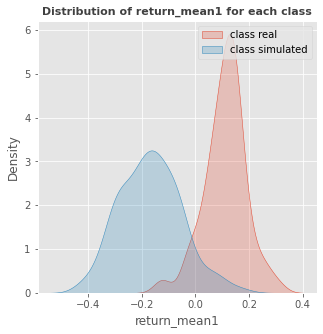

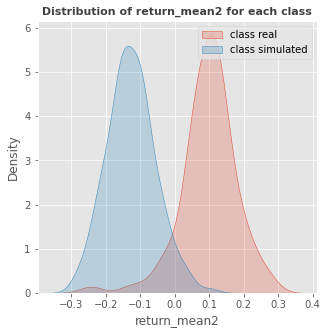

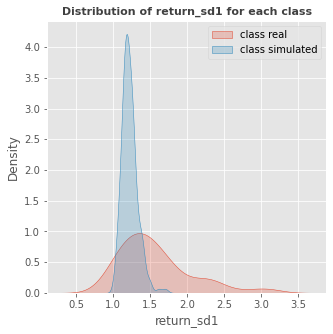

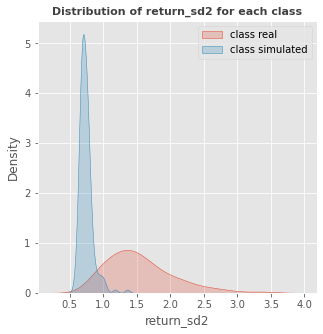

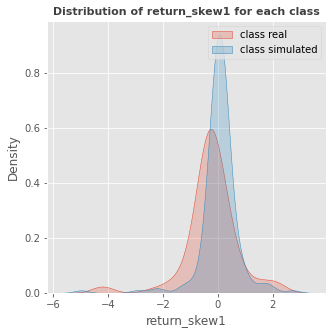

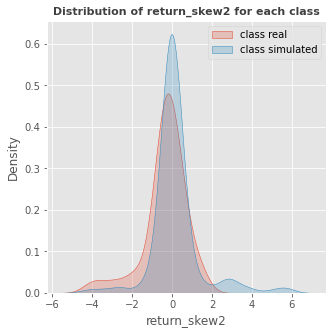

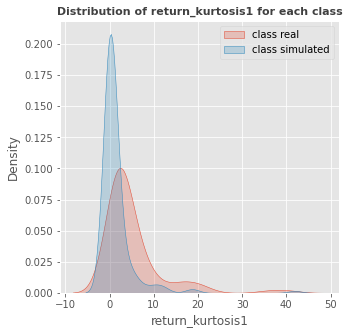

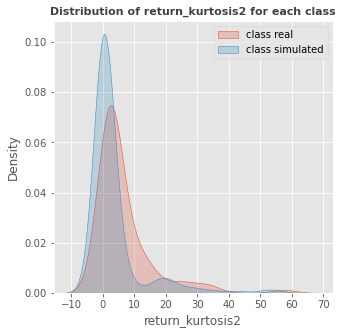

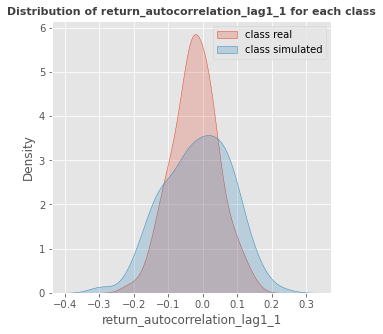

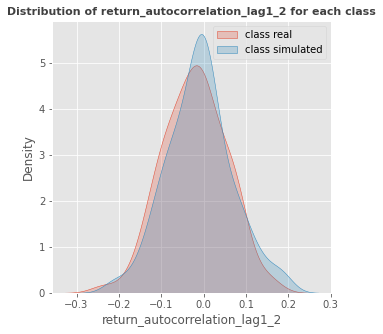

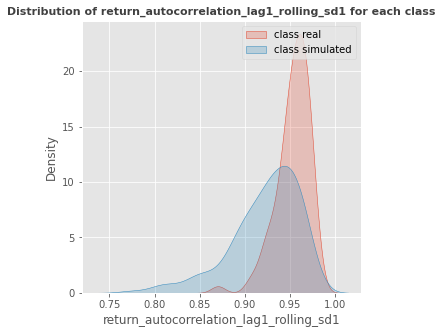

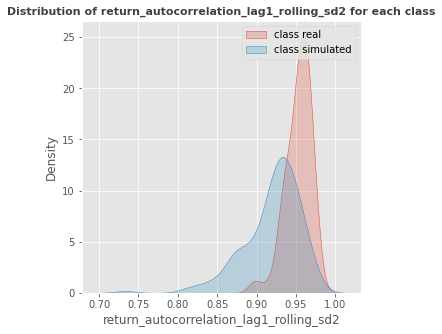

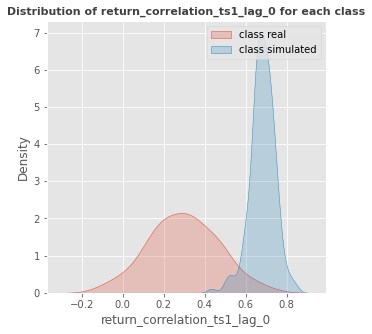

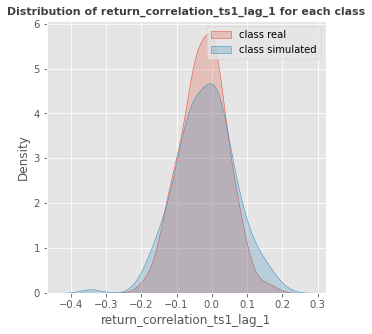

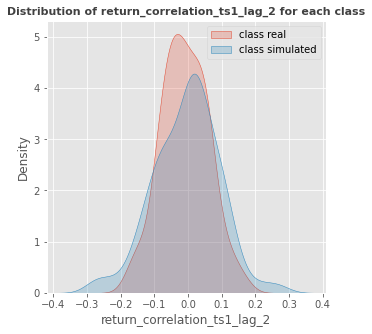

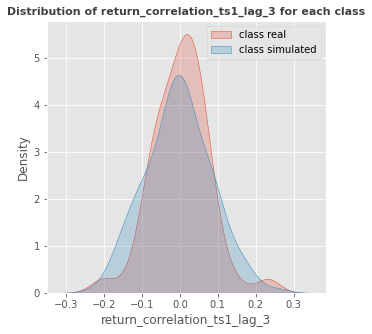

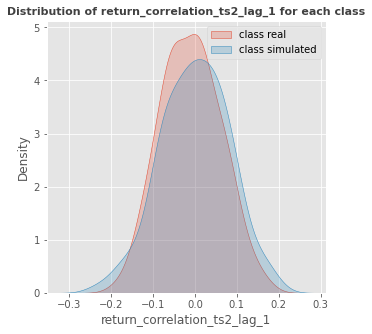

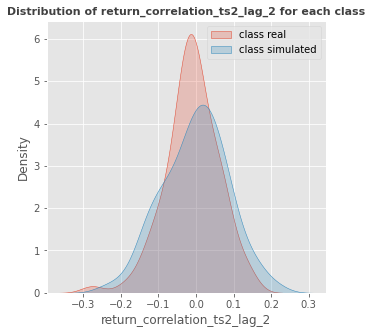

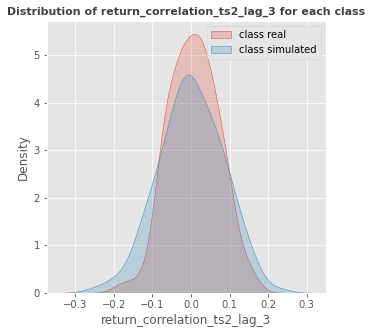

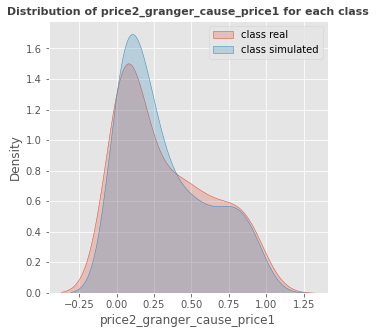

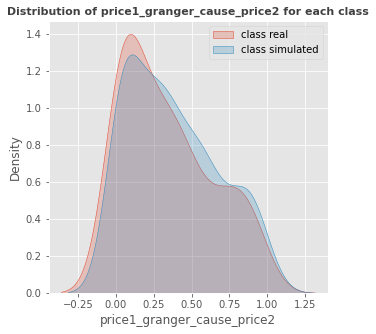

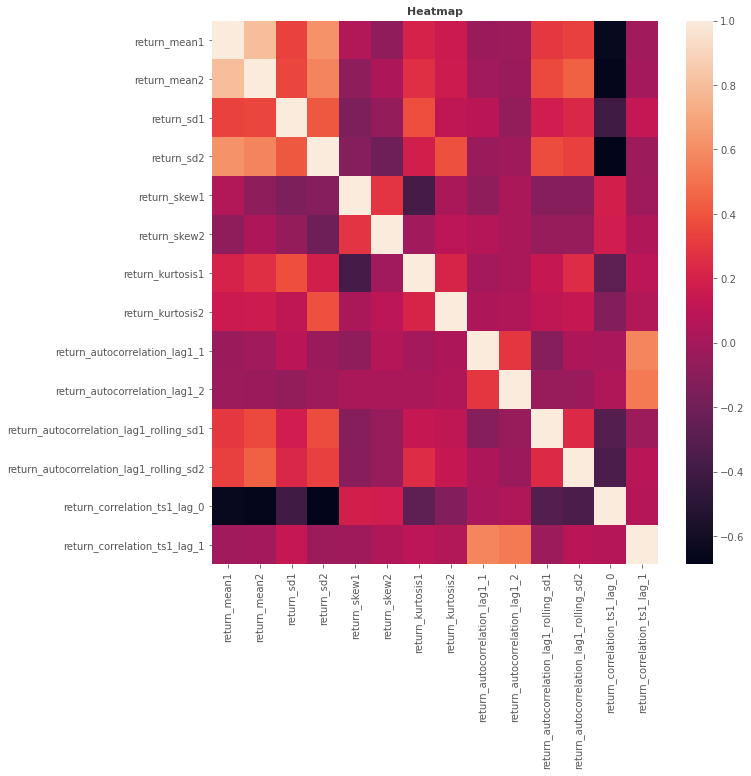

In [4]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
real_statistics = real_statistics.iloc[0:124 ,:]
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=delta0, 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T/2, length=length/2)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:21]
    y = dataset.iloc[:, 21]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/ou_jump12_calibration_update_classification_EDA/AutoML_EDA")
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)
print(results)
print(accuracy_average)
print(accuracy_std)